In [2]:
!pip -q install paddlepaddle -i https://pypi.tuna.tsinghua.edu.cn/simple

# 验证
import paddle
paddle.utils.run_check()
print("Paddle version:", paddle.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


Running verify PaddlePaddle program ... 
PaddlePaddle works well on 1 CPU.
PaddlePaddle is installed successfully! Let's start deep learning with PaddlePaddle now.
Paddle version: 3.2.0


/usr/local/lib/python3.12/dist-packages/paddle/pir/math_op_patch.py:219: UserWarning: Value do not have 'place' interface for pir graph mode, try not to use it. None will be returned.
  warnings.warn(


In [8]:
import math
from typing import Literal, Optional

import paddle
import paddle.nn as nn
import paddle.nn.functional as F

# ---------- 通用初始化 ------------------------------------------------------
def init_rsqrt_uniform_(w: paddle.Tensor) -> paddle.Tensor:
    bound = 1.0 / math.sqrt(w.shape[-1])
    noise = paddle.uniform(w.shape, min=-bound, max=bound, dtype=w.dtype)
    w.set_value(noise)
    return w

def init_random_signs_(w: paddle.Tensor) -> paddle.Tensor:
    # 0/1 伯努利 -> *2 -1  => {-1, +1}
    with paddle.no_grad():
        p = paddle.full(w.shape, 0.5, dtype='float32')
        s = paddle.bernoulli(p) * 2.0 - 1.0
        s = paddle.cast(s, w.dtype)
        w.set_value(s)
    return w

# ---------- 基础层 ----------------------------------------------------------
class NLinear(nn.Layer):
    """PackedEnsemble: K 份 Linear 打包 → 输入 (B,K,D), 权重布局 (K, I, O)"""
    def __init__(self, k: int, in_f: int, out_f: int, bias: bool = True):
        super().__init__()
        self.k = k
        self.in_f = in_f
        self.out_f = out_f
        # 按 Paddle 线性层布局 [I, O]
        self.weight = self.create_parameter(shape=[k, in_f, out_f])
        self.bias_e = self.create_parameter(shape=[k, out_f]) if bias else None
        self.reset_parameters()

    def reset_parameters(self):
        init_rsqrt_uniform_(self.weight)
        if self.bias_e is not None:
            init_rsqrt_uniform_(self.bias_e)

    def forward(self, x):                 # x: (B,K,D=I)
        # 转成 (K,B,D) 与 batched matmul 对齐
        xk = paddle.transpose(x, [1, 0, 2])           # (K,B,I)
        # (K,B,I) @ (K,I,O) = (K,B,O)
        yk = paddle.bmm(xk, self.weight)              # (K,B,O)
        y = paddle.transpose(yk, [1, 0, 2])           # (B,K,O)
        if self.bias_e is not None:
            y = y + self.bias_e                       # 广播到 (B,K,O)
        return y

class ScaleEnsemble(nn.Layer):
    """Mini-Ensemble：每层一个 rank-1 缩放向量"""
    def __init__(self, k: int, d: int, init='ones'):
        super().__init__()
        self.k = k
        self.d = d
        self.init = init
        self.weight = self.create_parameter(shape=[k, d])
        self.reset_parameters()

    def reset_parameters(self):
        if self.init == 'ones':
            self.weight.set_value(paddle.ones_like(self.weight))
        else:
            init_random_signs_(self.weight)

    def forward(self, x):                 # (B,K,D)
        return x * self.weight            # 广播到 (B,K,D)

class LinearBE(nn.Layer):
    """
    BatchEnsemble Linear（Paddle 布局）：
        权重 W: [I, O]；前向 y_e = ((x * r_e) @ W) * s_e + b_e
    输入:  x (B,K,I)
    输出:  y (B,K,O)
    """
    def __init__(self, in_f: int, out_f: int, k: int,
                 scale_init='ones', bias: bool = True):
        super().__init__()
        self.k = k
        self.in_f = in_f
        self.out_f = out_f
        # 显式属性名，避免冲突；按 Paddle 线性层布局 [I, O]
        self.weight = self.create_parameter(shape=[in_f, out_f])
        self.r = self.create_parameter(shape=[k, in_f])
        self.s = self.create_parameter(shape=[k, out_f])
        self.use_bias = bias
        self.bias_e = self.create_parameter(shape=[k, out_f]) if bias else None
        self.scale_init = scale_init
        self.reset_parameters()

    def reset_parameters(self):
        init_rsqrt_uniform_(self.weight)
        if self.scale_init == 'ones':
            self.r.set_value(paddle.ones_like(self.r))
            self.s.set_value(paddle.ones_like(self.s))
        else:
            init_random_signs_(self.r)
            init_random_signs_(self.s)
        if self.use_bias:
            init_rsqrt_uniform_(self.bias_e)

    def forward(self, x):                 # (B,K,I)
        xr = x * self.r                                  # (B,K,I)
        # (B,K,I) @ (I,O) = (B,K,O)
        y = paddle.matmul(xr, self.weight)               # (B,K,O)
        y = y * self.s                                   # (B,K,O)
        if self.use_bias:
            y = y + self.bias_e
        return y

# ---------- Backbone MLP -----------------------------------------------------
class MLPBlock(nn.Layer):
    def __init__(self, d_in, d_hid, dropout, act='ReLU'):
        super().__init__()
        Act = getattr(nn, act)
        self.net = nn.Sequential(
            nn.Linear(d_in, d_hid),   # Paddle: weight [d_in, d_hid]
            Act(),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # 允许 (B,K,D) 或 (B,D)；Linear 会在最后一维上工作
        return self.net(x)

class BackboneMLP(nn.Layer):
    def __init__(self, n_blocks: int, d_in: int, d_hidden: int, dropout: float):
        super().__init__()
        blocks = []
        for i in range(n_blocks):
            blocks.append(
                MLPBlock(d_in if i == 0 else d_hidden, d_hidden, dropout)
            )
        self.blocks = nn.LayerList(blocks)

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return x

# ---------- 工具：递归替换 Linear 为 BE / Packed ---------------------------
def _get_parent_by_path(root: nn.Layer, path_list):
    """根据命名路径拿到父层（最后一个名是子层名）"""
    cur = root
    for p in path_list:
        if hasattr(cur, p):
            cur = getattr(cur, p)
        else:
            sub_layers = getattr(cur, "_sub_layers", None)
            if sub_layers is None or p not in sub_layers:
                raise AttributeError(f"Cannot locate sublayer '{p}' under '{type(cur).__name__}'")
            cur = sub_layers[p]
    return cur

def _replace_linear(module: nn.Layer, k: int, mode: Literal['be', 'packed']):
    """
    遍历 module 的子层，把 nn.Linear 替换为 LinearBE 或 NLinear
    注意：Paddle Linear 的 weight 形状为 [in_features, out_features]
    """
    to_replace = []

    for full_name, layer in module.named_sublayers(include_self=False):
        if isinstance(layer, nn.Linear):
            parts = full_name.split('.')
            parent_path, child_name = parts[:-1], parts[-1]
            parent = _get_parent_by_path(module, parent_path) if parent_path else module

            in_f  = layer.weight.shape[0]  # I
            out_f = layer.weight.shape[1]  # O

            if mode == 'be':
                new_layer = LinearBE(in_f, out_f, k)
                with paddle.no_grad():
                    # 拷贝共享主权重（[I,O]）与偏置（[O]）
                    assert list(new_layer.weight.shape) == list(layer.weight.shape), \
                        f"weight shape mismatch: {new_layer.weight.shape} vs {layer.weight.shape}"
                    new_layer.weight.set_value(layer.weight.clone())
                    if layer.bias is not None and new_layer.bias_e is not None:
                        b = layer.bias.reshape([1, -1]).tile([k, 1])  # (K, O)
                        assert list(new_layer.bias_e.shape) == list(b.shape), \
                            f"bias shape mismatch: {new_layer.bias_e.shape} vs {b.shape}"
                        new_layer.bias_e.set_value(b)
            else:  # 'packed'
                new_layer = NLinear(k, in_f, out_f, bias=layer.bias is not None)
                with paddle.no_grad():
                    # 每个 pack 共享同一权重初值: 原 (I,O) -> (K,I,O)
                    w = layer.weight.unsqueeze(0).tile([k, 1, 1])  # (K,I,O)
                    assert list(new_layer.weight.shape) == list(w.shape), \
                        f"packed weight shape mismatch: {new_layer.weight.shape} vs {w.shape}"
                    new_layer.weight.set_value(w)
                    if layer.bias is not None and new_layer.bias_e is not None:
                        b = layer.bias.unsqueeze(0).tile([k, 1])    # (K,O)
                        assert list(new_layer.bias_e.shape) == list(b.shape), \
                            f"packed bias shape mismatch: {new_layer.bias_e.shape} vs {b.shape}"
                        new_layer.bias_e.set_value(b)

            to_replace.append((parent, child_name, new_layer))

    # 正式替换
    for parent, child_name, new_layer in to_replace:
        if hasattr(parent, child_name):
            setattr(parent, child_name, new_layer)
        else:
            sub_layers = getattr(parent, "_sub_layers", None)
            if sub_layers is None or child_name not in sub_layers:
                raise AttributeError(f"Cannot set sublayer '{child_name}' under '{type(parent).__name__}'")
            parent._sub_layers[child_name] = new_layer

# ---------- TabM 特征提取器 --------------------------------------------------
class TabMFeatureExtractor(nn.Layer):
    """
    arch_type: 'plain' | 'tabm' | 'tabm-mini' | 'tabm-packed'
    返回：
        - reduce=True  → (B,H)
        - reduce=False → (B,K,H)
    """
    def __init__(self,
                 num_features: int,
                 arch_type: Literal['plain', 'tabm', 'tabm-mini', 'tabm-packed']='tabm',
                 k: int = 32,
                 backbone_cfg: Optional[dict] = None,
                 reduce: bool = True):
        super().__init__()
        if arch_type == 'plain':
            k = 1
        self.k = k
        self.reduce = reduce
        cfg = backbone_cfg or dict(n_blocks=3, d_hidden=512, dropout=0.1)
        self.backbone = BackboneMLP(**cfg, d_in=num_features)

        # --- 插入 Ensemble 逻辑 ---
        if arch_type == 'tabm':
            _replace_linear(self.backbone, k, mode='be')
            self.min_adapter = None
        elif arch_type == 'tabm-mini':
            self.min_adapter = ScaleEnsemble(k, num_features, init='random-signs')
        elif arch_type == 'tabm-packed':
            _replace_linear(self.backbone, k, mode='packed')
            self.min_adapter = None
        else:  # plain
            self.min_adapter = None

    def forward(self, x_num: paddle.Tensor):
        """
        x_num : (B, num_features) – 已完成数值化/标准化
        """
        if self.k > 1:
            x = x_num.unsqueeze(1).tile([1, self.k, 1])  # (B,K,D)
        else:
            x = x_num.unsqueeze(1)                        # (B,1,D)

        if self.min_adapter is not None:
            x = self.min_adapter(x)                       # (B,K,D)

        features = self.backbone(x)                       # (B,K,H)
        if self.reduce:
            return features.mean(axis=1)                  # (B,H)
        return features                                   # (B,K,H)

# ---------------- Quick check ----------------
if __name__ == '__main__':
    paddle.seed(123)
    B, D = 8, 30
    x = paddle.randn([B, D])
    # 1) 标准 TabM（BatchEnsemble 替换）
    fe1 = TabMFeatureExtractor(D, arch_type='tabm', k=16, reduce=True)
    out1 = fe1(x)
    print('TabM-BE features:', list(out1.shape))   # (B, H)

    # 2) tabm-mini（只做 rank-1 缩放）
    fe2 = TabMFeatureExtractor(D, arch_type='tabm-mini', k=16, reduce=False)
    out2 = fe2(x)
    print('TabM-mini features:', list(out2.shape)) # (B, K, H)

    # 3) tabm-packed（Packed NLinear）
    fe3 = TabMFeatureExtractor(D, arch_type='tabm-packed', k=8, reduce=True)
    out3 = fe3(x)
    print('TabM-packed features:', list(out3.shape)) # (B, H)

    # 4) plain（无集成基线）
    fe4 = TabMFeatureExtractor(D, arch_type='plain', k=1, reduce=True)
    out4 = fe4(x)
    print('Plain features:', list(out4.shape))     # (B, H)


TabM-BE features: [8, 512]
TabM-mini features: [8, 16, 512]
TabM-packed features: [8, 512]
Plain features: [8, 512]


In [9]:
# -*- coding: utf-8 -*-
import math
from typing import Optional, Literal, Tuple
import numpy as np
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.io import Dataset, DataLoader


# ====== 数据集（示例：合成数据）========================================
class ToyMultiLabelDataset(Dataset):
    """
    返回:
      x_num: float32, 形状 (D,)
      y:     float32, 形状 (4,)  —— 多标签 0/1
    """
    def __init__(self, n: int, d: int, seed: int = 123):
        super().__init__()
        rng = np.random.default_rng(seed)
        self.X = rng.normal(size=(n, d)).astype('float32')
        # 随机生成 4 个线性规则 + 噪声，得到多标签
        W = rng.normal(size=(d, 4))
        logits = self.X @ W + rng.normal(scale=0.5, size=(n, 4))
        probs  = 1.0 / (1.0 + np.exp(-logits))
        self.Y = (probs > 0.5).astype('float32')

    def __getitem__(self, idx: int):
        return self.X[idx], self.Y[idx]

    def __len__(self) -> int:
        return len(self.X)

# ====== 模型：特征抽取 + 多标签头 ======================================
class MultiLabelClassifier(nn.Layer):
    def __init__(self, num_features: int, num_labels: int = 4,
                 arch_type: str = 'tabm', k: int = 16,
                 backbone_cfg: Optional[dict] = None):
        super().__init__()
        self.fe = TabMFeatureExtractor(
            num_features=num_features,
            arch_type=arch_type,
            k=k,
            backbone_cfg=backbone_cfg,
            reduce=True
        )
        # 推断隐藏维度（若你的 TabM 有属性可读，直接使用；否则手动传入）
        d_hidden = getattr(self.fe, "d_hidden", (backbone_cfg or dict(d_hidden=512))["d_hidden"])
        self.head = nn.Linear(d_hidden, num_labels)

    def forward(self, x_num: paddle.Tensor) -> paddle.Tensor:
        # x_num: (B, D)
        h = self.fe(x_num)           # (B, H)
        logits = self.head(h)        # (B, 4)
        return logits

# ====== 评价指标：F1、AP 等 ==============================================
def f1_per_class(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-9) -> Tuple[np.ndarray, float, float]:
    """
    y_true: (N, C) 0/1
    y_pred: (N, C) 0/1
    返回: per_class F1, macro-F1, micro-F1
    """
    assert y_true.shape == y_pred.shape
    N, C = y_true.shape
    f1_c = np.zeros(C, dtype=np.float32)

    # per-class
    for c in range(C):
        yt = y_true[:, c]
        yp = y_pred[:, c]
        tp = np.sum((yt == 1) & (yp == 1))
        fp = np.sum((yt == 0) & (yp == 1))
        fn = np.sum((yt == 1) & (yp == 0))
        prec = tp / (tp + fp + eps)
        rec  = tp / (tp + fn + eps)
        f1_c[c] = 2 * prec * rec / (prec + rec + eps)

    macro_f1 = float(np.mean(f1_c))

    # micro
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    micro_f1 = 2 * prec * rec / (prec + rec + 1e-9)
    return f1_c, macro_f1, float(micro_f1)

def average_precision_micro(y_true: np.ndarray, y_prob: np.ndarray, num_thresholds: int = 101) -> float:
    """
    简易版 micro-AP(AUCPR)：在 0~1 阈值上扫一遍，近似计算 PR 曲线下面积
    """
    thresholds = np.linspace(0.0, 1.0, num_thresholds)
    precision, recall = [], []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(np.float32)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        p = tp / (tp + fp + 1e-9)
        r = tp / (tp + fn + 1e-9)
        precision.append(p); recall.append(r)
    # 按 recall 升序进行梯形积分
    order = np.argsort(recall)
    recall = np.array(recall)[order]
    precision = np.array(precision)[order]
    auc_pr = np.trapz(precision, recall)
    return float(auc_pr)

# ====== 训练/验证循环 =====================================================
def train_one_epoch(model, loader, optimizer,
                    pos_weight: Optional[paddle.Tensor] = None,
                    clip_grad_norm: Optional[float] = None,
                    device: str = 'gpu' if paddle.is_compiled_with_cuda() else 'cpu'):
    model.train()
    total_loss = 0.0
    total_batches = 0
    for x, y in loader:
        x = x.astype('float32')
        y = y.astype('float32')
        logits = model(x)
        # BCE with logits（支持 pos_weight）
        if pos_weight is not None:
            loss = F.binary_cross_entropy_with_logits(logits, y, pos_weight=pos_weight)
        else:
            loss = F.binary_cross_entropy_with_logits(logits, y)
        loss.backward()
        if clip_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_norm)
        optimizer.step()
        optimizer.clear_grad()
        total_loss += float(loss)
        total_batches += 1
    return total_loss / max(1, total_batches)

@paddle.no_grad()
def evaluate(model, loader, threshold: float = 0.5):
    model.eval()
    ys, ps = [], []
    total_loss, total_batches = 0.0, 0
    for x, y in loader:
        x = x.astype('float32'); y = y.astype('float32')
        logits = model(x)                    # (B,4)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        prob = F.sigmoid(logits).numpy()     # (B,4)
        ys.append(y.numpy())
        ps.append(prob)
        total_loss += float(loss)
        total_batches += 1
    y_true = np.concatenate(ys, axis=0)
    y_prob = np.concatenate(ps, axis=0)
    y_pred = (y_prob >= threshold).astype(np.float32)

    per_f1, macro_f1, micro_f1 = f1_per_class(y_true, y_pred)
    ap_micro = average_precision_micro(y_true, y_prob)
    avg_loss = total_loss / max(1, total_batches)
    metrics = {
        "loss": avg_loss,
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "per_class_f1": per_f1.tolist(),
        "micro_AP": ap_micro
    }
    return metrics

# ====== 主函数：跑通一个最小示例 ===========================================
if __name__ == "__main__":
    paddle.seed(2025)
    # 配置
    D = 30              # 数值特征维度
    C = 4               # 多标签数
    N_train, N_val = 5000, 1000
    batch_size = 128
    epochs = 5
    lr = 3e-4

    # 数据
    train_ds = ToyMultiLabelDataset(N_train, D, seed=42)
    val_ds   = ToyMultiLabelDataset(N_val,   D, seed=233)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)

    # 类别不平衡（可选）：按训练集估计每个标签的正例比例，构造 pos_weight
    y_train = np.vstack([y for _, y in train_ds])
    pos_ratio = np.clip(y_train.mean(axis=0), 1e-3, 1-1e-3)   # (4,)
    # 经典做法：pos_weight = (N_neg / N_pos) = (1-p)/p
    pos_weight_np = (1.0 - pos_ratio) / pos_ratio
    pos_weight = paddle.to_tensor(pos_weight_np.astype('float32'))  # (4,)

    # 模型
    backbone_cfg = dict(n_blocks=3, d_hidden=512, dropout=0.1)
    model = MultiLabelClassifier(num_features=D, num_labels=C,
                                 arch_type='tabm', k=16,
                                 backbone_cfg=backbone_cfg)

    optimizer = paddle.optimizer.Adam(learning_rate=lr, parameters=model.parameters())

    # 训练
    best_macro_f1, best_state = -1.0, None
    for ep in range(1, epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer,
                                     pos_weight=pos_weight, clip_grad_norm=1.0)
        val_metrics = evaluate(model, val_loader, threshold=0.5)
        print(f"[Epoch {ep:02d}] train_loss={train_loss:.4f} | "
              f"val_loss={val_metrics['loss']:.4f} | "
              f"macro_f1={val_metrics['macro_f1']:.4f} | "
              f"micro_f1={val_metrics['micro_f1']:.4f} | "
              f"per_class_f1={val_metrics['per_class_f1']} | "
              f"micro_AP={val_metrics['micro_AP']:.4f}")
        # 记录最佳
        if val_metrics["macro_f1"] > best_macro_f1:
            best_macro_f1 = val_metrics["macro_f1"]
            best_state = {k: v.clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.set_state_dict(best_state)
        print(f"Loaded best state with macro_f1={best_macro_f1:.4f}")


/tmp/ipython-input-1539235308.py:108: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(precision, recall)


[Epoch 01] train_loss=0.4427 | val_loss=1.5854 | macro_f1=0.4728 | micro_f1=0.4734 | per_class_f1=[0.5263158082962036, 0.5373737215995789, 0.4471057951450348, 0.38046795129776] | micro_AP=0.4584
[Epoch 02] train_loss=0.1538 | val_loss=2.9504 | macro_f1=0.4818 | micro_f1=0.4837 | per_class_f1=[0.553903341293335, 0.5406504273414612, 0.44742268323898315, 0.38532111048698425] | micro_AP=0.4769
[Epoch 03] train_loss=0.1057 | val_loss=3.7486 | macro_f1=0.4919 | micro_f1=0.4941 | per_class_f1=[0.5516605377197266, 0.568965494632721, 0.4606299102306366, 0.38624873757362366] | micro_AP=0.4722
[Epoch 04] train_loss=0.0917 | val_loss=4.2100 | macro_f1=0.4762 | micro_f1=0.4774 | per_class_f1=[0.5183752179145813, 0.557729959487915, 0.43551796674728394, 0.3932472765445709] | micro_AP=0.4652
[Epoch 05] train_loss=0.0732 | val_loss=4.7243 | macro_f1=0.4810 | micro_f1=0.4820 | per_class_f1=[0.5422138571739197, 0.5443425178527832, 0.4589178264141083, 0.3785425126552582] | micro_AP=0.4507
Loaded best stat

In [14]:
# -*- coding: utf-8 -*-
import math
from typing import Optional, Literal, Tuple
import numpy as np
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.io import Dataset, DataLoader
from paddle.vision.models import resnet18

# ====================== 工具：正弦位置编码 ======================
class SinusoidalPositionalEncoding(nn.Layer):
    def __init__(self, d_model: int, max_len: int = 2048):
        super().__init__()
        pe = np.zeros((max_len, d_model), dtype="float32")
        position = np.arange(0, max_len, dtype="float32")[:, None]
        div_term = np.exp(np.arange(0, d_model, 2, dtype="float32") * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.register_buffer("pe", paddle.to_tensor(pe), persistable=False)

    def forward(self, x):  # x: (B, T, D)
        T = x.shape[1]
        return x + self.pe[:T, :]

# ====================== 简化版 TabM（占位，可换成你的实现） ======================
class TabMFeatureExtractor(nn.Layer):
    """占位实现：MLP → (B, H)。可直接替换为你修好的 TabM。"""
    def __init__(self, num_features: int, d_hidden: int = 512, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_features, d_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
        )
        self.d_hidden = d_hidden

    def forward(self, x_num: paddle.Tensor):  # (B, 424)
        return self.net(x_num)                # (B, H)

# ====================== ResNet18 特征抽取（逐帧） ======================
class ResNet18FrameEncoder(nn.Layer):
    """将 ResNet18 改为 20 通道输入；输出每帧 512 维特征。"""
    def __init__(self, in_channels: int = 20):
        super().__init__()
        self.backbone = resnet18(pretrained=False)
        # 改首层卷积为 20 通道
        self.backbone.conv1 = nn.Conv2D(in_channels, 64, kernel_size=7, stride=2, padding=3, bias_attr=False)
        # 去掉分类头 fc，保留到 avgpool
        self.avgpool = self.backbone.avgpool  # AdaptiveAvgPool2D(1)
        # 记录下游维度
        self.out_dim = 512

    def forward(self, x):  # x: (B*T, C=20, H=20, W=20)
        m = self.backbone
        x = m.conv1(x); x = m.bn1(x); x = F.relu(x); x = m.maxpool(x)
        x = m.layer1(x); x = m.layer2(x); x = m.layer3(x); x = m.layer4(x)
        x = self.avgpool(x)          # (B*T, 512, 1, 1)
        x = paddle.flatten(x, 1)     # (B*T, 512)
        return x

# ====================== 时序 Transformer 编码器 ======================
class TemporalTransformer(nn.Layer):
    def __init__(self, d_model=512, nhead=8, num_layers=4, dim_feedforward=1024, dropout=0.1, max_len=1024):
        super().__init__()
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                               dim_feedforward=dim_feedforward,
                                               dropout=dropout, activation='relu')
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.pos = SinusoidalPositionalEncoding(d_model, max_len=max_len)

    def forward(self, x):  # x: (B, T, D)
        x = self.pos(x)
        # Paddle 的 Transformer 期望 (T, B, D)
        x = paddle.transpose(x, [1, 0, 2])         # (T,B,D)
        z = self.encoder(x)                        # (T,B,D)
        z = paddle.transpose(z, [1, 0, 2])         # (B,T,D)
        return z

# ====================== 多头注意力（支持 q from A, kv from B） ======================
class MultiHeadCrossAttention(nn.Layer):
    def __init__(self, d_model: int, nhead: int = 8, dropout: float = 0.1):
        super().__init__()
        assert d_model % nhead == 0
        self.d_model = d_model
        self.nhead = nhead
        self.d_head = d_model // nhead
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, q, kv):
        """
        q:  (B, Nq, D)
        kv: (B, Nk, D)
        return: (B, Nq, D)   # 残差 + LN
        """
        B, Nq, D = q.shape
        Nk = kv.shape[1]

        q_lin = self.Wq(q)  # (B,Nq,D)
        k_lin = self.Wk(kv) # (B,Nk,D)
        v_lin = self.Wv(kv) # (B,Nk,D)

        def split_heads(t):  # (B,N,Heads,dh)
            return t.reshape([B, -1, self.nhead, self.d_head]).transpose([0, 2, 1, 3])

        qh = split_heads(q_lin)  # (B,H,Nq,dh)
        kh = split_heads(k_lin)  # (B,H,Nk,dh)
        vh = split_heads(v_lin)  # (B,H,Nk,dh)

        scores = paddle.matmul(qh, kh, transpose_y=True) / math.sqrt(self.d_head)  # (B,H,Nq,Nk)
        attn = F.softmax(scores, axis=-1)
        ctx = paddle.matmul(attn, vh)  # (B,H,Nq,dh)

        ctx = ctx.transpose([0, 2, 1, 3]).reshape([B, Nq, D])  # (B,Nq,D)
        out = self.proj(ctx)
        out = self.drop(out)
        # 残差 + LN
        return self.ln(out + q)

# ====================== 融合头（双向 Cross-Attn） ======================
class BiModalCrossFusion(nn.Layer):
    """
    输入：
      video_seq: (B, T, D) —— Transformer 后的视频序列
      tabm_tok:  (B, D)    —— TabM token
    过程：
      v_token = mean(video_seq)
      v' = CrossAttn(q=v_token[1], kv=tabm_token[1])
      t' = CrossAttn(q=tabm_token[1], kv=video_seq[T])
      fuse = concat([v', t']) → MLP
    """
    def __init__(self, d_model=512, nhead=8, dropout=0.1, fuse_hidden=512):
        super().__init__()
        self.ca_v_from_t = MultiHeadCrossAttention(d_model, nhead, dropout)
        self.ca_t_from_v = MultiHeadCrossAttention(d_model, nhead, dropout)
        self.fuse = nn.Sequential(
            nn.Linear(2 * d_model, fuse_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.out_dim = fuse_hidden

    def forward(self, video_seq, tabm_tok):
        B, T, D = video_seq.shape
        # 池化出视频 token
        v_tok = video_seq.mean(axis=1, keepdim=True)      # (B,1,D)
        t_tok = tabm_tok.unsqueeze(1)                     # (B,1,D)

        v_upd = self.ca_v_from_t(v_tok, t_tok)            # (B,1,D)
        t_upd = self.ca_t_from_v(t_tok, video_seq)        # (B,1,D)

        fused = paddle.concat([v_upd, t_upd], axis=-1)    # (B,1,2D)
        fused = fused.squeeze(1)                          # (B,2D)
        return self.fuse(fused)                           # (B, F)

# ====================== 总模型 ======================
class TwoModalMultiLabelModel(nn.Layer):
    def __init__(self,
                 # 视频模态
                 vid_channels=20, vid_h=20, vid_w=20, vid_frames=36,
                 # 结构化模态
                 vec_dim=424,
                 # 维度与结构
                 d_model=512, nhead=8, n_trans_layers=4, trans_ff=1024,
                 tabm_hidden=512, dropout=0.1, num_labels=4):
        super().__init__()
        # A: 逐帧 ResNet18
        self.frame_encoder = ResNet18FrameEncoder(in_channels=vid_channels)  # (B*T,512)
        # A: 时序 Transformer
        self.temporal = TemporalTransformer(d_model=d_model,
                                            nhead=nhead,
                                            num_layers=n_trans_layers,
                                            dim_feedforward=trans_ff,
                                            dropout=dropout,
                                            max_len=vid_frames)
        # B: TabM（或替换为你的 TabM）
        self.tabm = TabMFeatureExtractor(vec_dim, d_hidden=tabm_hidden, dropout=dropout)
        self.tabm_proj = nn.Linear(tabm_hidden, d_model)  # 对齐到 d_model
        # 融合：双向 Cross-Attention
        self.fusion = BiModalCrossFusion(d_model=d_model, nhead=nhead, dropout=dropout, fuse_hidden=d_model)
        # 分类头
        self.head = nn.Linear(self.fusion.out_dim, num_labels)

    def forward(self, x_video, x_vec):
        """
        x_video: (B, T, C=20, H=20, W=20)
        x_vec:   (B, 424)
        """
        B, T, C, H, W = x_video.shape
        # ---- A: 逐帧 ResNet ----
        xvt = x_video.reshape([B * T, C, H, W])          # (B*T, C, H, W)
        f_frame = self.frame_encoder(xvt)                # (B*T, 512)
        f_seq = f_frame.reshape([B, T, -1])              # (B, T, 512)
        # ---- A: 时序 Transformer ----
        z_vid = self.temporal(f_seq)                     # (B, T, 512)
        # ---- B: TabM 特征 ----
        z_tabm = self.tabm(x_vec)                        # (B, H_tabm)
        z_tabm = self.tabm_proj(z_tabm)                  # (B, 512)
        # ---- Cross-Attention 融合 ----
        fused = self.fusion(z_vid, z_tabm)               # (B, 512)
        # ---- 分类 ----
        logits = self.head(fused)                        # (B, 4)
        return logits

# ====================== 指标与训练循环（与前一致） ======================
def f1_per_class(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-9) -> Tuple[np.ndarray, float, float]:
    assert y_true.shape == y_pred.shape
    N, C = y_true.shape
    f1_c = np.zeros(C, dtype=np.float32)
    for c in range(C):
        yt, yp = y_true[:, c], y_pred[:, c]
        tp = np.sum((yt == 1) & (yp == 1))
        fp = np.sum((yt == 0) & (yp == 1))
        fn = np.sum((yt == 1) & (yp == 0))
        prec = tp / (tp + fp + eps)
        rec  = tp / (tp + fn + eps)
        f1_c[c] = 2 * prec * rec / (prec + rec + eps)
    macro_f1 = float(np.mean(f1_c))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    micro_f1 = 2 * prec * rec / (prec + rec + 1e-9)
    return f1_c, macro_f1, float(micro_f1)

def average_precision_micro(y_true: np.ndarray, y_prob: np.ndarray, num_thresholds: int = 101) -> float:
    thresholds = np.linspace(0.0, 1.0, num_thresholds)
    precision, recall = [], []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(np.float32)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        p = tp / (tp + fp + 1e-9)
        r = tp / (tp + fn + 1e-9)
        precision.append(p); recall.append(r)
    order = np.argsort(recall)
    recall = np.array(recall)[order]
    precision = np.array(precision)[order]
    return float(np.trapz(precision, recall))

def train_one_epoch(model, loader, optimizer,
                    pos_weight: Optional[paddle.Tensor] = None,
                    clip_grad_norm: Optional[float] = None):
    model.train()
    total_loss, total_batches = 0.0, 0
    for x_vid, x_vec, y in loader:
        logits = model(x_vid.astype('float32'), x_vec.astype('float32'))
        if pos_weight is not None:
            loss = F.binary_cross_entropy_with_logits(logits, y.astype('float32'), pos_weight=pos_weight)
        else:
            loss = F.binary_cross_entropy_with_logits(logits, y.astype('float32'))
        loss.backward()
        if clip_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_norm)
        optimizer.step()
        optimizer.clear_grad()
        total_loss += float(loss); total_batches += 1
    return total_loss / max(1, total_batches)

@paddle.no_grad()
def evaluate(model, loader, threshold: float = 0.5):
    model.eval()
    ys, ps = [], []
    total_loss, total_batches = 0.0, 0
    for x_vid, x_vec, y in loader:
        logits = model(x_vid.astype('float32'), x_vec.astype('float32'))
        loss = F.binary_cross_entropy_with_logits(logits, y.astype('float32'))
        prob = F.sigmoid(logits).numpy()
        ys.append(y.numpy()); ps.append(prob)
        total_loss += float(loss); total_batches += 1
    y_true = np.concatenate(ys, axis=0)
    y_prob = np.concatenate(ps, axis=0)
    y_pred = (y_prob >= threshold).astype(np.float32)
    per_f1, macro_f1, micro_f1 = f1_per_class(y_true, y_pred)
    ap_micro = average_precision_micro(y_true, y_prob)
    return {
        "loss": total_loss / max(1, total_batches),
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "per_class_f1": per_f1.tolist(),
        "micro_AP": ap_micro
    }

# ====================== 合成数据集（可替换为真实数据） ======================
class ToyTwoModalDataset(Dataset):
    """
    返回：
      x_video: (T=365, C=20, H=20, W=20)
      x_vec:   (424,)
      y:       (4,)  0/1
    """
    def __init__(self, n: int, seed: int = 0):
        super().__init__()
        rng = np.random.default_rng(seed)
        self.n = n
        # 按 (n, T, C, H, W)
        self.video = rng.normal(size=(n, 36, 20, 20, 20)).astype('float32')
        self.vec   = rng.normal(size=(n, 424)).astype('float32')

        # 造标签：对视频先在 H/W 上均值，再在 T 上均值 → (n, C=20)
        vid_hw  = self.video.mean(axis=(3, 4))   # (n, T, C)
        vid_avg = vid_hw.mean(axis=1)            # (n, C)

        # 线性映射到 4 个标签
        Wv = rng.normal(size=(20, 4))            # C→4
        Wt = rng.normal(size=(424, 4))           # 424→4
        logits = vid_avg @ Wv + self.vec @ Wt + rng.normal(scale=0.5, size=(n, 4))
        probs  = 1.0 / (1.0 + np.exp(-logits))
        self.y = (probs > 0.5).astype('float32')

    def __getitem__(self, idx: int):
        x_vid = self.video[idx]  # (T,C,H,W)
        x_vec = self.vec[idx]    # (424,)
        y     = self.y[idx]      # (4,)
        return x_vid, x_vec, y

    def __len__(self):
        return self.n

# ====================== 训练入口（可直接运行） ======================
if __name__ == "__main__":
    paddle.seed(2025)
    # 数据
    train_ds = ToyTwoModalDataset(n=64,  seed=42)   # 注意：真实训练建议更大数据与多卡
    val_ds   = ToyTwoModalDataset(n=32,  seed=233)
    # 自定义 collate：让视频变成 (B,T,C,H,W)
    def collate_fn(batch):
        vids, vecs, ys = zip(*batch)
        return (paddle.to_tensor(np.stack(vids, 0)),   # (B,T,C,H,W)
                paddle.to_tensor(np.stack(vecs, 0)),   # (B,424)
                paddle.to_tensor(np.stack(ys, 0)))     # (B,4)
    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, drop_last=False, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=2, shuffle=False, drop_last=False, collate_fn=collate_fn)

    # 类别不平衡权重（可选）
    y_train = np.stack([y for _, _, y in train_ds], 0)
    pos_ratio = np.clip(y_train.mean(axis=0), 1e-3, 1-1e-3)
    pos_weight = paddle.to_tensor(((1-pos_ratio)/pos_ratio).astype('float32'))  # (4,)

    # 模型
    model = TwoModalMultiLabelModel(
        vid_channels=20, vid_h=20, vid_w=20, vid_frames=36,
        vec_dim=424,
        d_model=512, nhead=2, n_trans_layers=2, trans_ff=1024,  # 可调
        tabm_hidden=512, dropout=0.1,
        num_labels=4
    )
    optimizer = paddle.optimizer.Adam(learning_rate=3e-4, parameters=model.parameters())

    # 训练（演示用：小 epoch）
    best_macro_f1, best = -1.0, None
    for ep in range(1, 3+1):
        train_loss = train_one_epoch(model, train_loader, optimizer,
                                     pos_weight=pos_weight, clip_grad_norm=1.0)
        val_metrics = evaluate(model, val_loader, threshold=0.5)
        print(f"[Epoch {ep:02d}] train_loss={train_loss:.4f} | "
              f"val_loss={val_metrics['loss']:.4f} | "
              f"macro_f1={val_metrics['macro_f1']:.4f} | "
              f"micro_f1={val_metrics['micro_f1']:.4f} | "
              f"per_class_f1={val_metrics['per_class_f1']} | "
              f"micro_AP={val_metrics['micro_AP']:.4f}")
        if val_metrics["macro_f1"] > best_macro_f1:
            best_macro_f1 = val_metrics["macro_f1"]
            best = {k: v.clone() for k, v in model.state_dict().items()}

    if best is not None:
        model.set_state_dict(best)
        print(f"Loaded best state with macro_f1={best_macro_f1:.4f}")


/tmp/ipython-input-3157620546.py:248: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(precision, recall))


[Epoch 01] train_loss=1.1304 | val_loss=1.0465 | macro_f1=0.3765 | micro_f1=0.5079 | per_class_f1=[0.5, 0.7450980544090271, 0.260869562625885, 0.0] | micro_AP=0.5393
[Epoch 02] train_loss=0.7661 | val_loss=0.9369 | macro_f1=0.5812 | micro_f1=0.6173 | per_class_f1=[0.5454545617103577, 0.7599999904632568, 0.6382978558540344, 0.380952388048172] | micro_AP=0.4165
[Epoch 03] train_loss=0.4050 | val_loss=1.9395 | macro_f1=0.6107 | micro_f1=0.6303 | per_class_f1=[0.5454545617103577, 0.7234042286872864, 0.6938775777816772, 0.47999998927116394] | micro_AP=0.3836
Loaded best state with macro_f1=0.6107


In [16]:
# -*- coding: utf-8 -*-
import math
from typing import Optional, Tuple
import numpy as np
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.io import Dataset, DataLoader
from paddle.vision.models import resnet18

# ====================== 工具：正弦位置编码 ======================
class SinusoidalPositionalEncoding(nn.Layer):
    def __init__(self, d_model: int, max_len: int = 2048):
        super().__init__()
        pe = np.zeros((max_len, d_model), dtype="float32")
        position = np.arange(0, max_len, dtype="float32")[:, None]
        div_term = np.exp(np.arange(0, d_model, 2, dtype="float32") * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.register_buffer("pe", paddle.to_tensor(pe), persistable=False)

    def forward(self, x):  # x: (B, T, D)
        T = x.shape[1]
        return x + self.pe[:T, :]

# ====================== 简化版 TabM（占位，可换成你的实现） ======================
class TabMFeatureExtractor(nn.Layer):
    """占位实现：MLP → (B, H)。可直接替换为你修好的 TabM。"""
    def __init__(self, num_features: int, d_hidden: int = 512, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_features, d_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
        )
        self.d_hidden = d_hidden

    def forward(self, x_num: paddle.Tensor):  # (B, 424)
        return self.net(x_num)                # (B, H)

# ====================== ResNet18 特征抽取（逐帧） ======================
class ResNet18FrameEncoder(nn.Layer):
    """将 ResNet18 改为 20 通道输入；输出每帧 512 维特征。"""
    def __init__(self, in_channels: int = 20):
        super().__init__()
        self.backbone = resnet18(pretrained=False)
        # 改首层卷积为 20 通道
        self.backbone.conv1 = nn.Conv2D(in_channels, 64, kernel_size=7, stride=2, padding=3, bias_attr=False)
        # 去掉分类头 fc，保留到 avgpool
        self.avgpool = self.backbone.avgpool  # AdaptiveAvgPool2D(1)
        self.out_dim = 512

    def forward(self, x):  # x: (B*T, C=20, H=20, W=20)
        m = self.backbone
        x = m.conv1(x); x = m.bn1(x); x = F.relu(x); x = m.maxpool(x)
        x = m.layer1(x); x = m.layer2(x); x = m.layer3(x); x = m.layer4(x)
        x = self.avgpool(x)          # (B*T, 512, 1, 1)
        x = paddle.flatten(x, 1)     # (B*T, 512)
        return x

# ====================== MoE 基础实现（Top-k，可开关；使用 gather_nd 修复） ======================
class ExpertFFN(nn.Layer):
    def __init__(self, d_model, d_ff, dropout=0.1, act='relu'):
        super().__init__()
        Act = getattr(F, act) if isinstance(act, str) else act
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.drop = nn.Dropout(dropout)
        self.act = Act
    def forward(self, x):
        return self.fc2(self.drop(self.act(self.fc1(x))))

class MoEConfig:
    def __init__(self,
                 n_experts=8,
                 top_k=1,
                 d_ff=2048,
                 dropout=0.1,
                 router_temp=0.5,
                 balance_loss_w=0.005,
                 entropy_reg_w=-0.005,  # 负值→更尖锐
                 diversity_w=1e-3,
                 sticky_w=0.0,
                 sup_router_w=0.0,
                 use_gumbel=True):
        self.n_experts = n_experts
        self.top_k = top_k
        self.d_ff = d_ff
        self.dropout = dropout
        self.router_temp = router_temp
        self.balance_loss_w = balance_loss_w
        self.entropy_reg_w = entropy_reg_w
        self.diversity_w = diversity_w
        self.sticky_w = sticky_w
        self.sup_router_w = sup_router_w
        self.use_gumbel = use_gumbel

class MoE(nn.Layer):
    """forward(x, domain_id=None) → (y, aux_loss)，支持 (B,T,D) 或 (N,D)"""
    def __init__(self, d_model: int, cfg: MoEConfig):
        super().__init__()
        self.cfg = cfg
        self.router = nn.Linear(d_model, cfg.n_experts)
        self.experts = nn.LayerList([ExpertFFN(d_model, cfg.d_ff, cfg.dropout) for _ in range(cfg.n_experts)])
        self.ln = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(cfg.dropout)

    def _router_probs(self, logits):
        if self.cfg.use_gumbel and self.training:
            u = paddle.uniform(logits.shape, min=1e-6, max=1-1e-6, dtype=logits.dtype)
            g = -paddle.log(-paddle.log(u))
            logits = logits + g
        return F.softmax(logits / self.cfg.router_temp, axis=-1)

    def forward(self, x, domain_id=None):
        orig_shape = x.shape
        if len(orig_shape) == 3:
            B, T, D = orig_shape
            X = x.reshape([B*T, D])
        else:
            X = x
        N, D = X.shape

        logits = self.router(X)             # (N,E)
        probs = self._router_probs(logits)  # (N,E)
        topk_val, topk_idx = paddle.topk(probs, k=self.cfg.top_k, axis=-1)  # (N,k)

        # 专家并行输出
        all_out = paddle.stack([e(X) for e in self.experts], axis=1)         # (N,E,D)

        # === 使用 gather_nd 逐样本选择 top-k 专家 ===
        arangeN = paddle.arange(N, dtype='int64')
        picked_list = []
        for i in range(self.cfg.top_k):
            idx_i = topk_idx[:, i].astype('int64')                   # (N,)
            idx_nd = paddle.stack([arangeN, idx_i], axis=1)          # (N,2) [sample, expert]
            picked_i = paddle.gather_nd(all_out, idx_nd)             # (N,D)
            picked_list.append(picked_i)
        picked = paddle.stack(picked_list, axis=1)                   # (N,k,D)

        # 归一化权重并加权
        w = topk_val / (paddle.sum(topk_val, axis=-1, keepdim=True) + 1e-9)  # (N,k)
        Y = paddle.sum(picked * w.unsqueeze(-1), axis=1)                      # (N,D)

        Y = self.drop(Y)
        Y = self.ln(Y + X)

        # aux loss
        aux = 0.0
        if self.cfg.balance_loss_w > 0:
            mean_prob = probs.mean(axis=0)
            target = paddle.full_like(mean_prob, 1.0 / self.cfg.n_experts)
            aux = aux + self.cfg.balance_loss_w * F.mse_loss(mean_prob, target)
        if self.cfg.entropy_reg_w != 0.0:
            ent = -paddle.sum(probs * (paddle.log(probs + 1e-9)), axis=1).mean()
            aux = aux + self.cfg.entropy_reg_w * ent
        if (domain_id is not None) and (self.cfg.sup_router_w > 0):
            dom = domain_id.reshape([-1])[:N] % self.cfg.n_experts
            aux = aux + self.cfg.sup_router_w * F.cross_entropy(logits, dom)
        if self.cfg.diversity_w > 0 and self.cfg.n_experts > 1:
            # 用 top-1 硬选择近似每个专家接收的样本
            chosen = F.one_hot(topk_idx[:, 0], num_classes=self.cfg.n_experts).astype('float32')  # (N,E)
            denom = chosen.sum(axis=0).clip(min=1.0).unsqueeze(-1)
            means = (all_out * chosen.unsqueeze(-1)).sum(axis=0) / denom                           # (E,D)
            sims = []
            for i in range(self.cfg.n_experts):
                for j in range(i+1, self.cfg.n_experts):
                    si = F.normalize(means[i:i+1], axis=-1)
                    sj = F.normalize(means[j:j+1], axis=-1)
                    sims.append((si*sj).sum())
            if sims:
                aux = aux + self.cfg.diversity_w * paddle.stack(sims).mean()

        if len(orig_shape) == 3:
            Y = Y.reshape([B, T, D])
        return Y, aux

class MoEHead(nn.Layer):
    """单 token MoE 头，用于 fused/tabm 投影后的 (B, D)"""
    def __init__(self, d_model=512, cfg: MoEConfig = None):
        super().__init__()
        self.moe = MoE(d_model, cfg or MoEConfig())
    def forward(self, tok, domain_id=None):
        y, aux = self.moe(tok.unsqueeze(1), domain_id=domain_id)  # (B,1,D)
        return y.squeeze(1), aux

# ====================== 自定义 Transformer Encoder（FFN 可替换为 MoE） ======================
class TransformerEncoderLayerMoE(nn.Layer):
    def __init__(self, d_model=512, nhead=8, d_ff=1024, dropout=0.1,
                 use_moe: bool = True, moe_cfg: MoEConfig = None):
        super().__init__()
        self.use_moe = use_moe
        self.self_attn = nn.MultiHeadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout)
        self.ln1 = nn.LayerNorm(d_model)
        self.do1 = nn.Dropout(dropout)
        if use_moe:
            self.moe = MoE(d_model, moe_cfg or MoEConfig(d_ff=d_ff, dropout=dropout))
        else:
            self.ffn = nn.Sequential(
                nn.LayerNorm(d_model),
                nn.Linear(d_model, d_ff),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(d_ff, d_model),
            )
            self.do2 = nn.Dropout(dropout)

    def forward(self, x, domain_id=None):  # x: (B,T,D)
        # Self-Attention (pre-norm) —— Paddle MHA 期望 (T,B,D)
        h = self.ln1(x)
        h = paddle.transpose(h, [1, 0, 2])          # (T,B,D)
        sa = self.self_attn(h, h, h)                # (T,B,D)
        sa = paddle.transpose(sa, [1, 0, 2])        # (B,T,D)
        x = x + self.do1(sa)
        aux = 0.0
        if self.use_moe:
            x, aux = self.moe(x, domain_id=domain_id)  # 残差+LN 在 MoE 内部
        else:
            x = x + self.do2(self.ffn(x))              # 残差在这里
        return x, aux

class TemporalTransformerFlexible(nn.Layer):
    def __init__(self, d_model=512, nhead=8, num_layers=2, d_ff=1024, dropout=0.1,
                 max_len=1024, use_moe: bool = True, moe_cfg: MoEConfig = None):
        super().__init__()
        self.pos = SinusoidalPositionalEncoding(d_model, max_len=max_len)
        self.layers = nn.LayerList([
            TransformerEncoderLayerMoE(d_model, nhead, d_ff, dropout,
                                       use_moe=use_moe, moe_cfg=moe_cfg)
            for _ in range(num_layers)
        ])
    def forward(self, x, domain_id=None):  # x: (B,T,D)
        x = self.pos(x)
        aux_total = 0.0
        for layer in self.layers:
            x, aux = layer(x, domain_id=domain_id)
            aux_total = aux_total + aux
        return x, aux_total

# ====================== 多头注意力（支持 q from A, kv from B） ======================
class MultiHeadCrossAttention(nn.Layer):
    def __init__(self, d_model: int, nhead: int = 8, dropout: float = 0.1):
        super().__init__()
        assert d_model % nhead == 0
        self.d_model = d_model
        self.nhead = nhead
        self.d_head = d_model // nhead
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, q, kv):
        B, Nq, D = q.shape
        Nk = kv.shape[1]
        q_lin = self.Wq(q); k_lin = self.Wk(kv); v_lin = self.Wv(kv)
        def split_heads(t):
            return t.reshape([B, -1, self.nhead, self.d_head]).transpose([0, 2, 1, 3])
        qh = split_heads(q_lin); kh = split_heads(k_lin); vh = split_heads(v_lin)
        scores = paddle.matmul(qh, kh, transpose_y=True) / math.sqrt(self.d_head)
        attn = F.softmax(scores, axis=-1)
        ctx = paddle.matmul(attn, vh)
        ctx = ctx.transpose([0, 2, 1, 3]).reshape([B, Nq, D])
        out = self.proj(ctx)
        out = self.drop(out)
        return self.ln(out + q)

# ====================== 融合头（双向 Cross-Attn） ======================
class BiModalCrossFusion(nn.Layer):
    """
    输入：
      video_seq: (B, T, D) —— Transformer 后的视频序列
      tabm_tok:  (B, D)    —— TabM token
    """
    def __init__(self, d_model=512, nhead=8, dropout=0.1, fuse_hidden=512):
        super().__init__()
        self.ca_v_from_t = MultiHeadCrossAttention(d_model, nhead, dropout)
        self.ca_t_from_v = MultiHeadCrossAttention(d_model, nhead, dropout)
        self.fuse = nn.Sequential(
            nn.Linear(2 * d_model, fuse_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.out_dim = fuse_hidden

    def forward(self, video_seq, tabm_tok):
        B, T, D = video_seq.shape
        # 池化视频时间维得到 token
        v_tok = video_seq.mean(axis=1, keepdim=True)      # (B,1,D)
        t_tok = tabm_tok.unsqueeze(1)                     # (B,1,D)
        v_upd = self.ca_v_from_t(v_tok, t_tok)            # (B,1,D)
        t_upd = self.ca_t_from_v(t_tok, video_seq)        # (B,1,D)
        fused = paddle.concat([v_upd, t_upd], axis=-1)    # (B,1,2D)
        fused = fused.squeeze(1)                          # (B,2D)
        return self.fuse(fused)                           # (B, F)

# ====================== 总模型（带三个 MoE 开关） ======================
class TwoModalMultiLabelModel(nn.Layer):
    def __init__(self,
                 # 视频模态
                 vid_channels=20, vid_h=20, vid_w=20, vid_frames=36,
                 # 结构化模态
                 vec_dim=424,
                 # 维度与结构
                 d_model=512, nhead=2, n_trans_layers=2, trans_ff=1024,
                 tabm_hidden=512, dropout=0.1, num_labels=4,
                 # ===== MoE 开关 =====
                 moe_temporal: bool = True,      # 时序 Transformer 的 FFN 位置
                 moe_fused: bool = False,        # 融合 token 上的小型 MoE 头
                 moe_tabm: bool = False,         # TabM 投影后
                 # ===== MoE 超参（可传入自定义） =====
                 moe_cfg_temporal: MoEConfig = None,
                 moe_cfg_fused: MoEConfig = None,
                 moe_cfg_tabm: MoEConfig = None):
        super().__init__()
        # A: 逐帧 ResNet18
        self.frame_encoder = ResNet18FrameEncoder(in_channels=vid_channels)
        # A: 时序 Transformer（可开/关 MoE）
        self.temporal = TemporalTransformerFlexible(
            d_model=d_model, nhead=nhead, num_layers=n_trans_layers,
            d_ff=trans_ff, dropout=dropout, max_len=vid_frames,
            use_moe=moe_temporal,
            moe_cfg=moe_cfg_temporal or MoEConfig(
                n_experts=8, top_k=1, d_ff=max(trans_ff, 2048), router_temp=0.5,
                balance_loss_w=0.005, entropy_reg_w=-0.005, diversity_w=1e-3
            )
        )
        # B: TabM（或你的 TabM）
        self.tabm = TabMFeatureExtractor(vec_dim, d_hidden=tabm_hidden, dropout=dropout)
        self.tabm_proj = nn.Linear(tabm_hidden, d_model)

        # 可选：TabM 分支 MoE 头
        self.moe_tabm = moe_tabm
        if moe_tabm:
            self.tabm_moe = MoEHead(d_model=d_model, cfg=moe_cfg_tabm or MoEConfig(
                n_experts=6, top_k=1, d_ff=1024, router_temp=0.5,
                balance_loss_w=0.005, entropy_reg_w=-0.005, diversity_w=1e-3
            ))

        # 融合：双向 Cross-Attention
        self.fusion = BiModalCrossFusion(d_model=d_model, nhead=nhead, dropout=dropout, fuse_hidden=d_model)

        # 可选：融合 token MoE 头
        self.moe_fused = moe_fused
        if moe_fused:
            self.fused_moe = MoEHead(d_model=d_model, cfg=moe_cfg_fused or MoEConfig(
                n_experts=6, top_k=1, d_ff=1024, router_temp=0.5,
                balance_loss_w=0.005, entropy_reg_w=-0.005, diversity_w=1e-3
            ))

        # 分类头
        self.head = nn.Linear(self.fusion.out_dim, num_labels)

    def forward(self, x_video, x_vec, domain_id=None):
        """
        x_video: (B, T, C=20, H=20, W=20)
        x_vec:   (B, 424)
        domain_id: (B,) 或 None —— 若有域/季节/站点标签，可传入以做监督路由（可选）
        """
        B, T, C, H, W = x_video.shape
        # ---- A: 逐帧 ResNet ----
        xvt = x_video.reshape([B * T, C, H, W])          # (B*T, C, H, W)
        f_frame = self.frame_encoder(xvt)                # (B*T, 512)
        f_seq = f_frame.reshape([B, T, -1])              # (B, T, 512)
        # ---- A: 时序 Transformer (可含 MoE) ----
        z_vid, aux_total = self.temporal(f_seq, domain_id=domain_id)   # (B,T,512), aux

        # ---- B: TabM 特征 ----
        z_tabm = self.tabm(x_vec)                        # (B, H_tabm)
        z_tabm = self.tabm_proj(z_tabm)                  # (B, 512)
        if self.moe_tabm:
            z_tabm, aux_t = self.tabm_moe(z_tabm, domain_id=domain_id)  # (B,512)
            aux_total = aux_total + aux_t

        # ---- Cross-Attention 融合 ----
        fused = self.fusion(z_vid, z_tabm)               # (B, 512)

        # ---- 融合 MoE 头（可选） ----
        if self.moe_fused:
            fused, aux_f = self.fused_moe(fused, domain_id=domain_id)  # (B,512)
            aux_total = aux_total + aux_f

        # ---- 分类 ----
        logits = self.head(fused)                        # (B, 4)
        return logits, aux_total

# ====================== 指标与训练循环（兼容 aux_loss） ======================
def f1_per_class(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-9) -> Tuple[np.ndarray, float, float]:
    assert y_true.shape == y_pred.shape
    N, C = y_true.shape
    f1_c = np.zeros(C, dtype=np.float32)
    for c in range(C):
        yt, yp = y_true[:, c], y_pred[:, c]
        tp = np.sum((yt == 1) & (yp == 1))
        fp = np.sum((yt == 0) & (yp == 1))
        fn = np.sum((yt == 1) & (yp == 0))
        prec = tp / (tp + fp + eps)
        rec  = tp / (tp + fn + eps)
        f1_c[c] = 2 * prec * rec / (prec + rec + eps)
    macro_f1 = float(np.mean(f1_c))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    micro_f1 = 2 * prec * rec / (prec + rec + 1e-9)
    return f1_c, macro_f1, float(micro_f1)

def average_precision_micro(y_true: np.ndarray, y_prob: np.ndarray, num_thresholds: int = 101) -> float:
    thresholds = np.linspace(0.0, 1.0, num_thresholds)
    precision, recall = [], []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(np.float32)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        p = tp / (tp + fp + 1e-9)
        r = tp / (tp + fn + 1e-9)
        precision.append(p); recall.append(r)
    order = np.argsort(recall)
    recall = np.array(recall)[order]
    precision = np.array(precision)[order]
    return float(np.trapz(precision, recall))

LAMBDA_MOE = 0.01  # MoE 辅助损失系数

def train_one_epoch(model, loader, optimizer,
                    pos_weight: Optional[paddle.Tensor] = None,
                    clip_grad_norm: Optional[float] = None):
    model.train()
    total_loss, total_batches = 0.0, 0
    for x_vid, x_vec, y in loader:
        logits, aux = model(x_vid.astype('float32'), x_vec.astype('float32'))  # ← 接收 aux
        if pos_weight is not None:
            cls = F.binary_cross_entropy_with_logits(logits, y.astype('float32'), pos_weight=pos_weight)
        else:
            cls = F.binary_cross_entropy_with_logits(logits, y.astype('float32'))
        loss = cls + LAMBDA_MOE * aux
        loss.backward()
        if clip_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_norm)
        optimizer.step()
        optimizer.clear_grad()
        total_loss += float(loss); total_batches += 1
    return total_loss / max(1, total_batches)

@paddle.no_grad()
def evaluate(model, loader, threshold: float = 0.5):
    model.eval()
    ys, ps = [], []
    total_loss, total_batches = 0.0, 0
    for x_vid, x_vec, y in loader:
        logits, aux = model(x_vid.astype('float32'), x_vec.astype('float32'))  # ← 接收 aux
        cls = F.binary_cross_entropy_with_logits(logits, y.astype('float32'))
        loss = cls + LAMBDA_MOE * aux
        prob = F.sigmoid(logits).numpy()
        ys.append(y.numpy()); ps.append(prob)
        total_loss += float(loss); total_batches += 1
    y_true = np.concatenate(ys, axis=0)
    y_prob = np.concatenate(ps, axis=0)
    y_pred = (y_prob >= threshold).astype(np.float32)
    per_f1, macro_f1, micro_f1 = f1_per_class(y_true, y_pred)
    ap_micro = average_precision_micro(y_true, y_prob)
    return {
        "loss": total_loss / max(1, total_batches),
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "per_class_f1": per_f1.tolist(),
        "micro_AP": ap_micro
    }

# ====================== 合成数据集（可替换为真实数据） ======================
class ToyTwoModalDataset(Dataset):
    """
    返回：
      x_video: (T=36, C=20, H=20, W=20)
      x_vec:   (424,)
      y:       (4,)  0/1
    """
    def __init__(self, n: int, seed: int = 0):
        super().__init__()
        rng = np.random.default_rng(seed)
        self.n = n
        # 按 (n, T, C, H, W)
        self.video = rng.normal(size=(n, 36, 20, 20, 20)).astype('float32')
        self.vec   = rng.normal(size=(n, 424)).astype('float32')

        # 造标签：对视频先在 H/W 上均值，再在 T 上均值 → (n, C=20)
        vid_hw  = self.video.mean(axis=(3, 4))   # (n, T, C)
        vid_avg = vid_hw.mean(axis=1)            # (n, C)

        # 线性映射到 4 个标签
        Wv = rng.normal(size=(20, 4))            # C→4
        Wt = rng.normal(size=(424, 4))           # 424→4
        logits = vid_avg @ Wv + self.vec @ Wt + rng.normal(scale=0.5, size=(n, 4))
        probs  = 1.0 / (1.0 + np.exp(-logits))
        self.y = (probs > 0.5).astype('float32')

    def __getitem__(self, idx: int):
        x_vid = self.video[idx]  # (T,C,H,W)
        x_vec = self.vec[idx]    # (424,)
        y     = self.y[idx]      # (4,)
        return x_vid, x_vec, y

    def __len__(self):
        return self.n

# ====================== 训练入口（可直接运行） ======================
if __name__ == "__main__":
    paddle.seed(2025)
    # 数据
    train_ds = ToyTwoModalDataset(n=64,  seed=42)
    val_ds   = ToyTwoModalDataset(n=32,  seed=233)
    def collate_fn(batch):
        vids, vecs, ys = zip(*batch)
        return (paddle.to_tensor(np.stack(vids, 0)),   # (B,T,C,H,W)
                paddle.to_tensor(np.stack(vecs, 0)),   # (B,424)
                paddle.to_tensor(np.stack(ys, 0)))     # (B,4)
    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, drop_last=False, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=2, shuffle=False, drop_last=False, collate_fn=collate_fn)

    # 类别不平衡权重（可选）
    y_train = np.stack([y for _, _, y in train_ds], 0)
    pos_ratio = np.clip(y_train.mean(axis=0), 1e-3, 1-1e-3)
    pos_weight = paddle.to_tensor(((1-pos_ratio)/pos_ratio).astype('float32'))  # (4,)

    # === 构建模型：三处 MoE 开关（默认只开时序 MoE） ===
    model = TwoModalMultiLabelModel(
        vid_channels=20, vid_h=20, vid_w=20, vid_frames=36,
        vec_dim=424,
        d_model=512, nhead=2, n_trans_layers=2, trans_ff=1024,
        tabm_hidden=512, dropout=0.1,
        num_labels=4,
        moe_temporal=True,     # 开：时序 Transformer 的 FFN 位置
        moe_fused=False,       # 关：融合 token MoE 头
        moe_tabm=False         # 关：TabM 投影后 MoE
    )
    optimizer = paddle.optimizer.Adam(learning_rate=3e-4, parameters=model.parameters())

    # 训练（演示用：小 epoch）
    best_macro_f1, best = -1.0, None
    for ep in range(1, 3+1):
        train_loss = train_one_epoch(model, train_loader, optimizer,
                                     pos_weight=pos_weight, clip_grad_norm=1.0)
        val_metrics = evaluate(model, val_loader, threshold=0.5)
        print(f"[Epoch {ep:02d}] train_loss={train_loss:.4f} | "
              f"val_loss={val_metrics['loss']:.4f} | "
              f"macro_f1={val_metrics['macro_f1']:.4f} | "
              f"micro_f1={val_metrics['micro_f1']:.4f} | "
              f"per_class_f1={val_metrics['per_class_f1']} | "
              f"micro_AP={val_metrics['micro_AP']:.4f}")
        if val_metrics["macro_f1"] > best_macro_f1:
            best_macro_f1 = val_metrics["macro_f1"]
            best = {k: v.clone() for k, v in model.state_dict().items()}

    if best is not None:
        model.set_state_dict(best)
        print(f"Loaded best state with macro_f1={best_macro_f1:.4f}")


/tmp/ipython-input-3896222078.py:427: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(precision, recall))


[Epoch 01] train_loss=1.0045 | val_loss=0.8427 | macro_f1=0.1364 | micro_f1=0.2609 | per_class_f1=[0.0, 0.0, 0.0, 0.5454545617103577] | micro_AP=0.4593
[Epoch 02] train_loss=0.6558 | val_loss=1.0130 | macro_f1=0.4563 | micro_f1=0.5342 | per_class_f1=[0.5945945978164673, 0.0, 0.6938775777816772, 0.5365853905677795] | micro_AP=0.5376
[Epoch 03] train_loss=0.2265 | val_loss=1.3452 | macro_f1=0.4934 | micro_f1=0.5625 | per_class_f1=[0.4000000059604645, 0.7234042286872864, 0.6000000238418579, 0.25] | micro_AP=0.5076
Loaded best state with macro_f1=0.4934


In [17]:
# -*- coding: utf-8 -*-
import math
from typing import Optional, Tuple
import numpy as np
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.io import Dataset, DataLoader
from paddle.vision.models import resnet18

# ====================== 工具：正弦位置编码 ======================
class SinusoidalPositionalEncoding(nn.Layer):
    def __init__(self, d_model: int, max_len: int = 2048):
        super().__init__()
        pe = np.zeros((max_len, d_model), dtype="float32")
        position = np.arange(0, max_len, dtype="float32")[:, None]
        div_term = np.exp(np.arange(0, d_model, 2, dtype="float32") * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.register_buffer("pe", paddle.to_tensor(pe), persistable=False)

    def forward(self, x):  # x: (B, T, D)
        T = x.shape[1]
        return x + self.pe[:T, :]

# ====================== 简化版 TabM（占位，可换成你的实现） ======================
class TabMFeatureExtractor(nn.Layer):
    """占位实现：MLP → (B, H)。可直接替换为你修好的 TabM。"""
    def __init__(self, num_features: int, d_hidden: int = 512, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_features, d_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
        )
        self.d_hidden = d_hidden

    def forward(self, x_num: paddle.Tensor):  # (B, 424)
        return self.net(x_num)                # (B, H)

# ====================== ResNet18 特征抽取（逐帧） ======================
class ResNet18FrameEncoder(nn.Layer):
    """将 ResNet18 改为 20 通道输入；输出每帧 512 维特征。"""
    def __init__(self, in_channels: int = 20):
        super().__init__()
        self.backbone = resnet18(pretrained=False)
        # 改首层卷积为 20 通道
        self.backbone.conv1 = nn.Conv2D(in_channels, 64, kernel_size=7, stride=2, padding=3, bias_attr=False)
        # 去掉分类头 fc，保留到 avgpool
        self.avgpool = self.backbone.avgpool  # AdaptiveAvgPool2D(1)
        self.out_dim = 512

    def forward(self, x):  # x: (B*T, C=20, H=20, W=20)
        m = self.backbone
        x = m.conv1(x); x = m.bn1(x); x = F.relu(x); x = m.maxpool(x)
        x = m.layer1(x); x = m.layer2(x); x = m.layer3(x); x = m.layer4(x)
        x = self.avgpool(x)          # (B*T, 512, 1, 1)
        x = paddle.flatten(x, 1)     # (B*T, 512)
        return x

# ====================== MoE 基础实现（Top-k，可开关；使用 gather_nd 修复） ======================
class ExpertFFN(nn.Layer):
    def __init__(self, d_model, d_ff, dropout=0.1, act='relu'):
        super().__init__()
        Act = getattr(F, act) if isinstance(act, str) else act
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.drop = nn.Dropout(dropout)
        self.act = Act
    def forward(self, x):
        return self.fc2(self.drop(self.act(self.fc1(x))))

class MoEConfig:
    def __init__(self,
                 n_experts=8,
                 top_k=1,
                 d_ff=2048,
                 dropout=0.1,
                 router_temp=0.5,
                 balance_loss_w=0.005,
                 entropy_reg_w=-0.005,  # 负值→更尖锐
                 diversity_w=1e-3,
                 sticky_w=0.0,
                 sup_router_w=0.0,
                 use_gumbel=True):
        self.n_experts = n_experts
        self.top_k = top_k
        self.d_ff = d_ff
        self.dropout = dropout
        self.router_temp = router_temp
        self.balance_loss_w = balance_loss_w
        self.entropy_reg_w = entropy_reg_w
        self.diversity_w = diversity_w
        self.sticky_w = sticky_w
        self.sup_router_w = sup_router_w
        self.use_gumbel = use_gumbel

class MoE(nn.Layer):
    """forward(x, domain_id=None) → (y, aux_loss)，支持 (B,T,D) 或 (N,D)"""
    def __init__(self, d_model: int, cfg: MoEConfig):
        super().__init__()
        self.cfg = cfg
        self.router = nn.Linear(d_model, cfg.n_experts)
        self.experts = nn.LayerList([ExpertFFN(d_model, cfg.d_ff, cfg.dropout) for _ in range(cfg.n_experts)])
        self.ln = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(cfg.dropout)

    def _router_probs(self, logits):
        if self.cfg.use_gumbel and self.training:
            u = paddle.uniform(logits.shape, min=1e-6, max=1-1e-6, dtype=logits.dtype)
            g = -paddle.log(-paddle.log(u))
            logits = logits + g
        return F.softmax(logits / self.cfg.router_temp, axis=-1)

    def forward(self, x, domain_id=None):
        orig_shape = x.shape
        if len(orig_shape) == 3:
            B, T, D = orig_shape
            X = x.reshape([B*T, D])
        else:
            X = x
        N, D = X.shape

        logits = self.router(X)             # (N,E)
        probs = self._router_probs(logits)  # (N,E)
        topk_val, topk_idx = paddle.topk(probs, k=self.cfg.top_k, axis=-1)  # (N,k)

        # 专家并行输出
        all_out = paddle.stack([e(X) for e in self.experts], axis=1)         # (N,E,D)

        # === 使用 gather_nd 逐样本选择 top-k 专家 ===
        arangeN = paddle.arange(N, dtype='int64')
        picked_list = []
        for i in range(self.cfg.top_k):
            idx_i = topk_idx[:, i].astype('int64')                   # (N,)
            idx_nd = paddle.stack([arangeN, idx_i], axis=1)          # (N,2) [sample, expert]
            picked_i = paddle.gather_nd(all_out, idx_nd)             # (N,D)
            picked_list.append(picked_i)
        picked = paddle.stack(picked_list, axis=1)                   # (N,k,D)

        # 归一化权重并加权
        w = topk_val / (paddle.sum(topk_val, axis=-1, keepdim=True) + 1e-9)  # (N,k)
        Y = paddle.sum(picked * w.unsqueeze(-1), axis=1)                      # (N,D)

        Y = self.drop(Y)
        Y = self.ln(Y + X)

        # aux loss
        aux = 0.0
        if self.cfg.balance_loss_w > 0:
            mean_prob = probs.mean(axis=0)
            target = paddle.full_like(mean_prob, 1.0 / self.cfg.n_experts)
            aux = aux + self.cfg.balance_loss_w * F.mse_loss(mean_prob, target)
        if self.cfg.entropy_reg_w != 0.0:
            ent = -paddle.sum(probs * (paddle.log(probs + 1e-9)), axis=1).mean()
            aux = aux + self.cfg.entropy_reg_w * ent
        if (domain_id is not None) and (self.cfg.sup_router_w > 0):
            dom = domain_id.reshape([-1])[:N] % self.cfg.n_experts
            aux = aux + self.cfg.sup_router_w * F.cross_entropy(logits, dom)
        if self.cfg.diversity_w > 0 and self.cfg.n_experts > 1:
            # 用 top-1 硬选择近似每个专家接收的样本
            chosen = F.one_hot(topk_idx[:, 0], num_classes=self.cfg.n_experts).astype('float32')  # (N,E)
            denom = chosen.sum(axis=0).clip(min=1.0).unsqueeze(-1)
            means = (all_out * chosen.unsqueeze(-1)).sum(axis=0) / denom                           # (E,D)
            sims = []
            for i in range(self.cfg.n_experts):
                for j in range(i+1, self.cfg.n_experts):
                    si = F.normalize(means[i:i+1], axis=-1)
                    sj = F.normalize(means[j:j+1], axis=-1)
                    sims.append((si*sj).sum())
            if sims:
                aux = aux + self.cfg.diversity_w * paddle.stack(sims).mean()

        if len(orig_shape) == 3:
            Y = Y.reshape([B, T, D])
        return Y, aux

class MoEHead(nn.Layer):
    """单 token MoE 头，用于 fused/tabm 投影后的 (B, D)"""
    def __init__(self, d_model=512, cfg: MoEConfig = None):
        super().__init__()
        self.moe = MoE(d_model, cfg or MoEConfig())
    def forward(self, tok, domain_id=None):
        y, aux = self.moe(tok.unsqueeze(1), domain_id=domain_id)  # (B,1,D)
        return y.squeeze(1), aux

# ====================== 自定义 Transformer Encoder（FFN 可替换为 MoE） ======================
class TransformerEncoderLayerMoE(nn.Layer):
    def __init__(self, d_model=512, nhead=8, d_ff=1024, dropout=0.1,
                 use_moe: bool = True, moe_cfg: MoEConfig = None):
        super().__init__()
        self.use_moe = use_moe
        self.self_attn = nn.MultiHeadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout)
        self.ln1 = nn.LayerNorm(d_model)
        self.do1 = nn.Dropout(dropout)
        if use_moe:
            self.moe = MoE(d_model, moe_cfg or MoEConfig(d_ff=d_ff, dropout=dropout))
        else:
            self.ffn = nn.Sequential(
                nn.LayerNorm(d_model),
                nn.Linear(d_model, d_ff),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(d_ff, d_model),
            )
            self.do2 = nn.Dropout(dropout)

    def forward(self, x, domain_id=None):  # x: (B,T,D)
        # Self-Attention (pre-norm) —— Paddle MHA 期望 (T,B,D)
        h = self.ln1(x)
        h = paddle.transpose(h, [1, 0, 2])          # (T,B,D)
        sa = self.self_attn(h, h, h)                # (T,B,D)
        sa = paddle.transpose(sa, [1, 0, 2])        # (B,T,D)
        x = x + self.do1(sa)
        aux = 0.0
        if self.use_moe:
            x, aux = self.moe(x, domain_id=domain_id)  # 残差+LN 在 MoE 内部
        else:
            x = x + self.do2(self.ffn(x))              # 残差在这里
        return x, aux

class TemporalTransformerFlexible(nn.Layer):
    def __init__(self, d_model=512, nhead=8, num_layers=2, d_ff=1024, dropout=0.1,
                 max_len=1024, use_moe: bool = True, moe_cfg: MoEConfig = None):
        super().__init__()
        self.pos = SinusoidalPositionalEncoding(d_model, max_len=max_len)
        self.layers = nn.LayerList([
            TransformerEncoderLayerMoE(d_model, nhead, d_ff, dropout,
                                       use_moe=use_moe, moe_cfg=moe_cfg)
            for _ in range(num_layers)
        ])
    def forward(self, x, domain_id=None):  # x: (B,T,D)
        x = self.pos(x)
        aux_total = 0.0
        for layer in self.layers:
            x, aux = layer(x, domain_id=domain_id)
            aux_total = aux_total + aux
        return x, aux_total

# ====================== 多头注意力（支持 q from A, kv from B） ======================
class MultiHeadCrossAttention(nn.Layer):
    def __init__(self, d_model: int, nhead: int = 8, dropout: float = 0.1):
        super().__init__()
        assert d_model % nhead == 0
        self.d_model = d_model
        self.nhead = nhead
        self.d_head = d_model // nhead
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, q, kv):
        B, Nq, D = q.shape
        Nk = kv.shape[1]
        q_lin = self.Wq(q); k_lin = self.Wk(kv); v_lin = self.Wv(kv)
        def split_heads(t):
            return t.reshape([B, -1, self.nhead, self.d_head]).transpose([0, 2, 1, 3])
        qh = split_heads(q_lin); kh = split_heads(k_lin); vh = split_heads(v_lin)
        scores = paddle.matmul(qh, kh, transpose_y=True) / math.sqrt(self.d_head)
        attn = F.softmax(scores, axis=-1)
        ctx = paddle.matmul(attn, vh)
        ctx = ctx.transpose([0, 2, 1, 3]).reshape([B, Nq, D])
        out = self.proj(ctx)
        out = self.drop(out)
        return self.ln(out + q)

# ====================== 融合头（双向 Cross-Attn） ======================
class BiModalCrossFusion(nn.Layer):
    """
    输入：
      video_seq: (B, T, D) —— Transformer 后的视频序列
      tabm_tok:  (B, D)    —— TabM token
    """
    def __init__(self, d_model=512, nhead=8, dropout=0.1, fuse_hidden=512):
        super().__init__()
        self.ca_v_from_t = MultiHeadCrossAttention(d_model, nhead, dropout)
        self.ca_t_from_v = MultiHeadCrossAttention(d_model, nhead, dropout)
        self.fuse = nn.Sequential(
            nn.Linear(2 * d_model, fuse_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.out_dim = fuse_hidden

    def forward(self, video_seq, tabm_tok):
        B, T, D = video_seq.shape
        # 池化视频时间维得到 token
        v_tok = video_seq.mean(axis=1, keepdim=True)      # (B,1,D)
        t_tok = tabm_tok.unsqueeze(1)                     # (B,1,D)
        v_upd = self.ca_v_from_t(v_tok, t_tok)            # (B,1,D)
        t_upd = self.ca_t_from_v(t_tok, video_seq)        # (B,1,D)
        fused = paddle.concat([v_upd, t_upd], axis=-1)    # (B,1,2D)
        fused = fused.squeeze(1)                          # (B,2D)
        return self.fuse(fused)                           # (B, F)

# ====================== 总模型（带三个 MoE 开关） ======================
class TwoModalMultiLabelModel(nn.Layer):
    def __init__(self,
                 # 视频模态
                 vid_channels=20, vid_h=20, vid_w=20, vid_frames=36,
                 # 结构化模态
                 vec_dim=424,
                 # 维度与结构
                 d_model=512, nhead=2, n_trans_layers=2, trans_ff=1024,
                 tabm_hidden=512, dropout=0.1, num_labels=4,
                 # ===== MoE 开关 =====
                 moe_temporal: bool = True,      # 时序 Transformer 的 FFN 位置
                 moe_fused: bool = False,        # 融合 token 上的小型 MoE 头
                 moe_tabm: bool = False,         # TabM 投影后
                 # ===== MoE 超参（可传入自定义） =====
                 moe_cfg_temporal: MoEConfig = None,
                 moe_cfg_fused: MoEConfig = None,
                 moe_cfg_tabm: MoEConfig = None):
        super().__init__()
        # A: 逐帧 ResNet18
        self.frame_encoder = ResNet18FrameEncoder(in_channels=vid_channels)
        # A: 时序 Transformer（可开/关 MoE）
        self.temporal = TemporalTransformerFlexible(
            d_model=d_model, nhead=nhead, num_layers=n_trans_layers,
            d_ff=trans_ff, dropout=dropout, max_len=vid_frames,
            use_moe=moe_temporal,
            moe_cfg=moe_cfg_temporal or MoEConfig(
                n_experts=8, top_k=1, d_ff=max(trans_ff, 2048), router_temp=0.5,
                balance_loss_w=0.005, entropy_reg_w=-0.005, diversity_w=1e-3
            )
        )
        # B: TabM（或你的 TabM）
        self.tabm = TabMFeatureExtractor(vec_dim, d_hidden=tabm_hidden, dropout=dropout)
        self.tabm_proj = nn.Linear(tabm_hidden, d_model)

        # 可选：TabM 分支 MoE 头
        self.moe_tabm = moe_tabm
        if moe_tabm:
            self.tabm_moe = MoEHead(d_model=d_model, cfg=moe_cfg_tabm or MoEConfig(
                n_experts=6, top_k=1, d_ff=1024, router_temp=0.5,
                balance_loss_w=0.005, entropy_reg_w=-0.005, diversity_w=1e-3
            ))

        # 融合：双向 Cross-Attention
        self.fusion = BiModalCrossFusion(d_model=d_model, nhead=nhead, dropout=dropout, fuse_hidden=d_model)

        # 可选：融合 token MoE 头
        self.moe_fused = moe_fused
        if moe_fused:
            self.fused_moe = MoEHead(d_model=d_model, cfg=moe_cfg_fused or MoEConfig(
                n_experts=6, top_k=1, d_ff=1024, router_temp=0.5,
                balance_loss_w=0.005, entropy_reg_w=-0.005, diversity_w=1e-3
            ))

        # 分类头
        self.head = nn.Linear(self.fusion.out_dim, num_labels)

    # --- 新增：编码函数，导出融合前的 512 维特征（用于检索库） ---
    def encode(self, x_video, x_vec, domain_id=None):
        """返回融合后的 512 维 token（分类头之前的表示），不经过最终 Linear。"""
        B, T, C, H, W = x_video.shape
        xvt = x_video.reshape([B * T, C, H, W])
        f_frame = self.frame_encoder(xvt)                 # (B*T, 512)
        f_seq = f_frame.reshape([B, T, -1])               # (B, T, 512)
        z_vid, _ = self.temporal(f_seq, domain_id=domain_id)  # (B,T,512)
        z_tabm = self.tabm(x_vec)
        z_tabm = self.tabm_proj(z_tabm)                   # (B,512)
        if self.moe_tabm:
            z_tabm, _ = self.tabm_moe(z_tabm, domain_id=domain_id)
        fused = self.fusion(z_vid, z_tabm)                # (B,512)
        if self.moe_fused:
            fused, _ = self.fused_moe(fused, domain_id=domain_id)
        return fused                                      # (B,512)

    def forward(self, x_video, x_vec, domain_id=None):
        fused = self.encode(x_video, x_vec, domain_id=domain_id)  # (B,512)
        logits = self.head(fused)                                 # (B,4)
        # 为了兼容旧接口，这里返回的 aux 为 0（MoE 的 aux 已在 temporal/tabm_moe/fused_moe 内部求和并丢弃）
        # 如果你想把 MoE 的 aux 在训练里也加入，可把 encode 拆回 forward 的各步并返回累积 aux。
        aux_placeholder = paddle.to_tensor(0.0, dtype='float32')
        return logits, aux_placeholder

# ====================== 指标与训练循环（兼容 aux_loss） ======================
def f1_per_class(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-9) -> Tuple[np.ndarray, float, float]:
    assert y_true.shape == y_pred.shape
    N, C = y_true.shape
    f1_c = np.zeros(C, dtype=np.float32)
    for c in range(C):
        yt, yp = y_true[:, c], y_pred[:, c]
        tp = np.sum((yt == 1) & (yp == 1))
        fp = np.sum((yt == 0) & (yp == 1))
        fn = np.sum((yt == 1) & (yp == 0))
        prec = tp / (tp + fp + eps)
        rec  = tp / (tp + fn + eps)
        f1_c[c] = 2 * prec * rec / (prec + rec + eps)
    macro_f1 = float(np.mean(f1_c))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    micro_f1 = 2 * prec * rec / (prec + rec + 1e-9)
    return f1_c, macro_f1, float(micro_f1)

def average_precision_micro(y_true: np.ndarray, y_prob: np.ndarray, num_thresholds: int = 101) -> float:
    thresholds = np.linspace(0.0, 1.0, num_thresholds)
    precision, recall = [], []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(np.float32)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        p = tp / (tp + fp + 1e-9)
        r = tp / (tp + fn + 1e-9)
        precision.append(p); recall.append(r)
    order = np.argsort(recall)
    recall = np.array(recall)[order]
    precision = np.array(precision)[order]
    return float(np.trapz(precision, recall))

LAMBDA_MOE = 0.0  # 这里的 forward 返回 aux=0（如需把 MoE aux 算进去，可按上一版做法）

def train_one_epoch(model, loader, optimizer,
                    pos_weight: Optional[paddle.Tensor] = None,
                    clip_grad_norm: Optional[float] = None):
    model.train()
    total_loss, total_batches = 0.0, 0
    for x_vid, x_vec, y in loader:
        logits, _ = model(x_vid.astype('float32'), x_vec.astype('float32'))
        if pos_weight is not None:
            cls = F.binary_cross_entropy_with_logits(logits, y.astype('float32'), pos_weight=pos_weight)
        else:
            cls = F.binary_cross_entropy_with_logits(logits, y.astype('float32'))
        loss = cls  # + LAMBDA_MOE * aux  # 此版本不叠加 MoE aux
        loss.backward()
        if clip_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_norm)
        optimizer.step()
        optimizer.clear_grad()
        total_loss += float(loss); total_batches += 1
    return total_loss / max(1, total_batches)

# ====================== 检索增强：构建训练库 & 测试时融合 ======================
class Retriever:
    """
    检索库：
      - keys: 训练集的特征 (N,D) —— 取模型 encode() 的融合特征
      - labels: 训练集的标签 (N,C)
    推理：
      - 给定测试特征 (B,D)，计算与 keys 的相似度，取 top-k
      - 得到邻居标签的加权均值 p_knn，按 alpha 融合到模型概率
    """
    def __init__(self, sim_metric: str = 'cos', k: int = 8, alpha: float = 0.3, tau: float = 1.0):
        """
        sim_metric: 'cos' or 'l2'
        k: 近邻数
        alpha: 融合系数，p_final = (1-alpha)*p_model + alpha*p_knn
        tau: 温度（用于 l2 的 softmax(-d/tau) 或 cos 的 softmax(sim/tau)）
        """
        assert sim_metric in ['cos', 'l2']
        self.sim_metric = sim_metric
        self.k = k
        self.alpha = alpha
        self.tau = tau
        self.keys = None     # (N,D)
        self.labels = None   # (N,C)

    @paddle.no_grad()
    def build(self, model: nn.Layer, loader: DataLoader):
        model.eval()
        feats, labs = [], []
        for x_vid, x_vec, y in loader:
            f = model.encode(x_vid.astype('float32'), x_vec.astype('float32'))  # (B,512)
            feats.append(f.numpy())
            labs.append(y.numpy())
        self.keys = paddle.to_tensor(np.concatenate(feats, axis=0)).astype('float32')   # (N,D)
        self.labels = paddle.to_tensor(np.concatenate(labs, axis=0)).astype('float32')  # (N,C)
        # 预归一化（cos 相似度更快；l2 也可复用）
        self.keys_norm = F.normalize(self.keys, axis=-1)

    @paddle.no_grad()
    def query_and_fuse(self, model_probs: paddle.Tensor, test_feat: paddle.Tensor) -> paddle.Tensor:
        """
        model_probs: (B,C)   —— 模型自身概率（sigmoid后的）
        test_feat:   (B,D)   —— 模型 encode 导出的融合特征
        return:      (B,C)   —— 融合后的概率
        """
        assert self.keys is not None, "Call build() before query."
        B, D = test_feat.shape
        # 相似度
        if self.sim_metric == 'cos':
            q = F.normalize(test_feat, axis=-1)                # (B,D)
            sim = paddle.matmul(q, self.keys_norm, transpose_y=True)  # (B,N)
            w = F.softmax(sim / self.tau, axis=-1)             # (B,N)
        else:  # 'l2'
            # ||q-k||^2 = q^2 + k^2 - 2 q·k
            q2 = paddle.sum(test_feat * test_feat, axis=-1, keepdim=True)          # (B,1)
            k2 = paddle.sum(self.keys * self.keys, axis=-1, keepdim=True).transpose([1,0])  # (1,N)
            dot = paddle.matmul(test_feat, self.keys, transpose_y=True)            # (B,N)
            dist2 = q2 + k2 - 2.0 * dot                                            # (B,N)
            w = F.softmax(-dist2 / self.tau, axis=-1)                              # (B,N)

        # 取 top-k（可选：先 topk 再归一化，避免长尾干扰）
        topk_val, topk_idx = paddle.topk(w, k=min(self.k, w.shape[1]), axis=-1)    # (B,k)
        # gather labels
        N, C = self.labels.shape
        b_idx = paddle.arange(B, dtype='int64').unsqueeze(-1).tile([1, topk_val.shape[1]])  # (B,k)
        # 先 gather 权重对应的 labels
        picked_labels = paddle.gather(self.labels, topk_idx.reshape([-1]), axis=0)          # (B*k, C)
        picked_labels = picked_labels.reshape([B, -1, C])                                   # (B,k,C)
        w_norm = topk_val / (paddle.sum(topk_val, axis=-1, keepdim=True) + 1e-9)            # (B,k)
        p_knn = paddle.sum(picked_labels * w_norm.unsqueeze(-1), axis=1)                    # (B,C)

        # 概率融合
        p_final = (1.0 - self.alpha) * model_probs + self.alpha * p_knn
        return p_final.clip(1e-6, 1-1e-6)

@paddle.no_grad()
def evaluate(model, loader, threshold: float = 0.5,
             retriever: Optional[Retriever] = None):
    """
    若 retriever 不为 None：在测试时做 kNN 检索并与模型概率融合。
    """
    model.eval()
    ys, ps = [], []
    total_loss, total_batches = 0.0, 0
    for x_vid, x_vec, y in loader:
        logits, _ = model(x_vid.astype('float32'), x_vec.astype('float32'))
        prob = F.sigmoid(logits)  # (B,C)

        if retriever is not None:
            feat = model.encode(x_vid.astype('float32'), x_vec.astype('float32'))     # (B,D)
            prob = retriever.query_and_fuse(prob, feat)                                # (B,C)

        loss = F.binary_cross_entropy(prob, y.astype('float32'))  # 用概率计算 eval loss
        ys.append(y.numpy()); ps.append(prob.numpy())
        total_loss += float(loss); total_batches += 1

    y_true = np.concatenate(ys, axis=0)
    y_prob = np.concatenate(ps, axis=0)
    y_pred = (y_prob >= threshold).astype(np.float32)
    per_f1, macro_f1, micro_f1 = f1_per_class(y_true, y_pred)
    ap_micro = average_precision_micro(y_true, y_prob)
    return {
        "loss": total_loss / max(1, total_batches),
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "per_class_f1": per_f1.tolist(),
        "micro_AP": ap_micro
    }

# ====================== 合成数据集（可替换为真实数据） ======================
class ToyTwoModalDataset(Dataset):
    """
    返回：
      x_video: (T=36, C=20, H=20, W=20)
      x_vec:   (424,)
      y:       (4,)  0/1
    """
    def __init__(self, n: int, seed: int = 0):
        super().__init__()
        rng = np.random.default_rng(seed)
        self.n = n
        self.video = rng.normal(size=(n, 36, 20, 20, 20)).astype('float32')
        self.vec   = rng.normal(size=(n, 424)).astype('float32')

        # 造标签：对视频先在 H/W 上均值，再在 T 上均值 → (n, C=20)
        vid_hw  = self.video.mean(axis=(3, 4))   # (n, T, C)
        vid_avg = vid_hw.mean(axis=1)            # (n, C)
        Wv = rng.normal(size=(20, 4))            # C→4
        Wt = rng.normal(size=(424, 4))           # 424→4
        logits = vid_avg @ Wv + self.vec @ Wt + rng.normal(scale=0.5, size=(n, 4))
        probs  = 1.0 / (1.0 + np.exp(-logits))
        self.y = (probs > 0.5).astype('float32')

    def __getitem__(self, idx: int):
        return self.video[idx], self.vec[idx], self.y[idx]

    def __len__(self):
        return self.n

# ====================== 训练入口（可直接运行） ======================
if __name__ == "__main__":
    paddle.seed(2025)
    # 数据
    train_ds = ToyTwoModalDataset(n=128, seed=42)
    val_ds   = ToyTwoModalDataset(n=32,  seed=233)

    def collate_fn(batch):
        vids, vecs, ys = zip(*batch)
        return (paddle.to_tensor(np.stack(vids, 0)),   # (B,T,C,H,W)
                paddle.to_tensor(np.stack(vecs, 0)),   # (B,424)
                paddle.to_tensor(np.stack(ys, 0)))     # (B,4)

    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, drop_last=False, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, drop_last=False, collate_fn=collate_fn)

    # 类别不平衡权重（可选）
    y_train = np.stack([y for _, _, y in train_ds], 0)
    pos_ratio = np.clip(y_train.mean(axis=0), 1e-3, 1-1e-3)
    pos_weight = paddle.to_tensor(((1-pos_ratio)/pos_ratio).astype('float32'))  # (4,)

    # === 模型（MoE 开关按需） ===
    model = TwoModalMultiLabelModel(
        vid_channels=20, vid_h=20, vid_w=20, vid_frames=36,
        vec_dim=424,
        d_model=512, nhead=2, n_trans_layers=2, trans_ff=1024,
        tabm_hidden=512, dropout=0.1,
        num_labels=4,
        moe_temporal=True,     # FFN 位置 MoE
        moe_fused=False,       # 融合处 MoE
        moe_tabm=False         # TabM 处 MoE
    )
    optimizer = paddle.optimizer.Adam(learning_rate=3e-4, parameters=model.parameters())

    # 训练（演示用）
    best_macro_f1, best = -1.0, None
    for ep in range(1, 3+1):
        train_loss = train_one_epoch(model, train_loader, optimizer,
                                     pos_weight=pos_weight, clip_grad_norm=1.0)
        val_metrics = evaluate(model, val_loader, threshold=0.5, retriever=None)
        print(f"[Epoch {ep:02d}] train_loss={train_loss:.4f} | "
              f"val_loss={val_metrics['loss']:.4f} | "
              f"macro_f1={val_metrics['macro_f1']:.4f} | "
              f"micro_f1={val_metrics['micro_f1']:.4f} | "
              f"per_class_f1={val_metrics['per_class_f1']} | "
              f"micro_AP={val_metrics['micro_AP']:.4f}")
        if val_metrics["macro_f1"] > best_macro_f1:
            best_macro_f1 = val_metrics["macro_f1"]
            best = {k: v.clone() for k, v in model.state_dict().items()}

    if best is not None:
        model.set_state_dict(best)
        print(f"Loaded best state with macro_f1={best_macro_f1:.4f}")

    # === 构建检索库（使用训练集） ===
    retr = Retriever(sim_metric='cos', k=8, alpha=0.3, tau=0.5)  # 可改 'l2'
    retr.build(model, DataLoader(train_ds, batch_size=8, shuffle=False, collate_fn=collate_fn))

    # === 测试时启用检索增强 ===
    val_metrics_knn = evaluate(model, val_loader, threshold=0.5, retriever=retr)
    print(f"[RkNN] val_loss={val_metrics_knn['loss']:.4f} | "
          f"macro_f1={val_metrics_knn['macro_f1']:.4f} | "
          f"micro_f1={val_metrics_knn['micro_f1']:.4f} | "
          f"per_class_f1={val_metrics_knn['per_class_f1']} | "
          f"micro_AP={val_metrics_knn['micro_AP']:.4f}")


/usr/local/lib/python3.12/dist-packages/paddle/nn/layer/norm.py:818: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(
/tmp/ipython-input-2448755935.py:419: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(precision, recall))


[Epoch 01] train_loss=0.8949 | val_loss=0.7680 | macro_f1=0.4306 | micro_f1=0.5255 | per_class_f1=[0.5454545617103577, 0.5405405163764954, 0.6363636255264282, 0.0] | micro_AP=0.4448
[Epoch 02] train_loss=0.5957 | val_loss=0.9367 | macro_f1=0.4620 | micro_f1=0.5414 | per_class_f1=[0.4444444477558136, 0.7450980544090271, 0.5333333611488342, 0.125] | micro_AP=0.5133
[Epoch 03] train_loss=0.3141 | val_loss=1.1780 | macro_f1=0.3715 | micro_f1=0.4158 | per_class_f1=[0.125, 0.5, 0.6000000238418579, 0.260869562625885] | micro_AP=0.5041
Loaded best state with macro_f1=0.4620
[RkNN] val_loss=0.8189 | macro_f1=0.4900 | micro_f1=0.5390 | per_class_f1=[0.4000000059604645, 0.7599999904632568, 0.5142857432365417, 0.2857142984867096] | micro_AP=0.4978


In [ ]:
# -*- coding: utf-8 -*-
import math
from typing import Optional, Tuple
import numpy as np
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.io import Dataset, DataLoader

# ====================== 工具：正弦位置编码 ======================
class SinusoidalPositionalEncoding(nn.Layer):
    def __init__(self, d_model: int, max_len: int = 4096):
        super().__init__()
        pe = np.zeros((max_len, d_model), dtype="float32")
        position = np.arange(0, max_len, dtype="float32")[:, None]
        div_term = np.exp(np.arange(0, d_model, 2, dtype="float32") * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.register_buffer("pe", paddle.to_tensor(pe), persistable=False)

    def forward(self, x):  # x: (B, T, D)
        T = x.shape[1]
        return x + self.pe[:T, :]

# ====================== 简化版 TabM（占位，可换你的实现） ======================
class TabMFeatureExtractor(nn.Layer):
    def __init__(self, num_features: int, d_hidden: int = 512, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_features, d_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
        )
        self.d_hidden = d_hidden
    def forward(self, x_num: paddle.Tensor):  # (B, 424)
        return self.net(x_num)                # (B, H)

# ====================== 3D ResNet-18 体数据特征抽取 ======================
class BasicBlock3D(nn.Layer):
    expansion = 1
    def __init__(self, in_planes, planes, stride=(1,1,1), downsample=None):
        super().__init__()
        self.conv1 = nn.Conv3D(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias_attr=False)
        self.bn1   = nn.BatchNorm3D(planes)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv3D(planes, planes, kernel_size=3, stride=1, padding=1, bias_attr=False)
        self.bn2   = nn.BatchNorm3D(planes)
        self.downsample = downsample
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.relu(out + identity)
        return out

class ResNet3D(nn.Layer):
    def __init__(self, block, layers, in_channels=20, base_width=64):
        super().__init__()
        self.in_planes = base_width
        # 只空间下采样，保留较细 D 维
        self.conv1 = nn.Conv3D(in_channels, self.in_planes,
                               kernel_size=(3,7,7), stride=(1,2,2),
                               padding=(1,3,3), bias_attr=False)
        self.bn1   = nn.BatchNorm3D(self.in_planes)
        self.relu  = nn.ReLU()
        self.maxpool = nn.MaxPool3D(kernel_size=(1,3,3), stride=(1,2,2), padding=(0,1,1))
        self.layer1 = self._make_layer(block, base_width,  layers[0], stride=(1,1,1))
        self.layer2 = self._make_layer(block, base_width*2, layers[1], stride=(2,2,2))  # D/H/W /2
        self.layer3 = self._make_layer(block, base_width*4, layers[2], stride=(2,2,2))
        self.layer4 = self._make_layer(block, base_width*8, layers[3], stride=(2,2,2))
        self.out_dim = base_width*8  # 512
        self.pool = nn.AdaptiveAvgPool3D(output_size=1)

    def _make_layer(self, block, planes, blocks, stride=(1,1,1)):
        downsample = None
        if stride != (1,1,1) or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3D(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias_attr=False),
                nn.BatchNorm3D(planes * block.expansion),
            )
        layers = [block(self.in_planes, planes, stride=stride, downsample=downsample)]
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):  # x: (B, C, D, H, W)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)   # (B, 64,  D,   H/4,  W/4)
        x = self.layer2(x)   # (B, 128, D/2, H/8,  W/8)
        x = self.layer3(x)   # (B, 256, D/4, H/16, W/16)
        x = self.layer4(x)   # (B, 512, D/8, H/32, W/32)
        x = self.pool(x)     # (B, 512, 1,1,1)
        x = paddle.flatten(x, 1)  # (B, 512)
        return x

class Volume3DEncoder(nn.Layer):
    """
    3D ResNet-18 over (D,H,W) for each time step.
    输入单帧体数据: (B, C=20, D=24, H=20, W=20) → 输出 (B, 512)
    """
    def __init__(self, in_channels: int = 20, base: int = 64, dropout: float = 0.0):
        super().__init__()
        self.backbone = ResNet3D(BasicBlock3D, layers=[2,2,2,2], in_channels=in_channels, base_width=base)
        self.drop = nn.Dropout(dropout)
        self.out_dim = self.backbone.out_dim  # 512
    def forward(self, x):  # x: (B, C, D, H, W)
        x = self.backbone(x)   # (B,512)
        x = self.drop(x)
        return x

# ====================== MoE（Top-k；gather_nd 选择专家） ======================
class ExpertFFN(nn.Layer):
    def __init__(self, d_model, d_ff, dropout=0.1, act='relu'):
        super().__init__()
        Act = getattr(F, act) if isinstance(act, str) else act
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.drop = nn.Dropout(dropout)
        self.act = Act
    def forward(self, x):
        return self.fc2(self.drop(self.act(self.fc1(x))))

class MoEConfig:
    def __init__(self,
                 n_experts=8,
                 top_k=1,
                 d_ff=2048,
                 dropout=0.1,
                 router_temp=0.5,
                 balance_loss_w=0.005,
                 entropy_reg_w=-0.005,
                 diversity_w=1e-3,
                 sticky_w=0.0,
                 sup_router_w=0.0,
                 use_gumbel=True):
        self.n_experts = n_experts
        self.top_k = top_k
        self.d_ff = d_ff
        self.dropout = dropout
        self.router_temp = router_temp
        self.balance_loss_w = balance_loss_w
        self.entropy_reg_w = entropy_reg_w
        self.diversity_w = diversity_w
        self.sticky_w = sticky_w
        self.sup_router_w = sup_router_w
        self.use_gumbel = use_gumbel

class MoE(nn.Layer):
    """forward(x, domain_id=None) → (y, aux_loss)，支持 (B,T,D) 或 (N,D)"""
    def __init__(self, d_model: int, cfg: MoEConfig):
        super().__init__()
        self.cfg = cfg
        self.router = nn.Linear(d_model, cfg.n_experts)
        self.experts = nn.LayerList([ExpertFFN(d_model, cfg.d_ff, cfg.dropout) for _ in range(cfg.n_experts)])
        self.ln = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(cfg.dropout)

    def _router_probs(self, logits):
        if self.cfg.use_gumbel and self.training:
            u = paddle.uniform(logits.shape, min=1e-6, max=1-1e-6, dtype=logits.dtype)
            g = -paddle.log(-paddle.log(u))
            logits = logits + g
        return F.softmax(logits / self.cfg.router_temp, axis=-1)

    def forward(self, x, domain_id=None):
        orig_shape = x.shape
        if len(orig_shape) == 3:
            B, T, D = orig_shape
            X = x.reshape([B*T, D])
        else:
            X = x
        N, D = X.shape

        logits = self.router(X)             # (N,E)
        probs = self._router_probs(logits)  # (N,E)
        topk_val, topk_idx = paddle.topk(probs, k=self.cfg.top_k, axis=-1)  # (N,k)

        # 并行专家
        all_out = paddle.stack([e(X) for e in self.experts], axis=1)         # (N,E,D)

        # gather_nd 逐样本取 top-k
        arangeN = paddle.arange(N, dtype='int64')
        picked_list = []
        for i in range(self.cfg.top_k):
            idx_i = topk_idx[:, i].astype('int64')             # (N,)
            idx_nd = paddle.stack([arangeN, idx_i], axis=1)    # (N,2)
            picked_i = paddle.gather_nd(all_out, idx_nd)       # (N,D)
            picked_list.append(picked_i)
        picked = paddle.stack(picked_list, axis=1)             # (N,k,D)

        # 加权
        w = topk_val / (paddle.sum(topk_val, axis=-1, keepdim=True) + 1e-9)  # (N,k)
        Y = paddle.sum(picked * w.unsqueeze(-1), axis=1)                      # (N,D)

        # 残差+归一
        Y = self.drop(Y)
        Y = self.ln(Y + X)

        # 辅助损失
        aux = 0.0
        if self.cfg.balance_loss_w > 0:
            mean_prob = probs.mean(axis=0)
            target = paddle.full_like(mean_prob, 1.0 / self.cfg.n_experts)
            aux = aux + self.cfg.balance_loss_w * F.mse_loss(mean_prob, target)
        if self.cfg.entropy_reg_w != 0.0:
            ent = -paddle.sum(probs * (paddle.log(probs + 1e-9)), axis=1).mean()
            aux = aux + self.cfg.entropy_reg_w * ent
        if (domain_id is not None) and (self.cfg.sup_router_w > 0):
            dom = domain_id.reshape([-1])[:N] % self.cfg.n_experts
            aux = aux + self.cfg.sup_router_w * F.cross_entropy(logits, dom)
        if self.cfg.diversity_w > 0 and self.cfg.n_experts > 1:
            chosen = F.one_hot(topk_idx[:, 0], num_classes=self.cfg.n_experts).astype('float32')  # (N,E)
            denom = chosen.sum(axis=0).clip(min=1.0).unsqueeze(-1)
            means = (all_out * chosen.unsqueeze(-1)).sum(axis=0) / denom                           # (E,D)
            sims = []
            for i in range(self.cfg.n_experts):
                for j in range(i+1, self.cfg.n_experts):
                    si = F.normalize(means[i:i+1], axis=-1)
                    sj = F.normalize(means[j:j+1], axis=-1)
                    sims.append((si*sj).sum())
            if sims:
                aux = aux + self.cfg.diversity_w * paddle.stack(sims).mean()

        if len(orig_shape) == 3:
            Y = Y.reshape([B, T, D])
        return Y, aux

class MoEHead(nn.Layer):
    def __init__(self, d_model=512, cfg: MoEConfig = None):
        super().__init__()
        self.moe = MoE(d_model, cfg or MoEConfig())
    def forward(self, tok, domain_id=None):
        y, aux = self.moe(tok.unsqueeze(1), domain_id=domain_id)  # (B,1,D)
        return y.squeeze(1), aux

# ====================== 自定义 Transformer Encoder（FFN 可替换 MoE） ======================
class TransformerEncoderLayerMoE(nn.Layer):
    def __init__(self, d_model=512, nhead=8, d_ff=1024, dropout=0.1,
                 use_moe: bool = True, moe_cfg: MoEConfig = None):
        super().__init__()
        self.use_moe = use_moe
        self.self_attn = nn.MultiHeadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout)
        self.ln1 = nn.LayerNorm(d_model)
        self.do1 = nn.Dropout(dropout)
        if use_moe:
            self.moe = MoE(d_model, moe_cfg or MoEConfig(d_ff=d_ff, dropout=dropout))
        else:
            self.ffn = nn.Sequential(
                nn.LayerNorm(d_model),
                nn.Linear(d_model, d_ff),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(d_ff, d_model),
            )
            self.do2 = nn.Dropout(dropout)

    def forward(self, x, domain_id=None):  # (B,T,D)
        h = self.ln1(x)
        h = paddle.transpose(h, [1, 0, 2])          # (T,B,D)
        sa = self.self_attn(h, h, h)                # (T,B,D)
        sa = paddle.transpose(sa, [1, 0, 2])        # (B,T,D)
        x = x + self.do1(sa)
        aux = 0.0
        if self.use_moe:
            x, aux = self.moe(x, domain_id=domain_id)
        else:
            x = x + self.do2(self.ffn(x))
        return x, aux

class TemporalTransformerFlexible(nn.Layer):
    def __init__(self, d_model=512, nhead=8, num_layers=2, d_ff=1024, dropout=0.1,
                 max_len=4096, use_moe: bool = True, moe_cfg: MoEConfig = None):
        super().__init__()
        self.pos = SinusoidalPositionalEncoding(d_model, max_len=max_len)
        self.layers = nn.LayerList([
            TransformerEncoderLayerMoE(d_model, nhead, d_ff, dropout,
                                       use_moe=use_moe, moe_cfg=moe_cfg)
            for _ in range(num_layers)
        ])
    def forward(self, x, domain_id=None):  # x: (B,T,D)
        x = self.pos(x)
        aux_total = 0.0
        for layer in self.layers:
            x, aux = layer(x, domain_id=domain_id)
            aux_total = aux_total + aux
        return x, aux_total

# ====================== Cross-Attention 融合 ======================
class MultiHeadCrossAttention(nn.Layer):
    def __init__(self, d_model: int, nhead: int = 8, dropout: float = 0.1):
        super().__init__()
        assert d_model % nhead == 0
        self.d_model = d_model
        self.nhead = nhead
        self.d_head = d_model // nhead
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, q, kv):
        B, Nq, D = q.shape
        q_lin = self.Wq(q); k_lin = self.Wk(kv); v_lin = self.Wv(kv)
        def split_heads(t):
            return t.reshape([B, -1, self.nhead, self.d_head]).transpose([0, 2, 1, 3])
        qh = split_heads(q_lin); kh = split_heads(k_lin); vh = split_heads(v_lin)
        scores = paddle.matmul(qh, kh, transpose_y=True) / math.sqrt(self.d_head)
        attn = F.softmax(scores, axis=-1)
        ctx = paddle.matmul(attn, vh)
        ctx = ctx.transpose([0, 2, 1, 3]).reshape([B, Nq, D])
        out = self.proj(ctx)
        out = self.drop(out)
        return self.ln(out + q)

class BiModalCrossFusion(nn.Layer):
    def __init__(self, d_model=512, nhead=8, dropout=0.1, fuse_hidden=512):
        super().__init__()
        self.ca_v_from_t = MultiHeadCrossAttention(d_model, nhead, dropout)
        self.ca_t_from_v = MultiHeadCrossAttention(d_model, nhead, dropout)
        self.fuse = nn.Sequential(
            nn.Linear(2 * d_model, fuse_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.out_dim = fuse_hidden

    def forward(self, video_seq, tabm_tok):
        v_tok = video_seq.mean(axis=1, keepdim=True)      # (B,1,D)
        t_tok = tabm_tok.unsqueeze(1)                     # (B,1,D)
        v_upd = self.ca_v_from_t(v_tok, t_tok)            # (B,1,D)
        t_upd = self.ca_t_from_v(t_tok, video_seq)        # (B,1,D)
        fused = paddle.concat([v_upd, t_upd], axis=-1)    # (B,1,2D)
        fused = fused.squeeze(1)                          # (B,2D)
        return self.fuse(fused)                           # (B, F)

# ====================== 总模型 ======================
class TwoModalMultiLabelModel(nn.Layer):
    def __init__(self,
                 # 视频模态
                 vid_channels=20, vid_h=20, vid_w=20, vid_frames=365, depth_n=24,
                 # 结构化模态
                 vec_dim=424,
                 # 维度与结构
                 d_model=512, nhead=4, n_trans_layers=2, trans_ff=1024,
                 tabm_hidden=512, dropout=0.1, num_labels=4,
                 # MoE 开关
                 moe_temporal: bool = True,
                 moe_fused: bool = False,
                 moe_tabm: bool = False,
                 # MoE 超参
                 moe_cfg_temporal: MoEConfig = None,
                 moe_cfg_fused: MoEConfig = None,
                 moe_cfg_tabm: MoEConfig = None):
        super().__init__()
        # A: 逐帧 3D ResNet18
        self.vol_encoder = Volume3DEncoder(in_channels=vid_channels, dropout=dropout)  # (B*T,512)
        # A: 时序 Transformer（可 MoE）
        self.temporal = TemporalTransformerFlexible(
            d_model=d_model, nhead=nhead, num_layers=n_trans_layers,
            d_ff=trans_ff, dropout=dropout, max_len=vid_frames,
            use_moe=moe_temporal,
            moe_cfg=moe_cfg_temporal or MoEConfig(
                n_experts=8, top_k=1, d_ff=max(2048, trans_ff), router_temp=0.5,
                balance_loss_w=0.005, entropy_reg_w=-0.005, diversity_w=1e-3
            )
        )
        # B: TabM
        self.tabm = TabMFeatureExtractor(vec_dim, d_hidden=tabm_hidden, dropout=dropout)
        self.tabm_proj = nn.Linear(tabm_hidden, d_model)

        # 可选：TabM 分支 MoE 头
        self.moe_tabm = moe_tabm
        if moe_tabm:
            self.tabm_moe = MoEHead(d_model=d_model, cfg=moe_cfg_tabm or MoEConfig(
                n_experts=6, top_k=1, d_ff=1024, router_temp=0.5,
                balance_loss_w=0.005, entropy_reg_w=-0.005, diversity_w=1e-3
            ))

        # 融合
        self.fusion = BiModalCrossFusion(d_model=d_model, nhead=nhead, dropout=dropout, fuse_hidden=d_model)

        # 可选：融合 token MoE 头
        self.moe_fused = moe_fused
        if moe_fused:
            self.fused_moe = MoEHead(d_model=d_model, cfg=moe_cfg_fused or MoEConfig(
                n_experts=6, top_k=1, d_ff=1024, router_temp=0.5,
                balance_loss_w=0.005, entropy_reg_w=-0.005, diversity_w=1e-3
            ))

        # 分类头
        self.head = nn.Linear(self.fusion.out_dim, num_labels)

        self.vid_frames = vid_frames
        self.depth_n = depth_n

    # 导出融合前 512 表示（用于检索库）
    def encode(self, x_video, x_vec, domain_id=None):
        """
        x_video: (B, T, C=20, H=20, W=20, N=24)
        x_vec:   (B, 424)
        """
        B, T, C, H, W, N = x_video.shape
        assert N == self.depth_n, f"N mismatch: got {N}, expect {self.depth_n}"
        # 逐帧 3D 编码： (B*T, C, D=N, H, W)
        xvt = x_video.transpose([0,1,2,5,3,4]).reshape([B*T, C, N, H, W])
        f_frame = self.vol_encoder(xvt)                # (B*T, 512)
        f_seq = f_frame.reshape([B, T, -1])            # (B, T, 512)
        z_vid, _ = self.temporal(f_seq, domain_id=domain_id)  # (B,T,512)
        z_tabm = self.tabm(x_vec)
        z_tabm = self.tabm_proj(z_tabm)                # (B,512)
        if self.moe_tabm:
            z_tabm, _ = self.tabm_moe(z_tabm, domain_id=domain_id)
        fused = self.fusion(z_vid, z_tabm)             # (B,512)
        if self.moe_fused:
            fused, _ = self.fused_moe(fused, domain_id=domain_id)
        return fused

    def forward(self, x_video, x_vec, domain_id=None):
        fused = self.encode(x_video, x_vec, domain_id=domain_id)  # (B,512)
        logits = self.head(fused)                                 # (B,4)
        aux_placeholder = paddle.to_tensor(0.0, dtype='float32')
        return logits, aux_placeholder

# ====================== 指标与训练循环 ======================
def f1_per_class(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-9) -> Tuple[np.ndarray, float, float]:
    assert y_true.shape == y_pred.shape
    N, C = y_true.shape
    f1_c = np.zeros(C, dtype=np.float32)
    for c in range(C):
        yt, yp = y_true[:, c], y_pred[:, c]
        tp = np.sum((yt == 1) & (yp == 1))
        fp = np.sum((yt == 0) & (yp == 1))
        fn = np.sum((yt == 1) & (yp == 0))
        prec = tp / (tp + fp + eps)
        rec  = tp / (tp + fn + eps)
        f1_c[c] = 2 * prec * rec / (prec + rec + eps)
    macro_f1 = float(np.mean(f1_c))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    micro_f1 = 2 * prec * rec / (prec + rec + 1e-9)
    return f1_c, macro_f1, float(micro_f1)

def average_precision_micro(y_true: np.ndarray, y_prob: np.ndarray, num_thresholds: int = 101) -> float:
    thresholds = np.linspace(0.0, 1.0, num_thresholds)
    precision, recall = [], []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(np.float32)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        p = tp / (tp + fp + 1e-9)
        r = tp / (tp + fn + 1e-9)
        precision.append(p); recall.append(r)
    order = np.argsort(recall)
    recall = np.array(recall)[order]
    precision = np.array(precision)[order]
    return float(np.trapz(precision, recall))

def train_one_epoch(model, loader, optimizer,
                    pos_weight: Optional[paddle.Tensor] = None,
                    clip_grad_norm: Optional[float] = None):
    model.train()
    total_loss, total_batches = 0.0, 0
    for x_vid, x_vec, y in loader:
        logits, _ = model(x_vid.astype('float32'), x_vec.astype('float32'))
        if pos_weight is not None:
            cls = F.binary_cross_entropy_with_logits(logits, y.astype('float32'), pos_weight=pos_weight)
        else:
            cls = F.binary_cross_entropy_with_logits(logits, y.astype('float32'))
        loss = cls
        loss.backward()
        if clip_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_norm)
        optimizer.step()
        optimizer.clear_grad()
        total_loss += float(loss); total_batches += 1
    return total_loss / max(1, total_batches)

# ====================== 检索增强（cos / l2；k 邻居软加权；概率融合） ======================
class Retriever:
    def __init__(self, sim_metric: str = 'cos', k: int = 8, alpha: float = 0.3, tau: float = 0.5):
        assert sim_metric in ['cos', 'l2']
        self.sim_metric = sim_metric
        self.k = k
        self.alpha = alpha
        self.tau = tau
        self.keys = None     # (N,D)
        self.labels = None   # (N,C)

    @paddle.no_grad()
    def build(self, model: nn.Layer, loader: DataLoader):
        model.eval()
        feats, labs = [], []
        for x_vid, x_vec, y in loader:
            f = model.encode(x_vid.astype('float32'), x_vec.astype('float32'))  # (B,512)
            feats.append(f.numpy())
            labs.append(y.numpy())
        self.keys = paddle.to_tensor(np.concatenate(feats, axis=0)).astype('float32')   # (N,D)
        self.labels = paddle.to_tensor(np.concatenate(labs, axis=0)).astype('float32')  # (N,C)
        self.keys_norm = F.normalize(self.keys, axis=-1)

    @paddle.no_grad()
    def query_and_fuse(self, model_probs: paddle.Tensor, test_feat: paddle.Tensor) -> paddle.Tensor:
        assert self.keys is not None, "build() must be called first."
        B, D = test_feat.shape
        if self.sim_metric == 'cos':
            q = F.normalize(test_feat, axis=-1)
            sim = paddle.matmul(q, self.keys_norm, transpose_y=True)           # (B,N)
            w = F.softmax(sim / self.tau, axis=-1)
        else:
            q2 = paddle.sum(test_feat * test_feat, axis=-1, keepdim=True)      # (B,1)
            k2 = paddle.sum(self.keys * self.keys, axis=-1, keepdim=True).transpose([1,0])  # (1,N)
            dot = paddle.matmul(test_feat, self.keys, transpose_y=True)        # (B,N)
            dist2 = q2 + k2 - 2.0 * dot                                        # (B,N)
            w = F.softmax(-dist2 / self.tau, axis=-1)

        topk_val, topk_idx = paddle.topk(w, k=min(self.k, w.shape[1]), axis=-1)  # (B,k)
        picked_labels = paddle.gather(self.labels, topk_idx.reshape([-1]), axis=0)  # (B*k, C)
        C = self.labels.shape[1]
        picked_labels = picked_labels.reshape([B, -1, C])                           # (B,k,C)
        w_norm = topk_val / (paddle.sum(topk_val, axis=-1, keepdim=True) + 1e-9)    # (B,k)
        p_knn = paddle.sum(picked_labels * w_norm.unsqueeze(-1), axis=1)            # (B,C)

        p_final = (1.0 - self.alpha) * model_probs + self.alpha * p_knn
        return p_final.clip(1e-6, 1-1e-6)

@paddle.no_grad()
def evaluate(model, loader, threshold: float = 0.5,
             retriever: Optional[Retriever] = None):
    model.eval()
    ys, ps = [], []
    total_loss, total_batches = 0.0, 0
    for x_vid, x_vec, y in loader:
        logits, _ = model(x_vid.astype('float32'), x_vec.astype('float32'))
        prob = F.sigmoid(logits)  # (B,C)
        if retriever is not None:
            feat = model.encode(x_vid.astype('float32'), x_vec.astype('float32'))  # (B,512)
            prob = retriever.query_and_fuse(prob, feat)
        loss = F.binary_cross_entropy(prob, y.astype('float32'))
        ys.append(y.numpy()); ps.append(prob.numpy())
        total_loss += float(loss); total_batches += 1

    y_true = np.concatenate(ys, axis=0)
    y_prob = np.concatenate(ps, axis=0)
    y_pred = (y_prob >= threshold).astype(np.float32)
    per_f1, macro_f1, micro_f1 = f1_per_class(y_true, y_pred)
    ap_micro = average_precision_micro(y_true, y_prob)
    return {
        "loss": total_loss / max(1, total_batches),
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "per_class_f1": per_f1.tolist(),
        "micro_AP": ap_micro
    }

# ====================== ToyDataset（T=365, N=24） ======================
class ToyTwoModalDataset(Dataset):
    """
    返回：
      x_video: (T=365, C=20, H=20, W=20, N=24)
      x_vec:   (424,)
      y:       (4,)  0/1
    """
    def __init__(self, n: int, seed: int = 0, T: int = 365, C: int = 20, H: int = 20, W: int = 20, N: int = 24):
        super().__init__()
        rng = np.random.default_rng(seed)
        self.n = n
        self.T, self.C, self.H, self.W, self.N = T, C, H, W, N
        # (n, T, C, H, W, N)
        self.video = rng.normal(size=(n, T, C, H, W, N)).astype('float32')
        self.vec   = rng.normal(size=(n, 424)).astype('float32')

        # 造标签：对视频先在 H/W/N 上均值，再在 T 上均值 → (n, C)
        vid_hwn = self.video.mean(axis=(3, 4, 5))    # (n, T, C)
        vid_avg = vid_hwn.mean(axis=1)               # (n, C)

        Wv = rng.normal(size=(C, 4))
        Wt = rng.normal(size=(424, 4))
        logits = vid_avg @ Wv + self.vec @ Wt + rng.normal(scale=0.5, size=(n, 4))
        probs  = 1.0 / (1.0 + np.exp(-logits))
        self.y = (probs > 0.5).astype('float32')

    def __getitem__(self, idx: int):
        return self.video[idx], self.vec[idx], self.y[idx]
    def __len__(self):
        return self.n

# ====================== 训练入口 ======================
if __name__ == "__main__":
    paddle.seed(2025)

    # 数据
    T, C, H, W, N = 365, 20, 20, 20, 24
    train_ds = ToyTwoModalDataset(n=32, seed=42, T=T, C=C, H=H, W=W, N=N)
    val_ds   = ToyTwoModalDataset(n=16, seed=233, T=T, C=C, H=H, W=W, N=N)

    def collate_fn(batch):
        vids, vecs, ys = zip(*batch)
        return (paddle.to_tensor(np.stack(vids, 0)),   # (B,T,C,H,W,N)
                paddle.to_tensor(np.stack(vecs, 0)),   # (B,424)
                paddle.to_tensor(np.stack(ys, 0)))     # (B,4)

    # T=365 + 3D 卷积较吃内存，示例用小 batch
    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, drop_last=False, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, drop_last=False, collate_fn=collate_fn)

    # 类别不平衡权重（可选）
    y_train = np.stack([y for _, _, y in train_ds], 0)
    pos_ratio = np.clip(y_train.mean(axis=0), 1e-3, 1-1e-3)
    pos_weight = paddle.to_tensor(((1-pos_ratio)/pos_ratio).astype('float32'))  # (4,)

    # 模型
    model = TwoModalMultiLabelModel(
        vid_channels=C, vid_h=H, vid_w=W, vid_frames=T, depth_n=N,
        vec_dim=424,
        d_model=512, nhead=4, n_trans_layers=2, trans_ff=1024,
        tabm_hidden=512, dropout=0.1,
        num_labels=4,
        moe_temporal=True,     # 推荐开启（FFN 位置 MoE）
        moe_fused=False,
        moe_tabm=False
    )
    optimizer = paddle.optimizer.Adam(learning_rate=3e-4, parameters=model.parameters())

    # 训练（演示用）
    best_macro_f1, best = -1.0, None
    for ep in range(1, 2+1):
        train_loss = train_one_epoch(model, train_loader, optimizer,
                                     pos_weight=pos_weight, clip_grad_norm=1.0)
        val_metrics = evaluate(model, val_loader, threshold=0.5, retriever=None)
        print(f"[Epoch {ep:02d}] train_loss={train_loss:.4f} | "
              f"val_loss={val_metrics['loss']:.4f} | "
              f"macro_f1={val_metrics['macro_f1']:.4f} | "
              f"micro_f1={val_metrics['micro_f1']:.4f} | "
              f"per_class_f1={val_metrics['per_class_f1']} | "
              f"micro_AP={val_metrics['micro_AP']:.4f}")
        if val_metrics["macro_f1"] > best_macro_f1:
            best_macro_f1 = val_metrics["macro_f1"]
            best = {k: v.clone() for k, v in model.state_dict().items()}

    if best is not None:
        model.set_state_dict(best)
        print(f"Loaded best state with macro_f1={best_macro_f1:.4f}")

    # === 构建检索库（用训练集） ===
    retr = Retriever(sim_metric='cos', k=8, alpha=0.3, tau=0.5)  # 可改 'l2'
    retr.build(model, DataLoader(train_ds, batch_size=1, shuffle=False, collate_fn=collate_fn))

    # === 测试时启用检索增强 ===
    val_metrics_knn = evaluate(model, val_loader, threshold=0.5, retriever=retr)
    print(f"[RkNN] val_loss={val_metrics_knn['loss']:.4f} | "
          f"macro_f1={val_metrics_knn['macro_f1']:.4f} | "
          f"micro_f1={val_metrics_knn['micro_f1']:.4f} | "
          f"per_class_f1={val_metrics_knn['per_class_f1']} | "
          f"micro_AP={val_metrics_knn['micro_AP']:.4f}")


/usr/local/lib/python3.12/dist-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


In [ ]:
# -*- coding: utf-8 -*-
import math
from typing import Optional, Tuple
import numpy as np
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.io import Dataset, DataLoader

# ====================== 工具：正弦位置编码 ======================
class SinusoidalPositionalEncoding(nn.Layer):
    def __init__(self, d_model: int, max_len: int = 4096):
        super().__init__()
        pe = np.zeros((max_len, d_model), dtype="float32")
        position = np.arange(0, max_len, dtype="float32")[:, None]
        div_term = np.exp(np.arange(0, d_model, 2, dtype="float32") * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.register_buffer("pe", paddle.to_tensor(pe), persistable=False)

    def forward(self, x):  # x: (B, T, D)
        T = x.shape[1]
        return x + self.pe[:T, :]

# ====================== 简化版 TabM（占位，可换你的实现） ======================
class TabMFeatureExtractor(nn.Layer):
    def __init__(self, num_features: int, d_hidden: int = 512, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_features, d_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
        )
        self.d_hidden = d_hidden
    def forward(self, x_num: paddle.Tensor):  # (B, 424)
        return self.net(x_num)                # (B, H)

# ====================== 3D ResNet-18 体数据特征抽取 ======================
class BasicBlock3D(nn.Layer):
    expansion = 1
    def __init__(self, in_planes, planes, stride=(1,1,1), downsample=None):
        super().__init__()
        self.conv1 = nn.Conv3D(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias_attr=False)
        self.bn1   = nn.BatchNorm3D(planes)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv3D(planes, planes, kernel_size=3, stride=1, padding=1, bias_attr=False)
        self.bn2   = nn.BatchNorm3D(planes)
        self.downsample = downsample
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.relu(out + identity)
        return out

class ResNet3D(nn.Layer):
    def __init__(self, block, layers, in_channels=20, base_width=64):
        super().__init__()
        self.in_planes = base_width
        # 只空间下采样，保留较细 D 维
        self.conv1 = nn.Conv3D(in_channels, self.in_planes,
                               kernel_size=(3,7,7), stride=(1,2,2),
                               padding=(1,3,3), bias_attr=False)
        self.bn1   = nn.BatchNorm3D(self.in_planes)
        self.relu  = nn.ReLU()
        self.maxpool = nn.MaxPool3D(kernel_size=(1,3,3), stride=(1,2,2), padding=(0,1,1))
        self.layer1 = self._make_layer(block, base_width,  layers[0], stride=(1,1,1))
        self.layer2 = self._make_layer(block, base_width*2, layers[1], stride=(2,2,2))  # D/H/W /2
        self.layer3 = self._make_layer(block, base_width*4, layers[2], stride=(2,2,2))
        self.layer4 = self._make_layer(block, base_width*8, layers[3], stride=(2,2,2))
        self.out_dim = base_width*8  # 512
        self.pool = nn.AdaptiveAvgPool3D(output_size=1)

    def _make_layer(self, block, planes, blocks, stride=(1,1,1)):
        downsample = None
        if stride != (1,1,1) or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3D(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias_attr=False),
                nn.BatchNorm3D(planes * block.expansion),
            )
        layers = [block(self.in_planes, planes, stride=stride, downsample=downsample)]
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):  # x: (B, C, D, H, W)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)   # (B, 64,  D,   H/4,  W/4)
        x = self.layer2(x)   # (B, 128, D/2, H/8,  W/8)
        x = self.layer3(x)   # (B, 256, D/4, H/16, W/16)
        x = self.layer4(x)   # (B, 512, D/8, H/32, W/32)
        x = self.pool(x)     # (B, 512, 1,1,1)
        x = paddle.flatten(x, 1)  # (B, 512)
        return x

class Volume3DEncoder(nn.Layer):
    """
    3D ResNet-18 over (D,H,W) for each time step.
    输入单帧体数据: (B, C=20, D=24, H=20, W=20) → 输出 (B, 512)
    """
    def __init__(self, in_channels: int = 20, base: int = 64, dropout: float = 0.0):
        super().__init__()
        self.backbone = ResNet3D(BasicBlock3D, layers=[2,2,2,2], in_channels=in_channels, base_width=base)
        self.drop = nn.Dropout(dropout)
        self.out_dim = self.backbone.out_dim  # 512
    def forward(self, x):  # x: (B, C, D, H, W)
        x = self.backbone(x)   # (B,512)
        x = self.drop(x)
        return x

# ====================== MoE（Top-k；gather_nd 选择专家） ======================
class ExpertFFN(nn.Layer):
    def __init__(self, d_model, d_ff, dropout=0.1, act='relu'):
        super().__init__()
        Act = getattr(F, act) if isinstance(act, str) else act
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.drop = nn.Dropout(dropout)
        self.act = Act
    def forward(self, x):
        return self.fc2(self.drop(self.act(self.fc1(x))))

class MoEConfig:
    def __init__(self,
                 n_experts=8,
                 top_k=1,
                 d_ff=2048,
                 dropout=0.1,
                 router_temp=0.5,
                 balance_loss_w=0.005,
                 entropy_reg_w=-0.005,
                 diversity_w=1e-3,
                 sticky_w=0.0,
                 sup_router_w=0.0,
                 use_gumbel=True):
        self.n_experts = n_experts
        self.top_k = top_k
        self.d_ff = d_ff
        self.dropout = dropout
        self.router_temp = router_temp
        self.balance_loss_w = balance_loss_w
        self.entropy_reg_w = entropy_reg_w
        self.diversity_w = diversity_w
        self.sticky_w = sticky_w
        self.sup_router_w = sup_router_w
        self.use_gumbel = use_gumbel

class MoE(nn.Layer):
    """forward(x, domain_id=None) → (y, aux_loss)，支持 (B,T,D) 或 (N,D)"""
    def __init__(self, d_model: int, cfg: MoEConfig):
        super().__init__()
        self.cfg = cfg
        self.router = nn.Linear(d_model, cfg.n_experts)
        self.experts = nn.LayerList([ExpertFFN(d_model, cfg.d_ff, cfg.dropout) for _ in range(cfg.n_experts)])
        self.ln = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(cfg.dropout)

    def _router_probs(self, logits):
        if self.cfg.use_gumbel and self.training:
            u = paddle.uniform(logits.shape, min=1e-6, max=1-1e-6, dtype=logits.dtype)
            g = -paddle.log(-paddle.log(u))
            logits = logits + g
        return F.softmax(logits / self.cfg.router_temp, axis=-1)

    def forward(self, x, domain_id=None):
        orig_shape = x.shape
        if len(orig_shape) == 3:
            B, T, D = orig_shape
            X = x.reshape([B*T, D])
        else:
            X = x
        N, D = X.shape

        logits = self.router(X)             # (N,E)
        probs = self._router_probs(logits)  # (N,E)
        topk_val, topk_idx = paddle.topk(probs, k=self.cfg.top_k, axis=-1)  # (N,k)

        # 并行专家
        all_out = paddle.stack([e(X) for e in self.experts], axis=1)         # (N,E,D)

        # gather_nd 逐样本取 top-k
        arangeN = paddle.arange(N, dtype='int64')
        picked_list = []
        for i in range(self.cfg.top_k):
            idx_i = topk_idx[:, i].astype('int64')             # (N,)
            idx_nd = paddle.stack([arangeN, idx_i], axis=1)    # (N,2)
            picked_i = paddle.gather_nd(all_out, idx_nd)       # (N,D)
            picked_list.append(picked_i)
        picked = paddle.stack(picked_list, axis=1)             # (N,k,D)

        # 加权
        w = topk_val / (paddle.sum(topk_val, axis=-1, keepdim=True) + 1e-9)  # (N,k)
        Y = paddle.sum(picked * w.unsqueeze(-1), axis=1)                      # (N,D)

        # 残差+归一
        Y = self.drop(Y)
        Y = self.ln(Y + X)

        # 辅助损失
        aux = 0.0
        if self.cfg.balance_loss_w > 0:
            mean_prob = probs.mean(axis=0)
            target = paddle.full_like(mean_prob, 1.0 / self.cfg.n_experts)
            aux = aux + self.cfg.balance_loss_w * F.mse_loss(mean_prob, target)
        if self.cfg.entropy_reg_w != 0.0:
            ent = -paddle.sum(probs * (paddle.log(probs + 1e-9)), axis=1).mean()
            aux = aux + self.cfg.entropy_reg_w * ent
        if (domain_id is not None) and (self.cfg.sup_router_w > 0):
            dom = domain_id.reshape([-1])[:N] % self.cfg.n_experts
            aux = aux + self.cfg.sup_router_w * F.cross_entropy(logits, dom)
        if self.cfg.diversity_w > 0 and self.cfg.n_experts > 1:
            chosen = F.one_hot(topk_idx[:, 0], num_classes=self.cfg.n_experts).astype('float32')  # (N,E)
            denom = chosen.sum(axis=0).clip(min=1.0).unsqueeze(-1)
            means = (all_out * chosen.unsqueeze(-1)).sum(axis=0) / denom                           # (E,D)
            sims = []
            for i in range(self.cfg.n_experts):
                for j in range(i+1, self.cfg.n_experts):
                    si = F.normalize(means[i:i+1], axis=-1)
                    sj = F.normalize(means[j:j+1], axis=-1)
                    sims.append((si*sj).sum())
            if sims:
                aux = aux + self.cfg.diversity_w * paddle.stack(sims).mean()

        if len(orig_shape) == 3:
            Y = Y.reshape([B, T, D])
        return Y, aux

class MoEHead(nn.Layer):
    def __init__(self, d_model=512, cfg: MoEConfig = None):
        super().__init__()
        self.moe = MoE(d_model, cfg or MoEConfig())
    def forward(self, tok, domain_id=None):
        y, aux = self.moe(tok.unsqueeze(1), domain_id=domain_id)  # (B,1,D)
        return y.squeeze(1), aux

# ====================== 自定义 Transformer Encoder（FFN 可替换 MoE） ======================
class TransformerEncoderLayerMoE(nn.Layer):
    def __init__(self, d_model=512, nhead=8, d_ff=1024, dropout=0.1,
                 use_moe: bool = True, moe_cfg: MoEConfig = None):
        super().__init__()
        self.use_moe = use_moe
        self.self_attn = nn.MultiHeadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout)
        self.ln1 = nn.LayerNorm(d_model)
        self.do1 = nn.Dropout(dropout)
        if use_moe:
            self.moe = MoE(d_model, moe_cfg or MoEConfig(d_ff=d_ff, dropout=dropout))
        else:
            self.ffn = nn.Sequential(
                nn.LayerNorm(d_model),
                nn.Linear(d_model, d_ff),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(d_ff, d_model),
            )
            self.do2 = nn.Dropout(dropout)

    def forward(self, x, domain_id=None):  # (B,T,D)
        h = self.ln1(x)
        h = paddle.transpose(h, [1, 0, 2])          # (T,B,D)
        sa = self.self_attn(h, h, h)                # (T,B,D)
        sa = paddle.transpose(sa, [1, 0, 2])        # (B,T,D)
        x = x + self.do1(sa)
        aux = 0.0
        if self.use_moe:
            x, aux = self.moe(x, domain_id=domain_id)
        else:
            x = x + self.do2(self.ffn(x))
        return x, aux

class TemporalTransformerFlexible(nn.Layer):
    def __init__(self, d_model=512, nhead=8, num_layers=2, d_ff=1024, dropout=0.1,
                 max_len=4096, use_moe: bool = True, moe_cfg: MoEConfig = None):
        super().__init__()
        self.pos = SinusoidalPositionalEncoding(d_model, max_len=max_len)
        self.layers = nn.LayerList([
            TransformerEncoderLayerMoE(d_model, nhead, d_ff, dropout,
                                       use_moe=use_moe, moe_cfg=moe_cfg)
            for _ in range(num_layers)
        ])
    def forward(self, x, domain_id=None):  # x: (B,T,D)
        x = self.pos(x)
        aux_total = 0.0
        for layer in self.layers:
            x, aux = layer(x, domain_id=domain_id)
            aux_total = aux_total + aux
        return x, aux_total

# ====================== Cross-Attention 融合 ======================
class MultiHeadCrossAttention(nn.Layer):
    def __init__(self, d_model: int, nhead: int = 8, dropout: float = 0.1):
        super().__init__()
        assert d_model % nhead == 0
        self.d_model = d_model
        self.nhead = nhead
        self.d_head = d_model // nhead
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, q, kv):
        B, Nq, D = q.shape
        q_lin = self.Wq(q); k_lin = self.Wk(kv); v_lin = self.Wv(kv)
        def split_heads(t):
            return t.reshape([B, -1, self.nhead, self.d_head]).transpose([0, 2, 1, 3])
        qh = split_heads(q_lin); kh = split_heads(k_lin); vh = split_heads(v_lin)
        scores = paddle.matmul(qh, kh, transpose_y=True) / math.sqrt(self.d_head)
        attn = F.softmax(scores, axis=-1)
        ctx = paddle.matmul(attn, vh)
        ctx = ctx.transpose([0, 2, 1, 3]).reshape([B, Nq, D])
        out = self.proj(ctx)
        out = self.drop(out)
        return self.ln(out + q)

class BiModalCrossFusion(nn.Layer):
    def __init__(self, d_model=512, nhead=8, dropout=0.1, fuse_hidden=512):
        super().__init__()
        self.ca_v_from_t = MultiHeadCrossAttention(d_model, nhead, dropout)
        self.ca_t_from_v = MultiHeadCrossAttention(d_model, nhead, dropout)
        self.fuse = nn.Sequential(
            nn.Linear(2 * d_model, fuse_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.out_dim = fuse_hidden

    def forward(self, video_seq, tabm_tok):
        v_tok = video_seq.mean(axis=1, keepdim=True)      # (B,1,D)
        t_tok = tabm_tok.unsqueeze(1)                     # (B,1,D)
        v_upd = self.ca_v_from_t(v_tok, t_tok)            # (B,1,D)
        t_upd = self.ca_t_from_v(t_tok, video_seq)        # (B,1,D)
        fused = paddle.concat([v_upd, t_upd], axis=-1)    # (B,1,2D)
        fused = fused.squeeze(1)                          # (B,2D)
        return self.fuse(fused)                           # (B, F)

# ====================== 总模型 ======================
class TwoModalMultiLabelModel(nn.Layer):
    def __init__(self,
                 # 视频模态
                 vid_channels=20, vid_h=20, vid_w=20, vid_frames=365, depth_n=24,
                 # 结构化模态
                 vec_dim=424,
                 # 维度与结构
                 d_model=512, nhead=4, n_trans_layers=2, trans_ff=1024,
                 tabm_hidden=512, dropout=0.1, num_labels=4,
                 # MoE 开关
                 moe_temporal: bool = True,
                 moe_fused: bool = False,
                 moe_tabm: bool = False,
                 # MoE 超参
                 moe_cfg_temporal: MoEConfig = None,
                 moe_cfg_fused: MoEConfig = None,
                 moe_cfg_tabm: MoEConfig = None):
        super().__init__()
        # A: 逐帧 3D ResNet18
        self.vol_encoder = Volume3DEncoder(in_channels=vid_channels, dropout=dropout)  # (B*T,512)
        # A: 时序 Transformer（可 MoE）
        self.temporal = TemporalTransformerFlexible(
            d_model=d_model, nhead=nhead, num_layers=n_trans_layers,
            d_ff=trans_ff, dropout=dropout, max_len=vid_frames,
            use_moe=moe_temporal,
            moe_cfg=moe_cfg_temporal or MoEConfig(
                n_experts=8, top_k=1, d_ff=max(2048, trans_ff), router_temp=0.5,
                balance_loss_w=0.005, entropy_reg_w=-0.005, diversity_w=1e-3
            )
        )
        # B: TabM
        self.tabm = TabMFeatureExtractor(vec_dim, d_hidden=tabm_hidden, dropout=dropout)
        self.tabm_proj = nn.Linear(tabm_hidden, d_model)

        # 可选：TabM 分支 MoE 头
        self.moe_tabm = moe_tabm
        if moe_tabm:
            self.tabm_moe = MoEHead(d_model=d_model, cfg=moe_cfg_tabm or MoEConfig(
                n_experts=6, top_k=1, d_ff=1024, router_temp=0.5,
                balance_loss_w=0.005, entropy_reg_w=-0.005, diversity_w=1e-3
            ))

        # 融合
        self.fusion = BiModalCrossFusion(d_model=d_model, nhead=nhead, dropout=dropout, fuse_hidden=d_model)

        # 可选：融合 token MoE 头
        self.moe_fused = moe_fused
        if moe_fused:
            self.fused_moe = MoEHead(d_model=d_model, cfg=moe_cfg_fused or MoEConfig(
                n_experts=6, top_k=1, d_ff=1024, router_temp=0.5,
                balance_loss_w=0.005, entropy_reg_w=-0.005, diversity_w=1e-3
            ))

        # 分类头
        self.head = nn.Linear(self.fusion.out_dim, num_labels)

        self.vid_frames = vid_frames
        self.depth_n = depth_n

    # 导出融合前 512 表示（用于检索库）
    def encode(self, x_video, x_vec, domain_id=None):
        """
        x_video: (B, T, C=20, H=20, W=20, N=24)
        x_vec:   (B, 424)
        """
        B, T, C, H, W, N = x_video.shape
        assert N == self.depth_n, f"N mismatch: got {N}, expect {self.depth_n}"
        # 逐帧 3D 编码： (B*T, C, D=N, H, W)
        xvt = x_video.transpose([0,1,2,5,3,4]).reshape([B*T, C, N, H, W])
        f_frame = self.vol_encoder(xvt)                # (B*T, 512)
        f_seq = f_frame.reshape([B, T, -1])            # (B, T, 512)
        z_vid, _ = self.temporal(f_seq, domain_id=domain_id)  # (B,T,512)
        z_tabm = self.tabm(x_vec)
        z_tabm = self.tabm_proj(z_tabm)                # (B,512)
        if self.moe_tabm:
            z_tabm, _ = self.tabm_moe(z_tabm, domain_id=domain_id)
        fused = self.fusion(z_vid, z_tabm)             # (B,512)
        if self.moe_fused:
            fused, _ = self.fused_moe(fused, domain_id=domain_id)
        return fused

    def forward(self, x_video, x_vec, domain_id=None):
        fused = self.encode(x_video, x_vec, domain_id=domain_id)  # (B,512)
        logits = self.head(fused)                                 # (B,4)
        aux_placeholder = paddle.to_tensor(0.0, dtype='float32')
        return logits, aux_placeholder

# ====================== 指标与训练循环 ======================
def f1_per_class(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-9) -> Tuple[np.ndarray, float, float]:
    assert y_true.shape == y_pred.shape
    N, C = y_true.shape
    f1_c = np.zeros(C, dtype=np.float32)
    for c in range(C):
        yt, yp = y_true[:, c], y_pred[:, c]
        tp = np.sum((yt == 1) & (yp == 1))
        fp = np.sum((yt == 0) & (yp == 1))
        fn = np.sum((yt == 1) & (yp == 0))
        prec = tp / (tp + fp + eps)
        rec  = tp / (tp + fn + eps)
        f1_c[c] = 2 * prec * rec / (prec + rec + eps)
    macro_f1 = float(np.mean(f1_c))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    micro_f1 = 2 * prec * rec / (prec + rec + 1e-9)
    return f1_c, macro_f1, float(micro_f1)

def average_precision_micro(y_true: np.ndarray, y_prob: np.ndarray, num_thresholds: int = 101) -> float:
    thresholds = np.linspace(0.0, 1.0, num_thresholds)
    precision, recall = [], []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(np.float32)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        p = tp / (tp + fp + 1e-9)
        r = tp / (tp + fn + 1e-9)
        precision.append(p); recall.append(r)
    order = np.argsort(recall)
    recall = np.array(recall)[order]
    precision = np.array(precision)[order]
    return float(np.trapz(precision, recall))

def train_one_epoch(model, loader, optimizer,
                    pos_weight: Optional[paddle.Tensor] = None,
                    clip_grad_norm: Optional[float] = None):
    model.train()
    total_loss, total_batches = 0.0, 0
    for x_vid, x_vec, y in loader:
        logits, _ = model(x_vid.astype('float32'), x_vec.astype('float32'))
        if pos_weight is not None:
            cls = F.binary_cross_entropy_with_logits(logits, y.astype('float32'), pos_weight=pos_weight)
        else:
            cls = F.binary_cross_entropy_with_logits(logits, y.astype('float32'))
        loss = cls
        loss.backward()
        if clip_grad_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad_norm)
        optimizer.step()
        optimizer.clear_grad()
        total_loss += float(loss); total_batches += 1
    return total_loss / max(1, total_batches)

# ====================== 检索增强（cos / l2；k 邻居软加权；概率融合） ======================
class Retriever:
    def __init__(self, sim_metric: str = 'cos', k: int = 8, alpha: float = 0.3, tau: float = 0.5):
        assert sim_metric in ['cos', 'l2']
        self.sim_metric = sim_metric
        self.k = k
        self.alpha = alpha
        self.tau = tau
        self.keys = None     # (N,D)
        self.labels = None   # (N,C)

    @paddle.no_grad()
    def build(self, model: nn.Layer, loader: DataLoader):
        model.eval()
        feats, labs = [], []
        for x_vid, x_vec, y in loader:
            f = model.encode(x_vid.astype('float32'), x_vec.astype('float32'))  # (B,512)
            feats.append(f.numpy())
            labs.append(y.numpy())
        self.keys = paddle.to_tensor(np.concatenate(feats, axis=0)).astype('float32')   # (N,D)
        self.labels = paddle.to_tensor(np.concatenate(labs, axis=0)).astype('float32')  # (N,C)
        self.keys_norm = F.normalize(self.keys, axis=-1)

    @paddle.no_grad()
    def query_and_fuse(self, model_probs: paddle.Tensor, test_feat: paddle.Tensor) -> paddle.Tensor:
        assert self.keys is not None, "build() must be called first."
        B, D = test_feat.shape
        if self.sim_metric == 'cos':
            q = F.normalize(test_feat, axis=-1)
            sim = paddle.matmul(q, self.keys_norm, transpose_y=True)           # (B,N)
            w = F.softmax(sim / self.tau, axis=-1)
        else:
            q2 = paddle.sum(test_feat * test_feat, axis=-1, keepdim=True)      # (B,1)
            k2 = paddle.sum(self.keys * self.keys, axis=-1, keepdim=True).transpose([1,0])  # (1,N)
            dot = paddle.matmul(test_feat, self.keys, transpose_y=True)        # (B,N)
            dist2 = q2 + k2 - 2.0 * dot                                        # (B,N)
            w = F.softmax(-dist2 / self.tau, axis=-1)

        topk_val, topk_idx = paddle.topk(w, k=min(self.k, w.shape[1]), axis=-1)  # (B,k)
        picked_labels = paddle.gather(self.labels, topk_idx.reshape([-1]), axis=0)  # (B*k, C)
        C = self.labels.shape[1]
        picked_labels = picked_labels.reshape([B, -1, C])                           # (B,k,C)
        w_norm = topk_val / (paddle.sum(topk_val, axis=-1, keepdim=True) + 1e-9)    # (B,k)
        p_knn = paddle.sum(picked_labels * w_norm.unsqueeze(-1), axis=1)            # (B,C)

        p_final = (1.0 - self.alpha) * model_probs + self.alpha * p_knn
        return p_final.clip(1e-6, 1-1e-6)

@paddle.no_grad()
def evaluate(model, loader, threshold: float = 0.5,
             retriever: Optional[Retriever] = None):
    model.eval()
    ys, ps = [], []
    total_loss, total_batches = 0.0, 0
    for x_vid, x_vec, y in loader:
        logits, _ = model(x_vid.astype('float32'), x_vec.astype('float32'))
        prob = F.sigmoid(logits)  # (B,C)
        if retriever is not None:
            feat = model.encode(x_vid.astype('float32'), x_vec.astype('float32'))  # (B,512)
            prob = retriever.query_and_fuse(prob, feat)
        loss = F.binary_cross_entropy(prob, y.astype('float32'))
        ys.append(y.numpy()); ps.append(prob.numpy())
        total_loss += float(loss); total_batches += 1

    y_true = np.concatenate(ys, axis=0)
    y_prob = np.concatenate(ps, axis=0)
    y_pred = (y_prob >= threshold).astype(np.float32)
    per_f1, macro_f1, micro_f1 = f1_per_class(y_true, y_pred)
    ap_micro = average_precision_micro(y_true, y_prob)
    return {
        "loss": total_loss / max(1, total_batches),
        "macro_f1": macro_f1,
        "micro_f1": micro_f1,
        "per_class_f1": per_f1.tolist(),
        "micro_AP": ap_micro
    }

# ====================== ToyDataset（T=365, N=24） ======================
class ToyTwoModalDataset(Dataset):
    """
    返回：
      x_video: (T=365, C=20, H=20, W=20, N=24)
      x_vec:   (424,)
      y:       (4,)  0/1
    """
    def __init__(self, n: int, seed: int = 0, T: int = 365, C: int = 20, H: int = 20, W: int = 20, N: int = 24):
        super().__init__()
        rng = np.random.default_rng(seed)
        self.n = n
        self.T, self.C, self.H, self.W, self.N = T, C, H, W, N
        # (n, T, C, H, W, N)
        self.video = rng.normal(size=(n, T, C, H, W, N)).astype('float32')
        self.vec   = rng.normal(size=(n, 424)).astype('float32')

        # 造标签：对视频先在 H/W/N 上均值，再在 T 上均值 → (n, C)
        vid_hwn = self.video.mean(axis=(3, 4, 5))    # (n, T, C)
        vid_avg = vid_hwn.mean(axis=1)               # (n, C)

        Wv = rng.normal(size=(C, 4))
        Wt = rng.normal(size=(424, 4))
        logits = vid_avg @ Wv + self.vec @ Wt + rng.normal(scale=0.5, size=(n, 4))
        probs  = 1.0 / (1.0 + np.exp(-logits))
        self.y = (probs > 0.5).astype('float32')

    def __getitem__(self, idx: int):
        return self.video[idx], self.vec[idx], self.y[idx]
    def __len__(self):
        return self.n

# ====================== 训练入口 ======================
if __name__ == "__main__":
    paddle.seed(2025)

    # 数据
    T, C, H, W, N = 365, 20, 20, 20, 24
    train_ds = ToyTwoModalDataset(n=32, seed=42, T=T, C=C, H=H, W=W, N=N)
    val_ds   = ToyTwoModalDataset(n=16, seed=233, T=T, C=C, H=H, W=W, N=N)

    def collate_fn(batch):
        vids, vecs, ys = zip(*batch)
        return (paddle.to_tensor(np.stack(vids, 0)),   # (B,T,C,H,W,N)
                paddle.to_tensor(np.stack(vecs, 0)),   # (B,424)
                paddle.to_tensor(np.stack(ys, 0)))     # (B,4)

    # T=365 + 3D 卷积较吃内存，示例用小 batch
    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, drop_last=False, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, drop_last=False, collate_fn=collate_fn)

    # 类别不平衡权重（可选）
    y_train = np.stack([y for _, _, y in train_ds], 0)
    pos_ratio = np.clip(y_train.mean(axis=0), 1e-3, 1-1e-3)
    pos_weight = paddle.to_tensor(((1-pos_ratio)/pos_ratio).astype('float32'))  # (4,)

    # 模型
    model = TwoModalMultiLabelModel(
        vid_channels=C, vid_h=H, vid_w=W, vid_frames=T, depth_n=N,
        vec_dim=424,
        d_model=512, nhead=4, n_trans_layers=2, trans_ff=1024,
        tabm_hidden=512, dropout=0.1,
        num_labels=4,
        moe_temporal=True,     # 推荐开启（FFN 位置 MoE）
        moe_fused=False,
        moe_tabm=False
    )
    optimizer = paddle.optimizer.Adam(learning_rate=3e-4, parameters=model.parameters())

    # 训练（演示用）
    best_macro_f1, best = -1.0, None
    for ep in range(1, 2+1):
        train_loss = train_one_epoch(model, train_loader, optimizer,
                                     pos_weight=pos_weight, clip_grad_norm=1.0)
        val_metrics = evaluate(model, val_loader, threshold=0.5, retriever=None)
        print(f"[Epoch {ep:02d}] train_loss={train_loss:.4f} | "
              f"val_loss={val_metrics['loss']:.4f} | "
              f"macro_f1={val_metrics['macro_f1']:.4f} | "
              f"micro_f1={val_metrics['micro_f1']:.4f} | "
              f"per_class_f1={val_metrics['per_class_f1']} | "
              f"micro_AP={val_metrics['micro_AP']:.4f}")
        if val_metrics["macro_f1"] > best_macro_f1:
            best_macro_f1 = val_metrics["macro_f1"]
            best = {k: v.clone() for k, v in model.state_dict().items()}

    if best is not None:
        model.set_state_dict(best)
        print(f"Loaded best state with macro_f1={best_macro_f1:.4f}")

    # === 构建检索库（用训练集） ===
    retr = Retriever(sim_metric='cos', k=8, alpha=0.3, tau=0.5)  # 可改 'l2'
    retr.build(model, DataLoader(train_ds, batch_size=1, shuffle=False, collate_fn=collate_fn))

    # === 测试时启用检索增强 ===
    val_metrics_knn = evaluate(model, val_loader, threshold=0.5, retriever=retr)
    print(f"[RkNN] val_loss={val_metrics_knn['loss']:.4f} | "
          f"macro_f1={val_metrics_knn['macro_f1']:.4f} | "
          f"micro_f1={val_metrics_knn['micro_f1']:.4f} | "
          f"per_class_f1={val_metrics_knn['per_class_f1']} | "
          f"micro_AP={val_metrics_knn['micro_AP']:.4f}")


In [ ]:
# -*- coding: utf-8 -*-
import math
from typing import Optional, Tuple
import numpy as np
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.io import Dataset, DataLoader
# 选中第 0 张 GPU；如有多卡改成 'gpu:1' 等
# paddle.set_device('gpu:0')

# ====================== 工具：正弦位置编码 ======================
class SinusoidalPositionalEncoding(nn.Layer):
    def __init__(self, d_model: int, max_len: int = 4096):
        super().__init__()
        pe = np.zeros((max_len, d_model), dtype="float32")
        position = np.arange(0, max_len, dtype="float32")[:, None]
        div_term = np.exp(np.arange(0, d_model, 2, dtype="float32") * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.register_buffer("pe", paddle.to_tensor(pe), persistable=False)
    def forward(self, x):  # (B,T,D)
        T = x.shape[1]
        return x + self.pe[:T, :]

# ====================== TabM（占位，可换你的实现） ======================
class TabMFeatureExtractor(nn.Layer):
    def __init__(self, num_features: int, d_hidden: int = 512, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_features, d_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
        )
        self.d_hidden = d_hidden
    def forward(self, x_num: paddle.Tensor):
        return self.net(x_num)

# ====================== 3D ResNet-18 体数据特征抽取 ======================
class BasicBlock3D(nn.Layer):
    expansion = 1
    def __init__(self, in_planes, planes, stride=(1,1,1), downsample=None):
        super().__init__()
        self.conv1 = nn.Conv3D(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias_attr=False)
        self.bn1   = nn.BatchNorm3D(planes)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv3D(planes, planes, kernel_size=3, stride=1, padding=1, bias_attr=False)
        self.bn2   = nn.BatchNorm3D(planes)
        self.downsample = downsample
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.relu(out + identity)
        return out

class ResNet3D(nn.Layer):
    def __init__(self, block, layers, in_channels=20, base_width=64):
        super().__init__()
        self.in_planes = base_width
        self.conv1 = nn.Conv3D(in_channels, self.in_planes,
                               kernel_size=(3,7,7), stride=(1,2,2),
                               padding=(1,3,3), bias_attr=False)
        self.bn1   = nn.BatchNorm3D(self.in_planes)
        self.relu  = nn.ReLU()
        self.maxpool = nn.MaxPool3D(kernel_size=(1,3,3), stride=(1,2,2), padding=(0,1,1))
        self.layer1 = self._make_layer(block, base_width,  layers[0], stride=(1,1,1))
        self.layer2 = self._make_layer(block, base_width*2, layers[1], stride=(2,2,2))
        self.layer3 = self._make_layer(block, base_width*4, layers[2], stride=(2,2,2))
        self.layer4 = self._make_layer(block, base_width*8, layers[3], stride=(2,2,2))
        self.out_dim = base_width*8  # 512
        self.pool = nn.AdaptiveAvgPool3D(output_size=1)
    def _make_layer(self, block, planes, blocks, stride=(1,1,1)):
        downsample = None
        if stride != (1,1,1) or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3D(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias_attr=False),
                nn.BatchNorm3D(planes * block.expansion),
            )
        layers = [block(self.in_planes, planes, stride=stride, downsample=downsample)]
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)
    def forward(self, x):  # (B, C, D, H, W)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)           # (B, 512, 1,1,1)
        x = paddle.flatten(x, 1)   # (B, 512)
        return x

class Volume3DEncoder(nn.Layer):
    def __init__(self, in_channels: int = 20, base: int = 64, dropout: float = 0.0):
        super().__init__()
        self.backbone = ResNet3D(BasicBlock3D, layers=[2,2,2,2], in_channels=in_channels, base_width=base)
        self.drop = nn.Dropout(dropout)
        self.out_dim = self.backbone.out_dim  # 512
    def forward(self, x):  # (B, C, D, H, W)
        x = self.backbone(x)
        x = self.drop(x)
        return x

# ====================== MoE（Top-k；gather_nd 选择专家） ======================
class ExpertFFN(nn.Layer):
    def __init__(self, d_model, d_ff, dropout=0.1, act='relu'):
        super().__init__()
        Act = getattr(F, act) if isinstance(act, str) else act
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.drop = nn.Dropout(dropout)
        self.act = Act
    def forward(self, x):
        return self.fc2(self.drop(self.act(self.fc1(x))))

class MoEConfig:
    def __init__(self,
                 n_experts=8, top_k=1, d_ff=2048, dropout=0.1,
                 router_temp=0.5, balance_loss_w=0.005, entropy_reg_w=-0.005,
                 diversity_w=1e-3, sticky_w=0.0, sup_router_w=0.0, use_gumbel=True):
        self.n_experts = n_experts; self.top_k = top_k; self.d_ff = d_ff; self.dropout = dropout
        self.router_temp = router_temp; self.balance_loss_w = balance_loss_w
        self.entropy_reg_w = entropy_reg_w; self.diversity_w = diversity_w
        self.sticky_w = sticky_w; self.sup_router_w = sup_router_w; self.use_gumbel = use_gumbel

class MoE(nn.Layer):
    def __init__(self, d_model: int, cfg: MoEConfig):
        super().__init__()
        self.cfg = cfg
        self.router = nn.Linear(d_model, cfg.n_experts)
        self.experts = nn.LayerList([ExpertFFN(d_model, cfg.d_ff, cfg.dropout) for _ in range(cfg.n_experts)])
        self.ln = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(cfg.dropout)
    def _router_probs(self, logits):
        if self.cfg.use_gumbel and self.training:
            u = paddle.uniform(logits.shape, min=1e-6, max=1-1e-6, dtype=logits.dtype)
            g = -paddle.log(-paddle.log(u)); logits = logits + g
        return F.softmax(logits / self.cfg.router_temp, axis=-1)
    def forward(self, x, domain_id=None):
        orig_shape = x.shape
        if len(orig_shape) == 3:
            B, T, D = orig_shape; X = x.reshape([B*T, D])
        else:
            X = x
        N, D = X.shape
        logits = self.router(X); probs = self._router_probs(logits)
        topk_val, topk_idx = paddle.topk(probs, k=self.cfg.top_k, axis=-1)
        all_out = paddle.stack([e(X) for e in self.experts], axis=1)  # (N,E,D)
        arangeN = paddle.arange(N, dtype='int64')
        picked_list = []
        for i in range(self.cfg.top_k):
            idx_i = topk_idx[:, i].astype('int64')
            idx_nd = paddle.stack([arangeN, idx_i], axis=1)
            picked_i = paddle.gather_nd(all_out, idx_nd)
            picked_list.append(picked_i)
        picked = paddle.stack(picked_list, axis=1)  # (N,k,D)
        w = topk_val / (paddle.sum(topk_val, axis=-1, keepdim=True) + 1e-9)
        Y = paddle.sum(picked * w.unsqueeze(-1), axis=1)
        Y = self.drop(Y); Y = self.ln(Y + X)
        aux = 0.0
        if self.cfg.balance_loss_w > 0:
            mean_prob = probs.mean(axis=0)
            target = paddle.full_like(mean_prob, 1.0 / self.cfg.n_experts)
            aux = aux + self.cfg.balance_loss_w * F.mse_loss(mean_prob, target)
        if self.cfg.entropy_reg_w != 0.0:
            ent = -paddle.sum(probs * (paddle.log(probs + 1e-9)), axis=1).mean()
            aux = aux + self.cfg.entropy_reg_w * ent
        if (domain_id is not None) and (self.cfg.sup_router_w > 0):
            dom = domain_id.reshape([-1])[:N] % self.cfg.n_experts
            aux = aux + self.cfg.sup_router_w * F.cross_entropy(logits, dom)
        if self.cfg.diversity_w > 0 and self.cfg.n_experts > 1:
            chosen = F.one_hot(topk_idx[:, 0], num_classes=self.cfg.n_experts).astype('float32')
            denom = chosen.sum(axis=0).clip(min=1.0).unsqueeze(-1)
            means = (all_out * chosen.unsqueeze(-1)).sum(axis=0) / denom
            sims = []
            for i in range(self.cfg.n_experts):
                for j in range(i+1, self.cfg.n_experts):
                    si = F.normalize(means[i:i+1], axis=-1)
                    sj = F.normalize(means[j:j+1], axis=-1)
                    sims.append((si*sj).sum())
            if sims:
                aux = aux + self.cfg.diversity_w * paddle.stack(sims).mean()
        if len(orig_shape) == 3:
            Y = Y.reshape([B, T, D])
        return Y, aux

class MoEHead(nn.Layer):
    def __init__(self, d_model=512, cfg: MoEConfig = None):
        super().__init__()
        self.moe = MoE(d_model, cfg or MoEConfig())
    def forward(self, tok, domain_id=None):
        y, aux = self.moe(tok.unsqueeze(1), domain_id=domain_id)
        return y.squeeze(1), aux

# ====================== Self-Attention Transformer（可 MoE） ======================
class TransformerEncoderLayerMoE(nn.Layer):
    def __init__(self, d_model=512, nhead=8, d_ff=1024, dropout=0.1,
                 use_moe: bool = True, moe_cfg: MoEConfig = None):
        super().__init__()
        self.use_moe = use_moe
        self.self_attn = nn.MultiHeadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout)
        self.ln1 = nn.LayerNorm(d_model); self.do1 = nn.Dropout(dropout)
        if use_moe:
            self.moe = MoE(d_model, moe_cfg or MoEConfig(d_ff=d_ff, dropout=dropout))
        else:
            self.ffn = nn.Sequential(
                nn.LayerNorm(d_model),
                nn.Linear(d_model, d_ff), nn.ReLU(), nn.Dropout(dropout),
                nn.Linear(d_ff, d_model),
            ); self.do2 = nn.Dropout(dropout)
    def forward(self, x, domain_id=None):  # (B,T,D)
        h = self.ln1(x)
        h = paddle.transpose(h, [1,0,2])
        sa = self.self_attn(h, h, h)
        sa = paddle.transpose(sa, [1,0,2])
        x = x + self.do1(sa)
        aux = 0.0
        if self.use_moe:
            x, aux = self.moe(x, domain_id=domain_id)
        else:
            x = x + self.do2(self.ffn(x))
        return x, aux

class TemporalTransformerFlexible(nn.Layer):
    def __init__(self, d_model=512, nhead=8, num_layers=2, d_ff=1024, dropout=0.1,
                 max_len=4096, use_moe: bool = True, moe_cfg: MoEConfig = None):
        super().__init__()
        self.pos = SinusoidalPositionalEncoding(d_model, max_len=max_len)
        self.layers = nn.LayerList([
            TransformerEncoderLayerMoE(d_model, nhead, d_ff, dropout, use_moe=use_moe, moe_cfg=moe_cfg)
            for _ in range(num_layers)
        ])
    def forward(self, x, domain_id=None):
        x = self.pos(x); aux_total = 0.0
        for layer in self.layers:
            x, aux = layer(x, domain_id=domain_id); aux_total += aux
        return x, aux_total

# ====================== AFNO(1D) + MoE FFN ======================
class AFNO1DLayer(nn.Layer):
    """
    自适应傅里叶算子（时间 1D 版）：
    - 对 (B,T,D) 沿 T 做 rFFT → (B,D,F)
    - 仅保留前 K=modes 个频率，对每个频率在“通道组内”做两层复线性（W1,W2）+ GELU + Softshrink
    - 把频谱其余部分置零 → irFFT → 残差 + Dropout + (可选 LN)
    """
    def __init__(self, d_model: int, modes: int = 32, num_blocks: int = 8,
                 shrink: float = 0.01, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_blocks == 0, "d_model must be divisible by num_blocks"
        self.d_model = d_model
        self.modes = modes
        self.num_blocks = num_blocks
        self.block = d_model // num_blocks
        self.shrink = shrink
        # 复权重拆成实/虚：形状 (G, Cb, Cb)
        scale = 1.0 / math.sqrt(self.block)
        def param():
            return nn.initializer.Uniform(-scale, scale)
        self.w1r = self.create_parameter([num_blocks, self.block, self.block], default_initializer=param())
        self.w1i = self.create_parameter([num_blocks, self.block, self.block], default_initializer=param())
        self.w2r = self.create_parameter([num_blocks, self.block, self.block], default_initializer=param())
        self.w2i = self.create_parameter([num_blocks, self.block, self.block], default_initializer=param())
        self.ln = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def _complex_linear(self, xr, xi, Wr, Wi):
        # xr, xi: (B, G, K, Cb); Wr/Wi: (G, Cb, Cb)
        # (a+ib)*(Wr+iWi) = (a@Wr - b@Wi) + i(a@Wi + b@Wr)
        out_r = paddle.matmul(xr, Wr) - paddle.matmul(xi, Wi)
        out_i = paddle.matmul(xr, Wi) + paddle.matmul(xi, Wr)
        return out_r, out_i

    def forward(self, x):  # x: (B,T,D)
        B, T, D = x.shape
        Kmax = T // 2 + 1
        K = min(self.modes, Kmax)

        h = self.ln(x)                            # PreNorm
        h_td = paddle.transpose(h, [0, 2, 1])     # (B,D,T)
        h_ft = paddle.fft.rfft(h_td)              # (B,D,F) complex64

        # reshape 通道为 G 组： (B,G,Cb,F)
        h_ft = h_ft.reshape([B, self.num_blocks, self.block, Kmax])
        # 仅前 K 频率： (B,G,Cb,K) → 交换到 (B,G,K,Cb) 方便 matmul
        xk = h_ft[:, :, :, :K].transpose([0,1,3,2])
        xr, xi = paddle.real(xk), paddle.imag(xk)  # (B,G,K,Cb)

        # 组内两层复线性 + GELU + Softshrink
        yr, yi = self._complex_linear(xr, xi, self.w1r, self.w1i)
        yr = F.gelu(yr); yi = F.gelu(yi)
        # Softshrink（稀疏化）
        # yr = F.softshrink(yr, lambd=self.shrink); yi = F.softshrink(yi, lambd=self.shrink)
        yr = F.softshrink(yr, threshold=self.shrink)
        yi = F.softshrink(yi, threshold=self.shrink)
        yr, yi = self._complex_linear(yr, yi, self.w2r, self.w2i)  # (B,G,K,Cb)




        # 放回谱： (B,G,K,Cb) → (B,G,Cb,K) → (B,D,K)
        yk = paddle.complex(yr, yi).transpose([0,1,3,2]).reshape([B, D, K])
        out_ft = paddle.zeros([B, D, Kmax], dtype='complex64')
        out_ft[:, :, :K] = yk

        # 反变换 & 残差
        out_td = paddle.fft.irfft(out_ft, n=T)    # (B,D,T)
        out = paddle.transpose(out_td, [0, 2, 1]) # (B,T,D)
        out = self.drop(out)
        return x + out

class AFNOTransformerFlexible(nn.Layer):
    """
    堆叠若干 AFNO1DLayer；随后接 MoE FFN（与 Self-Attn 分支同构）
    """
    def __init__(self, d_model=512, num_layers=2, modes=32, dropout=0.1,
                 d_ff=1024, use_moe: bool = True, moe_cfg: MoEConfig = None):
        super().__init__()
        self.layers = nn.LayerList([AFNO1DLayer(d_model, modes=modes, num_blocks=8, shrink=0.01, dropout=dropout)
                                    for _ in range(num_layers)])
        self.use_moe = use_moe
        if use_moe:
            self.moe = MoE(d_model, moe_cfg or MoEConfig(d_ff=d_ff, dropout=dropout))
        else:
            self.ffn = nn.Sequential(
                nn.LayerNorm(d_model),
                nn.Linear(d_model, d_ff), nn.ReLU(), nn.Dropout(dropout),
                nn.Linear(d_ff, d_model),
            )
            self.do = nn.Dropout(dropout)

    def forward(self, x, domain_id=None):  # (B,T,D)
        for layer in self.layers:
            x = layer(x)
        aux = 0.0
        if self.use_moe:
            x, aux = self.moe(x, domain_id=domain_id)
        else:
            x = x + self.do(self.ffn(x))
        return x, aux

# ====================== Cross-Attention 融合 ======================
class MultiHeadCrossAttention(nn.Layer):
    def __init__(self, d_model: int, nhead: int = 8, dropout: float = 0.1):
        super().__init__()
        assert d_model % nhead == 0
        self.d_head = d_model // nhead; self.nhead = nhead
        self.Wq = nn.Linear(d_model, d_model); self.Wk = nn.Linear(d_model, d_model); self.Wv = nn.Linear(d_model, d_model)
        self.proj = nn.Linear(d_model, d_model); self.drop = nn.Dropout(dropout); self.ln = nn.LayerNorm(d_model)
    def forward(self, q, kv):
        B, Nq, D = q.shape
        def split(t): return t.reshape([B, -1, self.nhead, self.d_head]).transpose([0,2,1,3])
        qh = split(self.Wq(q)); kh = split(self.Wk(kv)); vh = split(self.Wv(kv))
        scores = paddle.matmul(qh, kh, transpose_y=True) / math.sqrt(self.d_head)
        attn = F.softmax(scores, axis=-1)
        ctx = paddle.matmul(attn, vh).transpose([0,2,1,3]).reshape([B, Nq, D])
        out = self.drop(self.proj(ctx))
        return self.ln(out + q)

class BiModalCrossFusion(nn.Layer):
    def __init__(self, d_model=512, nhead=8, dropout=0.1, fuse_hidden=512):
        super().__init__()
        self.ca_v_from_t = MultiHeadCrossAttention(d_model, nhead, dropout)
        self.ca_t_from_v = MultiHeadCrossAttention(d_model, nhead, dropout)
        self.fuse = nn.Sequential(nn.Linear(2*d_model, fuse_hidden), nn.ReLU(), nn.Dropout(dropout))
        self.out_dim = fuse_hidden
    def forward(self, video_seq, tabm_tok):
        v_tok = video_seq.mean(axis=1, keepdim=True)
        t_tok = tabm_tok.unsqueeze(1)
        v_upd = self.ca_v_from_t(v_tok, t_tok)
        t_upd = self.ca_t_from_v(t_tok, video_seq)
        fused = paddle.concat([v_upd, t_upd], axis=-1).squeeze(1)
        return self.fuse(fused)

# ====================== 总模型：Self-Attn + AFNO 并行 ======================
class TwoModalMultiLabelModel(nn.Layer):
    def __init__(self,
                 # 视频模态
                 vid_channels=20, vid_h=20, vid_w=20, vid_frames=365, depth_n=24,
                 # 结构化模态
                 vec_dim=424,
                 # 维度与结构
                 d_model=512, nhead=4, n_trans_layers=2, trans_ff=1024,
                 tabm_hidden=512, dropout=0.1, num_labels=4,
                 # MoE 开关
                 moe_temporal_attn: bool = True,
                 moe_temporal_afno: bool = True,
                 moe_fused: bool = False,
                 moe_tabm: bool = False,
                 # AFNO 频率数
                 afno_modes: int = 32,
                 # MoE 超参
                 moe_cfg_temporal_attn: MoEConfig = None,
                 moe_cfg_temporal_afno: MoEConfig = None,
                 moe_cfg_fused: MoEConfig = None,
                 moe_cfg_tabm: MoEConfig = None):
        super().__init__()
        # 逐帧 3D ResNet18
        self.vol_encoder = Volume3DEncoder(in_channels=vid_channels, dropout=dropout)
        # Self-Attention Transformer
        self.trans_attn = TemporalTransformerFlexible(
            d_model=d_model, nhead=nhead, num_layers=n_trans_layers, d_ff=trans_ff, dropout=dropout,
            max_len=vid_frames, use_moe=moe_temporal_attn,
            moe_cfg=moe_cfg_temporal_attn or MoEConfig(
                n_experts=8, top_k=1, d_ff=max(2048, trans_ff), router_temp=0.5,
                balance_loss_w=0.005, entropy_reg_w=-0.005, diversity_w=1e-3
            )
        )
        # AFNO Transformer（1D）
        self.trans_afno = AFNOTransformerFlexible(
            d_model=d_model, num_layers=n_trans_layers, modes=afno_modes, dropout=dropout,
            d_ff=trans_ff, use_moe=moe_temporal_afno,
            moe_cfg=moe_cfg_temporal_afno or MoEConfig(
                n_experts=8, top_k=1, d_ff=max(2048, trans_ff), router_temp=0.5,
                balance_loss_w=0.005, entropy_reg_w=-0.005, diversity_w=1e-3
            )
        )
        # 两路拼接后投回 d_model
        self.video_merge = nn.Linear(2*d_model, d_model)

        # TabM
        self.tabm = TabMFeatureExtractor(vec_dim, d_hidden=tabm_hidden, dropout=dropout)
        self.tabm_proj = nn.Linear(tabm_hidden, d_model)
        self.moe_tabm = moe_tabm
        if moe_tabm:
            self.tabm_moe = MoEHead(d_model=d_model, cfg=moe_cfg_tabm or MoEConfig(
                n_experts=6, top_k=1, d_ff=1024, router_temp=0.5,
                balance_loss_w=0.005, entropy_reg_w=-0.005, diversity_w=1e-3
            ))

        # 融合
        self.fusion = BiModalCrossFusion(d_model=d_model, nhead=nhead, dropout=dropout, fuse_hidden=d_model)
        self.moe_fused = moe_fused
        if moe_fused:
            self.fused_moe = MoEHead(d_model=d_model, cfg=moe_cfg_fused or MoEConfig(
                n_experts=6, top_k=1, d_ff=1024, router_temp=0.5,
                balance_loss_w=0.005, entropy_reg_w=-0.005, diversity_w=1e-3
            ))

        # 分类头
        self.head = nn.Linear(self.fusion.out_dim, num_labels)

        self.vid_frames = vid_frames; self.depth_n = depth_n

    # 导出融合前 512 表示（用于检索库）
    def encode(self, x_video, x_vec, domain_id=None):
        """
        x_video: (B,T,C,H,W,N)  —— N 为体深度（24）
        """
        B, T, C, H, W, N = x_video.shape
        assert N == self.depth_n, f"N mismatch: {N} vs {self.depth_n}"
        xvt = x_video.transpose([0,1,2,5,3,4]).reshape([B*T, C, N, H, W])
        f_frame = self.vol_encoder(xvt)               # (B*T,512)
        seq = f_frame.reshape([B, T, -1])             # (B,T,512)

        z_attn, _  = self.trans_attn(seq, domain_id=domain_id)      # (B,T,512)
        z_afno, _  = self.trans_afno(seq, domain_id=domain_id)      # (B,T,512)
        z_vid = self.video_merge(paddle.concat([z_attn, z_afno], axis=-1))  # (B,T,512)

        z_tabm = self.tabm(x_vec); z_tabm = self.tabm_proj(z_tabm)  # (B,512)
        if self.moe_tabm:
            z_tabm, _ = self.tabm_moe(z_tabm, domain_id=domain_id)

        fused = self.fusion(z_vid, z_tabm)             # (B,512)
        if self.moe_fused:
            fused, _ = self.fused_moe(fused, domain_id=domain_id)
        return fused

    def forward(self, x_video, x_vec, domain_id=None):
        fused = self.encode(x_video, x_vec, domain_id=domain_id)
        logits = self.head(fused)                      # (B,4)
        return logits, paddle.to_tensor(0.0, dtype='float32')

# ====================== 简洁指标（可替换为你之前的“全量指标”版本） ======================
def f1_per_class(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-9) -> Tuple[np.ndarray, float, float]:
    N, C = y_true.shape
    f1_c = np.zeros(C, dtype=np.float32)
    for c in range(C):
        yt, yp = y_true[:, c], y_pred[:, c]
        tp = np.sum((yt == 1) & (yp == 1)); fp = np.sum((yt == 0) & (yp == 1)); fn = np.sum((yt == 1) & (yp == 0))
        prec = tp / (tp + fp + eps); rec  = tp / (tp + fn + eps)
        f1_c[c] = 2 * prec * rec / (prec + rec + eps)
    macro_f1 = float(np.mean(f1_c))
    tp = np.sum((y_true == 1) & (y_pred == 1)); fp = np.sum((y_true == 0) & (y_pred == 1)); fn = np.sum((y_true == 1) & (y_pred == 0))
    prec = tp / (tp + fp + 1e-9); rec  = tp / (tp + fn + 1e-9); micro_f1 = 2 * prec * rec / (prec + rec + 1e-9)
    return f1_c, macro_f1, float(micro_f1)

def average_precision_micro(y_true: np.ndarray, y_prob: np.ndarray, num_thresholds: int = 101) -> float:
    thresholds = np.linspace(0.0, 1.0, num_thresholds)
    precision, recall = [], []
    yt = y_true.reshape(-1); ps = y_prob.reshape(-1)
    for t in thresholds:
        yp = (ps >= t).astype(np.float32)
        tp = np.sum((yt == 1) & (yp == 1)); fp = np.sum((yt == 0) & (yp == 1)); fn = np.sum((yt == 1) & (yp == 0))
        p = tp / (tp + fp + 1e-9); r = tp / (tp + fn + 1e-9)
        precision.append(p); recall.append(r)
    order = np.argsort(recall)
    return float(np.trapz(np.array(precision)[order], np.array(recall)[order]))

@paddle.no_grad()
def evaluate(model, loader, threshold: float = 0.5, retriever=None):
    model.eval()
    ys, ps, total_loss, total_batches = [], [], 0.0, 0
    for x_vid, x_vec, y in loader:
        logits, _ = model(x_vid.astype('float32'), x_vec.astype('float32'))
        prob = F.sigmoid(logits)
        if retriever is not None:
            feat = model.encode(x_vid.astype('float32'), x_vec.astype('float32'))
            prob = retriever.query_and_fuse(prob, feat)
        loss = F.binary_cross_entropy(prob, y.astype('float32'))
        ys.append(y.numpy()); ps.append(prob.numpy())
        total_loss += float(loss); total_batches += 1
    y_true = np.concatenate(ys, 0); y_prob = np.concatenate(ps, 0)
    y_pred = (y_prob >= threshold).astype(np.float32)
    per_f1, macro_f1, micro_f1 = f1_per_class(y_true, y_pred)
    ap_micro = average_precision_micro(y_true, y_prob)
    return {"loss": total_loss/max(1,total_batches), "macro_f1": macro_f1, "micro_f1": micro_f1,
            "per_class_f1": per_f1.tolist(), "micro_AP": ap_micro}

# ====================== 检索增强（cos / l2；k 邻居软加权；概率融合） ======================
class Retriever:
    def __init__(self, sim_metric: str = 'cos', k: int = 8, alpha: float = 0.3, tau: float = 0.5):
        assert sim_metric in ['cos', 'l2']
        self.sim_metric = sim_metric; self.k = k; self.alpha = alpha; self.tau = tau
        self.keys = None; self.labels = None
    @paddle.no_grad()
    def build(self, model: nn.Layer, loader: DataLoader):
        model.eval()
        feats, labs = [], []
        for x_vid, x_vec, y in loader:
            f = model.encode(x_vid.astype('float32'), x_vec.astype('float32'))
            feats.append(f.numpy()); labs.append(y.numpy())
        self.keys = paddle.to_tensor(np.concatenate(feats, 0)).astype('float32')
        self.labels = paddle.to_tensor(np.concatenate(labs, 0)).astype('float32')
        self.keys_norm = F.normalize(self.keys, axis=-1)
    @paddle.no_grad()
    def query_and_fuse(self, model_probs: paddle.Tensor, test_feat: paddle.Tensor) -> paddle.Tensor:
        B, D = test_feat.shape
        if self.sim_metric == 'cos':
            q = F.normalize(test_feat, axis=-1)
            sim = paddle.matmul(q, self.keys_norm, transpose_y=True)
            w = F.softmax(sim / self.tau, axis=-1)
        else:
            q2 = paddle.sum(test_feat * test_feat, axis=-1, keepdim=True)
            k2 = paddle.sum(self.keys * self.keys, axis=-1, keepdim=True).transpose([1,0])
            dot = paddle.matmul(test_feat, self.keys, transpose_y=True)
            dist2 = q2 + k2 - 2.0 * dot
            w = F.softmax(-dist2 / self.tau, axis=-1)
        topk_val, topk_idx = paddle.topk(w, k=min(self.k, w.shape[1]), axis=-1)
        picked_labels = paddle.gather(self.labels, topk_idx.reshape([-1]), axis=0)
        C = self.labels.shape[1]
        picked_labels = picked_labels.reshape([B, -1, C])
        w_norm = topk_val / (paddle.sum(topk_val, axis=-1, keepdim=True) + 1e-9)
        p_knn = paddle.sum(picked_labels * w_norm.unsqueeze(-1), axis=1)
        p_final = (1.0 - self.alpha) * model_probs + self.alpha * p_knn
        return p_final.clip(1e-6, 1-1e-6)

# ====================== ToyDataset（T=365, N=24） ======================
class ToyTwoModalDataset(Dataset):
    def __init__(self, n: int, seed: int = 0, T: int = 365, C: int = 20, H: int = 20, W: int = 20, N: int = 24):
        super().__init__()
        rng = np.random.default_rng(seed)
        self.n = n; self.T=T; self.C=C; self.H=H; self.W=W; self.N=N
        self.video = rng.normal(size=(n, T, C, H, W, N)).astype('float32')
        self.vec   = rng.normal(size=(n, 424)).astype('float32')
        vid_hwn = self.video.mean(axis=(3,4,5))  # (n,T,C)
        vid_avg = vid_hwn.mean(axis=1)           # (n,C)
        Wv = rng.normal(size=(C,4)); Wt = rng.normal(size=(424,4))
        logits = vid_avg @ Wv + self.vec @ Wt + rng.normal(scale=0.5, size=(n,4))
        probs  = 1.0 / (1.0 + np.exp(-logits))
        self.y = (probs > 0.5).astype('float32')
    def __getitem__(self, idx: int):
        return self.video[idx], self.vec[idx], self.y[idx]
    def __len__(self): return self.n

# ====================== 训练入口 ======================
if __name__ == "__main__":
    paddle.seed(2025)
    # 数据
    T, C, H, W, N = 365, 20, 20, 20, 24
    train_ds = ToyTwoModalDataset(n=32, seed=42, T=T, C=C, H=H, W=W, N=N)
    val_ds   = ToyTwoModalDataset(n=16, seed=233, T=T, C=C, H=H, W=W, N=N)
    def collate_fn(batch):
        vids, vecs, ys = zip(*batch)
        return (paddle.to_tensor(np.stack(vids, 0)),
                paddle.to_tensor(np.stack(vecs, 0)),
                paddle.to_tensor(np.stack(ys, 0)))
    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,  drop_last=False, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, drop_last=False, collate_fn=collate_fn)

    # 类别不平衡权重（可选）
    y_train = np.stack([y for _, _, y in train_ds], 0)
    pos_ratio = np.clip(y_train.mean(axis=0), 1e-3, 1-1e-3)
    pos_weight = paddle.to_tensor(((1-pos_ratio)/pos_ratio).astype('float32'))

    # 模型：Self-Attn + AFNO 两路，并行 + MoE FFN
    model = TwoModalMultiLabelModel(
        vid_channels=C, vid_h=H, vid_w=W, vid_frames=T, depth_n=N,
        vec_dim=424,
        d_model=512, nhead=4, n_trans_layers=2, trans_ff=1024,
        tabm_hidden=512, dropout=0.1, num_labels=4,
        moe_temporal_attn=True, moe_temporal_afno=True,
        moe_fused=False, moe_tabm=False,
        afno_modes=32
    )
    optimizer = paddle.optimizer.Adam(learning_rate=3e-4, parameters=model.parameters())

    # 训练（演示用：小 epoch）
    best_macro_f1, best = -1.0, None
    for ep in range(1, 2+1):
        model.train(); total_loss, total_batches = 0.0, 0
        for x_vid, x_vec, y in train_loader:
            logits, _ = model(x_vid.astype('float32'), x_vec.astype('float32'))
            cls = F.binary_cross_entropy_with_logits(logits, y.astype('float32'), pos_weight=pos_weight)
            cls.backward()
            optimizer.step(); optimizer.clear_grad()
            total_loss += float(cls); total_batches += 1
        val_metrics = evaluate(model, val_loader, threshold=0.5, retriever=None)
        print(f"[Epoch {ep:02d}] train_loss={total_loss/max(1,total_batches):.4f} | "
              f"val_loss={val_metrics['loss']:.4f} | "
              f"macro_f1={val_metrics['macro_f1']:.4f} | "
              f"micro_f1={val_metrics['micro_f1']:.4f} | "
              f"per_class_f1={val_metrics['per_class_f1']} | "
              f"micro_AP={val_metrics['micro_AP']:.4f}")
        if val_metrics["macro_f1"] > best_macro_f1:
            best_macro_f1 = val_metrics["macro_f1"]
            best = {k: v.clone() for k, v in model.state_dict().items()}
    if best is not None:
        model.set_state_dict(best); print(f"Loaded best state with macro_f1={best_macro_f1:.4f}")

    # 检索库 + 检索增强评估
    retr = Retriever(sim_metric='cos', k=8, alpha=0.3, tau=0.5)
    retr.build(model, DataLoader(train_ds, batch_size=1, shuffle=False, collate_fn=collate_fn))
    val_metrics_knn = evaluate(model, val_loader, threshold=0.5, retriever=retr)
    print(f"[RkNN] val_loss={val_metrics_knn['loss']:.4f} | "
          f"macro_f1={val_metrics_knn['macro_f1']:.4f} | "
          f"micro_f1={val_metrics_knn['micro_f1']:.4f} | "
          f"per_class_f1={val_metrics_knn['per_class_f1']} | "
          f"micro_AP={val_metrics_knn['micro_AP']:.4f}")


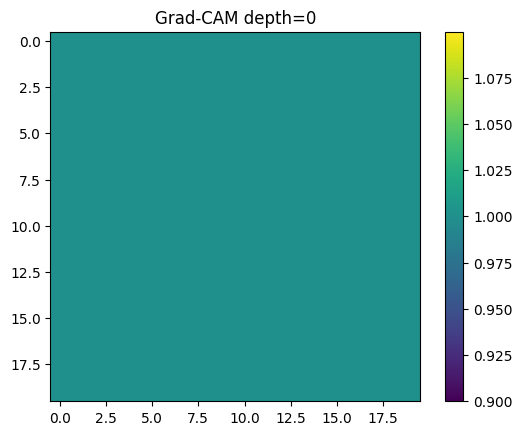

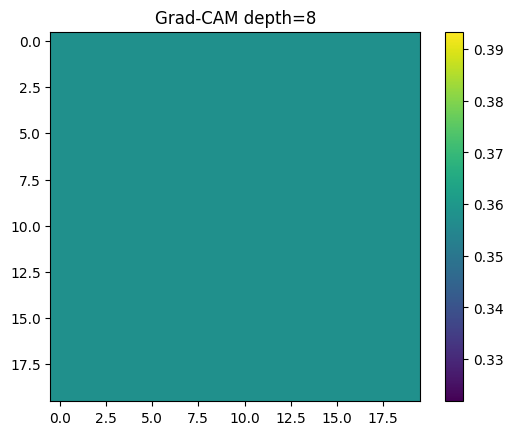

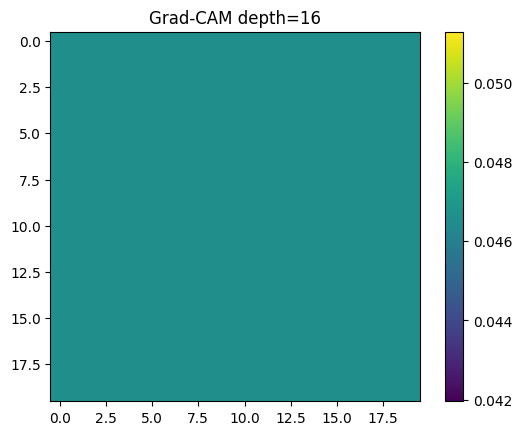

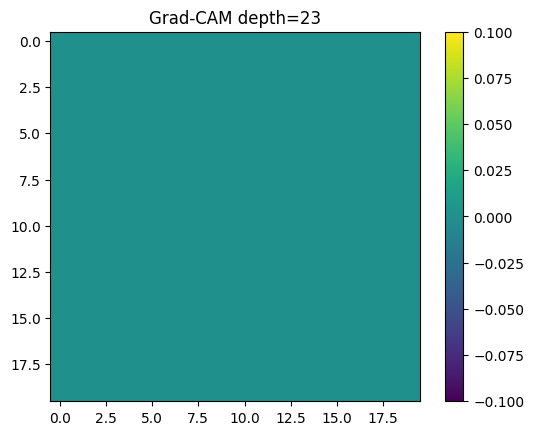

<Figure size 500x400 with 0 Axes>

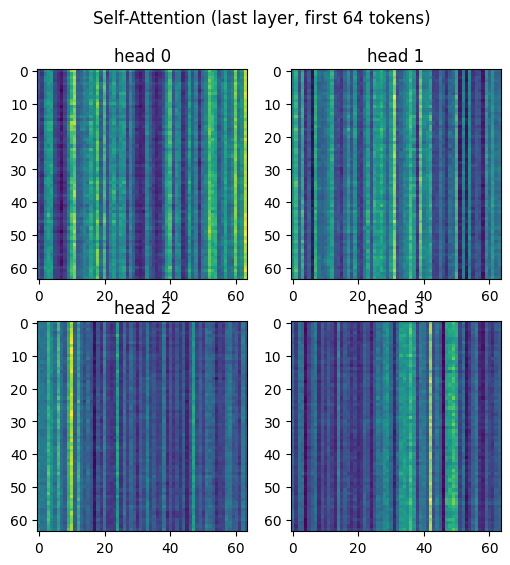

Self-Attn matrix shape: (1, 4, 365, 365)


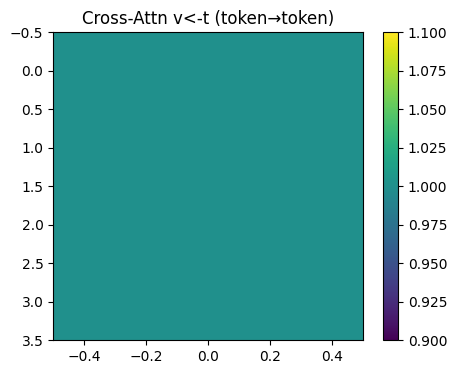

<Figure size 500x400 with 0 Axes>

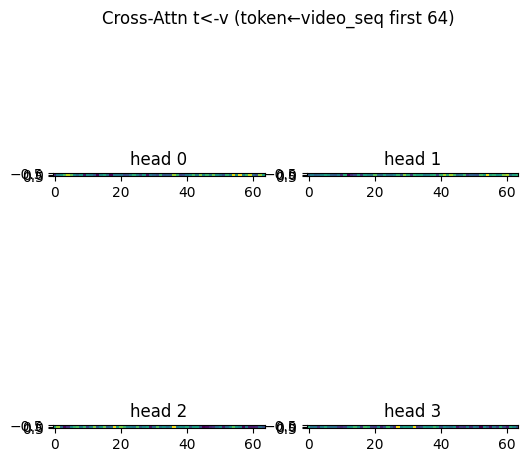

In [ ]:
# -*- coding: utf-8 -*-
import math, os
from typing import Optional, Tuple, List
import numpy as np
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.io import Dataset, DataLoader
import matplotlib.pyplot as plt

# ============ 基本设置 ============
os.makedirs("viz_out", exist_ok=True)

# ============ 工具：正弦位置编码 ============
class SinusoidalPositionalEncoding(nn.Layer):
    def __init__(self, d_model: int, max_len: int = 4096):
        super().__init__()
        pe = np.zeros((max_len, d_model), dtype="float32")
        position = np.arange(0, max_len, dtype="float32")[:, None]
        div_term = np.exp(np.arange(0, d_model, 2, dtype="float32") * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.register_buffer("pe", paddle.to_tensor(pe), persistable=False)
    def forward(self, x):  # (B,T,D)
        T = x.shape[1]
        return x + self.pe[:T, :]

# ============ TabM（占位，可替换为你的实现） ============
class TabMFeatureExtractor(nn.Layer):
    def __init__(self, num_features: int, d_hidden: int = 512, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_features, d_hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden), nn.ReLU(),
        )
        self.d_hidden = d_hidden
    def forward(self, x_num: paddle.Tensor):
        return self.net(x_num)

# ============ 3D ResNet18 ============
class BasicBlock3D(nn.Layer):
    expansion = 1
    def __init__(self, in_planes, planes, stride=(1,1,1), downsample=None):
        super().__init__()
        self.conv1 = nn.Conv3D(in_planes, planes, 3, stride=stride, padding=1, bias_attr=False)
        self.bn1   = nn.BatchNorm3D(planes)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv3D(planes, planes, 3, stride=1, padding=1, bias_attr=False)
        self.bn2   = nn.BatchNorm3D(planes)
        self.downsample = downsample
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.relu(out + identity)
        return out

class ResNet3D(nn.Layer):
    def __init__(self, block, layers, in_channels=20, base_width=64):
        super().__init__()
        self.in_planes = base_width
        self.conv1 = nn.Conv3D(in_channels, self.in_planes, kernel_size=(3,7,7),
                               stride=(1,2,2), padding=(1,3,3), bias_attr=False)
        self.bn1   = nn.BatchNorm3D(self.in_planes)
        self.relu  = nn.ReLU()
        self.maxpool = nn.MaxPool3D(kernel_size=(1,3,3), stride=(1,2,2), padding=(0,1,1))
        self.layer1 = self._make_layer(block, base_width,  layers[0], stride=(1,1,1))
        self.layer2 = self._make_layer(block, base_width*2, layers[1], stride=(2,2,2))
        self.layer3 = self._make_layer(block, base_width*4, layers[2], stride=(2,2,2))
        self.layer4 = self._make_layer(block, base_width*8, layers[3], stride=(2,2,2))
        self.out_dim = base_width*8  # 512
        self.pool = nn.AdaptiveAvgPool3D(output_size=1)
    def _make_layer(self, block, planes, blocks, stride=(1,1,1)):
        downsample = None
        if stride != (1,1,1) or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3D(self.in_planes, planes * block.expansion, 1, stride=stride, bias_attr=False),
                nn.BatchNorm3D(planes * block.expansion),
            )
        layers = [block(self.in_planes, planes, stride=stride, downsample=downsample)]
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)
    def forward(self, x):  # (B, C, D, H, W)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.pool(x)           # (B, 512, 1,1,1)
        x = paddle.flatten(x, 1)   # (B, 512)
        return x

class Volume3DEncoder(nn.Layer):
    """
    附带特征/梯度捕获，用于 3D Grad-CAM：
    - forward_post_hook 里：先缓存 feat
    - 若 out 可梯度，则注册 backward hook；否则跳过（避免 stop_gradient 报错）
    """
    def __init__(self, in_channels: int = 20, base: int = 64, dropout: float = 0.0):
        super().__init__()
        self.backbone = ResNet3D(BasicBlock3D, [2,2,2,2], in_channels=in_channels, base_width=base)
        self.drop = nn.Dropout(dropout)
        self.out_dim = self.backbone.out_dim  # 512
        self._feat = None
        self._grad = None

        def _save_feat_grad(layer, inp, out):
            self._feat = out  # (B, 512, D',H',W')
            if getattr(out, "stop_gradient", False):
                return
            def _save_grad(grad):
                self._grad = grad
            out.register_hook(_save_grad)

        self.backbone.layer4.register_forward_post_hook(_save_feat_grad)

    def forward(self, x):  # (B, C, D, H, W)
        x = self.backbone(x)
        x = self.drop(x)
        return x

# ============ MoE ============
class ExpertFFN(nn.Layer):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        return self.fc2(self.drop(F.relu(self.fc1(x))))

class MoEConfig:
    def __init__(self, n_experts=8, top_k=1, d_ff=2048, dropout=0.1,
                 router_temp=0.5, use_gumbel=False):
        self.n_experts=n_experts; self.top_k=top_k; self.d_ff=d_ff; self.dropout=dropout
        self.router_temp=router_temp; self.use_gumbel=use_gumbel

class MoE(nn.Layer):
    """缓存最近一次路由概率/索引，便于可解释与聚类"""
    def __init__(self, d_model: int, cfg: MoEConfig):
        super().__init__()
        self.cfg = cfg
        self.router = nn.Linear(d_model, cfg.n_experts)
        self.experts = nn.LayerList([ExpertFFN(d_model, cfg.d_ff, cfg.dropout) for _ in range(cfg.n_experts)])
        self.ln = nn.LayerNorm(d_model); self.drop = nn.Dropout(cfg.dropout)
        self.last_router_probs = None
        self.last_topk_idx = None
    def _router_probs(self, logits):
        if self.cfg.use_gumbel and self.training:
            u = paddle.uniform(logits.shape, min=1e-6, max=1-1e-6, dtype=logits.dtype)
            g = -paddle.log(-paddle.log(u)); logits = logits + g
        return F.softmax(logits / self.cfg.router_temp, axis=-1)
    def forward(self, x):
        orig_shape = x.shape
        if len(orig_shape) == 3: B,T,D = orig_shape; X = x.reshape([B*T, D])
        else: X = x
        N,D = X.shape
        logits = self.router(X); probs = self._router_probs(logits)
        topk_val, topk_idx = paddle.topk(probs, k=self.cfg.top_k, axis=-1)
        all_out = paddle.stack([e(X) for e in self.experts], axis=1)  # (N,E,D)
        arangeN = paddle.arange(N, dtype='int64')
        picked_list=[]
        for i in range(self.cfg.top_k):
            idx_i = topk_idx[:, i].astype('int64')
            idx_nd = paddle.stack([arangeN, idx_i], axis=1)
            picked_i = paddle.gather_nd(all_out, idx_nd)
            picked_list.append(picked_i)
        picked = paddle.stack(picked_list, axis=1)        # (N,k,D)
        w = topk_val / (paddle.sum(topk_val, axis=-1, keepdim=True) + 1e-9)
        Y = paddle.sum(picked * w.unsqueeze(-1), axis=1)  # (N,D)
        Y = self.drop(Y); Y = self.ln(Y + X)
        self.last_router_probs = probs.detach()
        self.last_topk_idx = topk_idx.detach()
        if len(orig_shape)==3: Y = Y.reshape([B,T,D])
        return Y

class MoEHead(nn.Layer):
    def __init__(self, d_model=512, cfg: MoEConfig = None):
        super().__init__()
        self.moe = MoE(d_model, cfg or MoEConfig())
        self.last_router_probs = None
        self.last_topk_idx = None
    def forward(self, tok):
        y = self.moe(tok.unsqueeze(1)).squeeze(1)
        self.last_router_probs = self.moe.last_router_probs
        self.last_topk_idx = self.moe.last_topk_idx
        return y

# ============ 原生 MHA + 手工回算注意力 ============
class _NativeMHAWithAttn(nn.Layer):
    """
    包装 nn.MultiHeadAttention：
      - 正式输出用原生 MHA (性能/数值一致)
      - 注意力矩阵用相同权重手工回算（兼容旧版不返回 attn 的情况）
    """
    def __init__(self, d_model: int, nhead: int, dropout: float = 0.1):
        super().__init__()
        self.mha = nn.MultiHeadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout)
        self.nhead = nhead
        assert d_model % nhead == 0
        self.d_head = d_model // nhead
        self.last_attn = None  # (B, H, T, T)

    def forward(self, x_tb: paddle.Tensor) -> paddle.Tensor:
        """
        x_tb: (T,B,D)
        return: (T,B,D)
        """
        # 1) 原生前向（不同版本的返回值差异：此处统一只拿输出）
        out_tb = self.mha(x_tb, x_tb, x_tb)

        # 2) 手工回算注意力：用同一组投影权重
        q = self.mha.q_proj(x_tb)  # (T,B,D)
        k = self.mha.k_proj(x_tb)
        v = self.mha.v_proj(x_tb)
        T, B, D = q.shape
        H, Dh = self.nhead, self.d_head

        def split(tb):  # (T,B,D)->(B,H,T,Dh)
            tb = tb.transpose([1, 0, 2])               # (B,T,D)
            return tb.reshape([B, T, H, Dh]).transpose([0, 2, 1, 3])

        qh, kh, vh = split(q), split(k), split(v)       # (B,H,T,Dh)
        scores = paddle.matmul(qh, kh, transpose_y=True) / math.sqrt(Dh)  # (B,H,T,T)
        attn = F.softmax(scores, axis=-1)
        self.last_attn = attn.detach()

        return out_tb  # (T,B,D)

# ============ Self-Attention Transformer（记录注意力） ============
class TransformerEncoderLayerMoE(nn.Layer):
    def __init__(self, d_model=512, nhead=8, d_ff=1024, dropout=0.1,
                 use_moe: bool = True, moe_cfg: MoEConfig = None, capture_attn: bool = True):
        super().__init__()
        self.use_moe = use_moe; self.capture_attn = capture_attn
        self.self_attn = _NativeMHAWithAttn(d_model, nhead, dropout)
        self.ln1 = nn.LayerNorm(d_model); self.do1 = nn.Dropout(dropout)
        if use_moe:
            self.moe = MoE(d_model, moe_cfg or MoEConfig(d_ff=d_ff, dropout=dropout))
        else:
            self.ffn = nn.Sequential(nn.LayerNorm(d_model),
                                     nn.Linear(d_model, d_ff), nn.ReLU(), nn.Dropout(dropout),
                                     nn.Linear(d_ff, d_model))
            self.do2 = nn.Dropout(dropout)
        self.last_attn = None  # (B,H,T,T)
    def forward(self, x):  # (B,T,D)
        h = self.ln1(x)
        h_tb = paddle.transpose(h, [1,0,2])   # (T,B,D)
        out_tb = self.self_attn(h_tb)         # (T,B,D)
        if self.capture_attn:
            self.last_attn = self.self_attn.last_attn
        out = paddle.transpose(out_tb, [1,0,2])  # (B,T,D)
        x = x + self.do1(out)
        if self.use_moe:
            x = self.moe(x)
        else:
            x = x + self.do2(self.ffn(x))
        return x

class TemporalTransformerFlexible(nn.Layer):
    def __init__(self, d_model=512, nhead=4, num_layers=2, d_ff=1024, dropout=0.1,
                 max_len=4096, use_moe: bool = True, moe_cfg: MoEConfig = None, capture_attn=True):
        super().__init__()
        self.pos = SinusoidalPositionalEncoding(d_model, max_len=max_len)
        self.layers = nn.LayerList([
            TransformerEncoderLayerMoE(d_model, nhead, d_ff, dropout,
                                       use_moe=use_moe, moe_cfg=moe_cfg, capture_attn=capture_attn)
            for _ in range(num_layers)
        ])
        self.last_attn_all_layers: List[paddle.Tensor] = []
    def forward(self, x):
        x = self.pos(x)
        self.last_attn_all_layers = []
        for layer in self.layers:
            x = layer(x)
            if layer.last_attn is not None:
                self.last_attn_all_layers.append(layer.last_attn)  # (B,H,T,T)
        return x

# ============ AFNO(1D) + MoE FFN ============
class AFNO1DLayer(nn.Layer):
    def __init__(self, d_model: int, modes: int = 32, num_blocks: int = 8, shrink: float = 0.01, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_blocks == 0
        self.d_model=d_model; self.modes=modes; self.num_blocks=num_blocks; self.block=d_model//num_blocks
        scale=1.0/math.sqrt(self.block); init = nn.initializer.Uniform(-scale, scale)
        self.w1r = self.create_parameter([num_blocks, self.block, self.block], default_initializer=init)
        self.w1i = self.create_parameter([num_blocks, self.block, self.block], default_initializer=init)
        self.w2r = self.create_parameter([num_blocks, self.block, self.block], default_initializer=init)
        self.w2i = self.create_parameter([num_blocks, self.block, self.block], default_initializer=init)
        self.ln = nn.LayerNorm(d_model); self.drop = nn.Dropout(dropout); self.shrink = shrink
    def _cl(self, xr, xi, Wr, Wi):
        out_r = paddle.matmul(xr, Wr) - paddle.matmul(xi, Wi)
        out_i = paddle.matmul(xr, Wi) + paddle.matmul(xi, Wr)
        return out_r, out_i
    def forward(self, x):  # (B,T,D)
        B,T,D = x.shape; Kmax=T//2+1; K=min(self.modes, Kmax)
        h=self.ln(x); h_td=h.transpose([0,2,1]); h_ft=paddle.fft.rfft(h_td)  # (B,D,F)
        h_ft=h_ft.reshape([B, self.num_blocks, self.block, Kmax])
        xk=h_ft[:,:,:, :K].transpose([0,1,3,2]) # (B,G,K,Cb)
        xr, xi = paddle.real(xk), paddle.imag(xk)
        yr, yi = self._cl(xr, xi, self.w1r, self.w1i)
        yr = F.gelu(yr); yi = F.gelu(yi)
        yr = F.softshrink(yr, threshold=self.shrink); yi = F.softshrink(yi, threshold=self.shrink)
        yr, yi = self._cl(yr, yi, self.w2r, self.w2i)
        yk = paddle.complex(yr, yi).transpose([0,1,3,2]).reshape([B,D,K])
        out_ft = paddle.zeros([B,D,Kmax], dtype='complex64')
        out_ft[:,:, :K] = yk
        out_td = paddle.fft.irfft(out_ft, n=T)
        out = out_td.transpose([0,2,1])
        out = self.drop(out)
        return x + out

class AFNOTransformerFlexible(nn.Layer):
    def __init__(self, d_model=512, num_layers=2, modes=32, dropout=0.1,
                 d_ff=1024, use_moe: bool = True, moe_cfg: MoEConfig = None):
        super().__init__()
        self.layers = nn.LayerList([AFNO1DLayer(d_model, modes, 8, 0.01, dropout) for _ in range(num_layers)])
        self.use_moe = use_moe
        if use_moe:
            self.moe = MoE(d_model, moe_cfg or MoEConfig(d_ff=d_ff, dropout=dropout))
        else:
            self.ffn = nn.Sequential(nn.LayerNorm(d_model),
                                     nn.Linear(d_model, d_ff), nn.ReLU(), nn.Dropout(dropout),
                                     nn.Linear(d_ff, d_model))
            self.do = nn.Dropout(dropout)
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        if self.use_moe:
            x = self.moe(x)
        else:
            x = x + self.do(self.ffn(x))
        return x

# ============ Cross-Attention（记录注意力） ============
class MultiHeadCrossAttention(nn.Layer):
    def __init__(self, d_model: int, nhead: int = 8, dropout: float = 0.1):
        super().__init__()
        assert d_model % nhead == 0
        self.d_head = d_model // nhead; self.nhead = nhead
        self.Wq = nn.Linear(d_model, d_model); self.Wk = nn.Linear(d_model, d_model); self.Wv = nn.Linear(d_model, d_model)
        self.proj = nn.Linear(d_model, d_model); self.drop = nn.Dropout(dropout); self.ln = nn.LayerNorm(d_model)
        self.last_attn = None  # (B, H, Nq, Nk)
    def forward(self, q, kv):
        B, Nq, D = q.shape; Nk = kv.shape[1]
        def split(t): return t.reshape([B, -1, self.nhead, self.d_head]).transpose([0,2,1,3])
        qh = split(self.Wq(q)); kh = split(self.Wk(kv)); vh = split(self.Wv(kv))
        scores = paddle.matmul(qh, kh, transpose_y=True) / math.sqrt(self.d_head)  # (B,H,Nq,Nk)
        attn = F.softmax(scores, axis=-1)
        self.last_attn = attn.detach()
        ctx = paddle.matmul(attn, vh).transpose([0,2,1,3]).reshape([B,Nq,D])
        out = self.drop(self.proj(ctx))
        return self.ln(out + q)

class BiModalCrossFusion(nn.Layer):
    def __init__(self, d_model=512, nhead=8, dropout=0.1, fuse_hidden=512):
        super().__init__()
        self.ca_v_from_t = MultiHeadCrossAttention(d_model, nhead, dropout)
        self.ca_t_from_v = MultiHeadCrossAttention(d_model, nhead, dropout)
        self.fuse = nn.Sequential(nn.Linear(2*d_model, fuse_hidden), nn.ReLU(), nn.Dropout(dropout))
        self.out_dim = fuse_hidden
        self.last_attn_v_from_t = None  # (B,H,1,1)
        self.last_attn_t_from_v = None  # (B,H,1,T)
    def forward(self, video_seq, tabm_tok):
        v_tok = video_seq.mean(axis=1, keepdim=True)  # (B,1,D)
        t_tok = tabm_tok.unsqueeze(1)                 # (B,1,D)
        v_upd = self.ca_v_from_t(v_tok, t_tok)
        t_upd = self.ca_t_from_v(t_tok, video_seq)
        self.last_attn_v_from_t = self.ca_v_from_t.last_attn
        self.last_attn_t_from_v = self.ca_t_from_v.last_attn
        fused = paddle.concat([v_upd, t_upd], axis=-1).squeeze(1)
        return self.fuse(fused)

# ============ 总模型 ============
class TwoModalMultiLabelModel(nn.Layer):
    def __init__(self, vid_channels=20, vid_frames=365, depth_n=24,
                 vec_dim=424, d_model=512, nhead=4, n_trans_layers=2, trans_ff=1024,
                 tabm_hidden=512, dropout=0.1, num_labels=4,
                 moe_temporal_attn=True, moe_temporal_afno=True, moe_fused=False, moe_tabm=False,
                 afno_modes=32):
        super().__init__()
        self.vol_encoder = Volume3DEncoder(in_channels=vid_channels, dropout=dropout)
        self.trans_attn = TemporalTransformerFlexible(
            d_model=d_model, nhead=nhead, num_layers=n_trans_layers, d_ff=trans_ff, dropout=dropout,
            max_len=vid_frames, use_moe=moe_temporal_attn, moe_cfg=MoEConfig(d_ff=max(2048,trans_ff), n_experts=8),
            capture_attn=True
        )
        self.trans_afno = AFNOTransformerFlexible(
            d_model=d_model, num_layers=n_trans_layers, modes=afno_modes, dropout=dropout,
            d_ff=trans_ff, use_moe=moe_temporal_afno, moe_cfg=MoEConfig(d_ff=max(2048,trans_ff), n_experts=8)
        )
        self.video_merge = nn.Linear(2*d_model, d_model)
        self.tabm = TabMFeatureExtractor(vec_dim, d_hidden=tabm_hidden, dropout=dropout)
        self.tabm_proj = nn.Linear(tabm_hidden, d_model)
        self.moe_tabm = moe_tabm
        if moe_tabm:
            self.tabm_moe = MoEHead(d_model=d_model, cfg=MoEConfig(d_ff=1024, n_experts=6))
        self.fusion = BiModalCrossFusion(d_model=d_model, nhead=nhead, dropout=dropout, fuse_hidden=d_model)
        self.moe_fused = moe_fused
        if moe_fused:
            self.fused_moe = MoEHead(d_model=d_model, cfg=MoEConfig(d_ff=1024, n_experts=6))
        self.head = nn.Linear(self.fusion.out_dim, num_labels)
        self.depth_n = depth_n
    def encode(self, x_video, x_vec):
        B,T,C,H,W,N = x_video.shape
        assert N == self.depth_n
        xvt = x_video.transpose([0,1,2,5,3,4]).reshape([B*T, C, N, H, W])
        f_frame = self.vol_encoder(xvt)               # (B*T,512)
        seq = f_frame.reshape([B, T, -1])             # (B,T,512)
        z_attn = self.trans_attn(seq)
        z_afno = self.trans_afno(seq)
        z_vid  = self.video_merge(paddle.concat([z_attn, z_afno], axis=-1))
        z_tabm = self.tabm(x_vec); z_tabm = self.tabm_proj(z_tabm)
        if self.moe_tabm:
            z_tabm = self.tabm_moe(z_tabm)
        fused = self.fusion(z_vid, z_tabm)
        if self.moe_fused:
            fused = self.fused_moe(fused)
        return fused
    def forward(self, x_video, x_vec):
        fused = self.encode(x_video, x_vec)
        logits = self.head(fused)
        return logits

# ============ 3D Grad-CAM ============
class GradCAM3D:
    """
    CAM = ReLU( sum_c( w_c * A_c ) ), w_c = GAP(grad_c)
    输出 (N,H,W)，若无 scipy 则返回特征尺度 (D',H',W')
    """
    def __init__(self, model: TwoModalMultiLabelModel):
        self.model = model
    @paddle.no_grad()
    def _trilinear_upsample(self, vol, out_shape):
        try:
            from scipy.ndimage import zoom
            Dz = out_shape[0] / vol.shape[0]
            Dy = out_shape[1] / vol.shape[1]
            Dx = out_shape[2] / vol.shape[2]
            return zoom(vol, (Dz, Dy, Dx), order=1)
        except Exception:
            return vol
    def generate(self, x_video, x_vec, target_class: int = 0, time_index: int = 0):
        assert x_video.shape[0] == 1, "Grad-CAM 演示请用单样本 B=1"
        self.model.eval()
        B,T,C,H,W,N = x_video.shape
        self.model.clear_gradients()
        logits = self.model(x_video.astype('float32'), x_vec.astype('float32'))  # (1,num_labels)
        cls = logits[0, target_class]
        cls.backward()
        feat = self.model.vol_encoder._feat      # (1,512,D',H',W')
        grad = self.model.vol_encoder._grad
        assert (feat is not None) and (grad is not None), "未捕获到特征/梯度（检查 hook & 是否有梯度前向）"
        feat_np = feat.numpy()[0]; grad_np = grad.numpy()[0]
        w = grad_np.mean(axis=(1,2,3))           # (512,)
        cam = np.maximum(0, np.tensordot(w, feat_np, axes=(0,0)))  # (D',H',W')
        cam = cam - cam.min(); cam = cam / (cam.max() + 1e-8)
        cam_up = self._trilinear_upsample(cam, (N, H, W))
        return cam_up  # (N,H,W) or (D',H',W')

# ============ MoE 路由聚类工具 ============
def kmeans_numpy(X: np.ndarray, K: int = 4, iters: int = 50, seed: int = 0):
    rng = np.random.default_rng(seed)
    N,D = X.shape
    cent = X[rng.choice(N, K, replace=False)]
    for _ in range(iters):
        dist2 = ((X[:,None,:]-cent[None,:,:])**2).sum(axis=2)  # (N,K)
        idx = dist2.argmin(axis=1)
        new_cent = np.stack([X[idx==k].mean(axis=0) if np.any(idx==k) else cent[k] for k in range(K)], 0)
        if np.allclose(new_cent, cent): break
        cent = new_cent
    return idx, cent

def collect_moe_routing_vectors(model: TwoModalMultiLabelModel, loader: DataLoader,
                                branch: str = "temporal_attn", topk_hist: bool = True):
    model.eval()
    vecs = []
    for x_vid, x_vec, y in loader:
        _ = model(x_vid.astype('float32'), x_vec.astype('float32'))
        if branch == "temporal_attn":
            moe = None
            for lyr in model.trans_attn.layers[::-1]:
                if hasattr(lyr, "moe"):
                    moe = lyr.moe; break
        elif branch == "temporal_afno":
            moe = model.trans_afno.moe if hasattr(model.trans_afno, "moe") else None
        elif branch == "tabm":
            moe = model.tabm_moe.moe if getattr(model, "moe_tabm", False) else None
        else:
            moe = model.fused_moe.moe if getattr(model, "moe_fused", False) else None
        if moe is None or moe.last_router_probs is None:
            continue
        probs = moe.last_router_probs.numpy()          # (N_tokens, E)
        if topk_hist:
            top1 = moe.last_topk_idx.numpy()[:,0]      # (N_tokens,)
            E = probs.shape[1]
            hist = np.bincount(top1, minlength=E).astype("float32")
            hist = hist / (hist.sum() + 1e-9)
            vecs.append(hist)
        else:
            vecs.append(probs.mean(axis=0))
    return np.stack(vecs, 0) if len(vecs)>0 else None

# ============ Toy 数据集 ============
class ToyTwoModalDataset(Dataset):
    """
    返回：
      x_video: (T=365, C=20, H=20, W=20, N=24)
      x_vec:   (424,)
      y:       (4,)  0/1
    """
    def __init__(self, n: int, seed: int = 0, T: int = 365, C: int = 20, H: int = 20, W: int = 20, N: int = 24):
        super().__init__()
        rng = np.random.default_rng(seed)
        self.video = rng.normal(size=(n, T, C, H, W, N)).astype('float32')
        self.vec   = rng.normal(size=(n, 424)).astype('float32')
        # 造标签：体素均值 → (n,C) → 线性到 4 类
        vid_hwn = self.video.mean(axis=(3,4,5))   # (n,T,C)
        vid_avg = vid_hwn.mean(axis=1)            # (n,C)
        Wv = rng.normal(size=(C,4)); Wt = rng.normal(size=(424,4))
        logits = vid_avg @ Wv + self.vec @ Wt + rng.normal(scale=0.5, size=(n,4))
        probs  = 1.0 / (1.0 + np.exp(-logits))
        self.y = (probs > 0.5).astype('float32')
    def __getitem__(self, idx: int):
        return self.video[idx], self.vec[idx], self.y[idx]
    def __len__(self): return len(self.y)

# ============ 小工具：绘图 ============
def show_heatmap_2d(arr2d: np.ndarray, title: str, save_path: Optional[str] = None):
    plt.figure(); plt.imshow(arr2d, interpolation='nearest'); plt.title(title); plt.colorbar()
    if save_path: plt.savefig(save_path, bbox_inches='tight');
    plt.show(); plt.close()

def show_attention_matrix(attn: np.ndarray, title: str, save_path: Optional[str] = None):
    # attn: (B,H,T,T) 或 (B,H,1,T) 或 (B,H,1,1)
    if attn.ndim == 4 and attn.shape[2] == 1 and attn.shape[3] == 1:
        attn = attn[0,:,0,0][:,None]  # (H,1)
    elif attn.ndim == 4 and attn.shape[2] == 1:
        attn = attn[0]  # (H,1,T)
    elif attn.ndim == 4:
        attn = attn[0]  # (H,T,T)
    plt.figure(figsize=(5,4))
    if attn.ndim == 2:  # (H,1)
        plt.imshow(attn, aspect='auto', interpolation='nearest')
    elif attn.ndim == 3:  # 多头
        H = attn.shape[0]
        cols = int(np.ceil(np.sqrt(H))); rows = int(np.ceil(H/cols))
        fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
        axes = axes.flatten()
        for h in range(H):
            axes[h].imshow(attn[h], interpolation='nearest'); axes[h].set_title(f"head {h}")
        for k in range(H, len(axes)): axes[k].axis('off')
        fig.suptitle(title)
        if save_path: fig.savefig(save_path, bbox_inches='tight')
        plt.show(); plt.close(fig); return
    plt.title(title); plt.colorbar()
    if save_path: plt.savefig(save_path, bbox_inches='tight')
    plt.show(); plt.close()

# ============ Demo：可解释可视化 ============
if __name__ == "__main__":
    # 1) 构造“已训练好”的模型（这里随机权重示意）
    model = TwoModalMultiLabelModel(
        vid_channels=20, vid_frames=365, depth_n=24,
        vec_dim=424, d_model=512, nhead=4, n_trans_layers=2, trans_ff=512,
        tabm_hidden=256, dropout=0.1, num_labels=4,
        moe_temporal_attn=True, moe_temporal_afno=True,
        moe_fused=False, moe_tabm=False, afno_modes=32
    )
    model.eval()

    # 2) 取一个样本
    toy = ToyTwoModalDataset(n=8, seed=123, T=365, C=20, H=20, W=20, N=24)
    x_video, x_vec, y = toy[0]
    x_video = paddle.to_tensor(x_video[None, ...])  # (1,T,C,H,W,N)
    x_vec   = paddle.to_tensor(x_vec[None, ...])    # (1,424)

    # 3) 3D Grad-CAM：一次“有梯度”的前向 + 反传
    model.clear_gradients()
    logits = model(x_video.astype('float32'), x_vec.astype('float32'))
    target_class = int(paddle.argmax(logits, axis=-1)[0])
    cam3d = GradCAM3D(model).generate(
        x_video.astype('float32'), x_vec.astype('float32'),
        target_class=target_class, time_index=0
    )  # (N,H,W) or (D',H',W')

    # 展示几个深度切片
    Nz = cam3d.shape[0]
    for z in [0, Nz//3, 2*Nz//3, Nz-1]:
        show_heatmap_2d(cam3d[z], f"Grad-CAM depth={z}", save_path=f"viz_out/gradcam_z{z}.png")

    # 4) Self-Attention & Cross-Attention 注意力矩阵
    with paddle.no_grad():
        _ = model.encode(x_video.astype('float32'), x_vec.astype('float32'))
    # Self-Attn（最后一层）
    last_attn_list = model.trans_attn.last_attn_all_layers
    if len(last_attn_list) > 0:
        attn = last_attn_list[-1].numpy()  # (B,H,T,T)
        attn_crop = attn[:, :, :64, :64]
        show_attention_matrix(attn_crop, "Self-Attention (last layer, first 64 tokens)",
                              save_path="viz_out/self_attn_lastlayer_64.png")
        print("Self-Attn matrix shape:", attn.shape)
    else:
        print("Self-Attn not captured.")
    # Cross-Attn
    if model.fusion.last_attn_v_from_t is not None:
        show_attention_matrix(model.fusion.last_attn_v_from_t.numpy(),
                              "Cross-Attn v<-t (token→token)",
                              save_path="viz_out/cross_attn_v_from_t.png")
    if model.fusion.last_attn_t_from_v is not None:
        attn_tv = model.fusion.last_attn_t_from_v.numpy()
        attn_tv_crop = attn_tv[:,:,:, :64]
        show_attention_matrix(attn_tv_crop,
                              "Cross-Attn t<-v (token←video_seq first 64)",
                              save_path="viz_out/cross_attn_t_from_v_64.png")

    # 5) MoE 路由聚类（示例用 toy 数据）
    def collate_fn(batch):
        vids, vecs, ys = zip(*batch)
        return (paddle.to_tensor(np.stack(vids, 0)),
                paddle.to_tensor(np.stack(vecs, 0)),
                paddle.to_tensor(np.stack(ys, 0)))
    train_loader = DataLoader(toy, batch_size=1, shuffle=False, collate_fn=collate_fn)
    moe_vecs = collect_moe_routing_vectors(model, train_loader, branch="temporal_attn", topk_hist=True)
    if moe_vecs is not None:
        idx, cent = kmeans_numpy(moe_vecs, K=4, iters=100, seed=0)
        print("\n[MoE Routing Clusters @ temporal_attn]")
        for k in range(4):
            sel = (idx==k)
            if np.any(sel):
                mean_vec = moe_vecs[sel].mean(axis=0)
                dom = int(mean_vec.argmax())
                print(f" - Cluster {k}: size={int(sel.sum())}, dominant_expert={dom}, mean_dist={np.round(mean_vec,3)}")
        # 保存热图
        plt.figure(figsize=(6,4))
        plt.imshow(moe_vecs, aspect='auto', interpolation='nearest')
        plt.title("Samples × Experts (routing histogram)"); plt.xlabel("Expert"); plt.ylabel("Sample")
        plt.colorbar(); plt.savefig("viz_out/moe_routing_heatmap.png", bbox_inches='tight')
        plt.show(); plt.close()
    else:
        print("MoE routing not available on selected branch.")


In [ ]:
# -*- coding: utf-8 -*-
import math, os
from typing import Optional, Tuple, List
import numpy as np
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.io import Dataset, DataLoader
import matplotlib.pyplot as plt

# ============ 基本设置 ============  # 如需 CPU 改为 'cpu'
os.makedirs("viz_out", exist_ok=True)

# ============ 工具：正弦位置编码 ============
class SinusoidalPositionalEncoding(nn.Layer):
    def __init__(self, d_model: int, max_len: int = 4096):
        super().__init__()
        pe = np.zeros((max_len, d_model), dtype="float32")
        position = np.arange(0, max_len, dtype="float32")[:, None]
        div_term = np.exp(np.arange(0, d_model, 2, dtype="float32") * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.register_buffer("pe", paddle.to_tensor(pe), persistable=False)
    def forward(self, x):  # (B,T,D)
        T = x.shape[1]
        return x + self.pe[:T, :]

# ============ TabM（占位，可替换为你的实现） ============
class TabMFeatureExtractor(nn.Layer):
    def __init__(self, num_features: int, d_hidden: int = 512, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_features, d_hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(d_hidden, d_hidden), nn.ReLU(),
        )
        self.d_hidden = d_hidden
    def forward(self, x_num: paddle.Tensor):
        return self.net(x_num)

# ============ 3D ResNet18 ============
class BasicBlock3D(nn.Layer):
    expansion = 1
    def __init__(self, in_planes, planes, stride=(1,1,1), downsample=None):
        super().__init__()
        self.conv1 = nn.Conv3D(in_planes, planes, 3, stride=stride, padding=1, bias_attr=False)
        self.bn1   = nn.BatchNorm3D(planes)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv3D(planes, planes, 3, stride=1, padding=1, bias_attr=False)
        self.bn2   = nn.BatchNorm3D(planes)
        self.downsample = downsample
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.relu(out + identity)
        return out

class ResNet3D(nn.Layer):
    def __init__(self, block, layers, in_channels=20, base_width=64):
        super().__init__()
        self.in_planes = base_width
        self.conv1 = nn.Conv3D(in_channels, self.in_planes, kernel_size=(3,7,7),
                               stride=(1,2,2), padding=(1,3,3), bias_attr=False)
        self.bn1   = nn.BatchNorm3D(self.in_planes)
        self.relu  = nn.ReLU()
        self.maxpool = nn.MaxPool3D(kernel_size=(1,3,3), stride=(1,2,2), padding=(0,1,1))
        self.layer1 = self._make_layer(block, base_width,  layers[0], stride=(1,1,1))
        self.layer2 = self._make_layer(block, base_width*2, layers[1], stride=(2,2,2))
        self.layer3 = self._make_layer(block, base_width*4, layers[2], stride=(2,2,2))
        self.layer4 = self._make_layer(block, base_width*8, layers[3], stride=(2,2,2))
        self.out_dim = base_width*8  # 512
        self.pool = nn.AdaptiveAvgPool3D(output_size=1)
    def _make_layer(self, block, planes, blocks, stride=(1,1,1)):
        downsample = None
        if stride != (1,1,1) or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3D(self.in_planes, planes * block.expansion, 1, stride=stride, bias_attr=False),
                nn.BatchNorm3D(planes * block.expansion),
            )
        layers = [block(self.in_planes, planes, stride=stride, downsample=downsample)]
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)
    def forward(self, x):  # (B, C, D, H, W)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.pool(x)           # (B, 512, 1,1,1)
        x = paddle.flatten(x, 1)   # (B, 512)
        return x

class Volume3DEncoder(nn.Layer):
    """
    带安全 hook（仅在可求梯度时注册 backward hook），支持 3D Grad-CAM
    """
    def __init__(self, in_channels: int = 20, base: int = 64, dropout: float = 0.0):
        super().__init__()
        self.backbone = ResNet3D(BasicBlock3D, [2,2,2,2], in_channels=in_channels, base_width=base)
        self.drop = nn.Dropout(dropout)
        self.out_dim = self.backbone.out_dim  # 512
        self._feat = None
        self._grad = None
        def _save_feat_grad(layer, inp, out):
            self._feat = out  # (B, 512, D',H',W')
            if getattr(out, "stop_gradient", False):
                return
            def _save_grad(grad):
                self._grad = grad
            out.register_hook(_save_grad)
        self.backbone.layer4.register_forward_post_hook(_save_feat_grad)
    def forward(self, x):  # (B, C, D, H, W)
        x = self.backbone(x)
        x = self.drop(x)
        return x

# ============ MoE ============
class ExpertFFN(nn.Layer):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        return self.fc2(self.drop(F.relu(self.fc1(x))))

class MoEConfig:
    def __init__(self, n_experts=8, top_k=1, d_ff=2048, dropout=0.1,
                 router_temp=0.5, use_gumbel=False):
        self.n_experts=n_experts; self.top_k=top_k; self.d_ff=d_ff; self.dropout=dropout
        self.router_temp=router_temp; self.use_gumbel=use_gumbel

class MoE(nn.Layer):
    """缓存最近一次路由概率/索引，便于可解释与聚类"""
    def __init__(self, d_model: int, cfg: MoEConfig):
        super().__init__()
        self.cfg = cfg
        self.router = nn.Linear(d_model, cfg.n_experts)
        self.experts = nn.LayerList([ExpertFFN(d_model, cfg.d_ff, cfg.dropout) for _ in range(cfg.n_experts)])
        self.ln = nn.LayerNorm(d_model); self.drop = nn.Dropout(cfg.dropout)
        self.last_router_probs = None
        self.last_topk_idx = None
    def _router_probs(self, logits):
        if self.cfg.use_gumbel and self.training:
            u = paddle.uniform(logits.shape, min=1e-6, max=1-1e-6, dtype=logits.dtype)
            g = -paddle.log(-paddle.log(u)); logits = logits + g
        return F.softmax(logits / self.cfg.router_temp, axis=-1)
    def forward(self, x):
        orig_shape = x.shape
        if len(orig_shape) == 3: B,T,D = orig_shape; X = x.reshape([B*T, D])
        else: X = x
        N,D = X.shape
        logits = self.router(X); probs = self._router_probs(logits)
        topk_val, topk_idx = paddle.topk(probs, k=self.cfg.top_k, axis=-1)
        all_out = paddle.stack([e(X) for e in self.experts], axis=1)  # (N,E,D)
        arangeN = paddle.arange(N, dtype='int64')
        picked_list=[]
        for i in range(self.cfg.top_k):
            idx_i = topk_idx[:, i].astype('int64')
            idx_nd = paddle.stack([arangeN, idx_i], axis=1)
            picked_i = paddle.gather_nd(all_out, idx_nd)
            picked_list.append(picked_i)
        picked = paddle.stack(picked_list, axis=1)        # (N,k,D)
        w = topk_val / (paddle.sum(topk_val, axis=-1, keepdim=True) + 1e-9)
        Y = paddle.sum(picked * w.unsqueeze(-1), axis=1)  # (N,D)
        Y = self.drop(Y); Y = self.ln(Y + X)
        self.last_router_probs = probs.detach()
        self.last_topk_idx = topk_idx.detach()
        if len(orig_shape)==3: Y = Y.reshape([B,T,D])
        return Y

class MoEHead(nn.Layer):
    def __init__(self, d_model=512, cfg: MoEConfig = None):
        super().__init__()
        self.moe = MoE(d_model, cfg or MoEConfig())
        self.last_router_probs = None
        self.last_topk_idx = None
    def forward(self, tok):
        y = self.moe(tok.unsqueeze(1)).squeeze(1)
        self.last_router_probs = self.moe.last_router_probs
        self.last_topk_idx = self.moe.last_topk_idx
        return y

# ============ 自实现版 Multi-Head Self-Attention（记录注意力） ============
class MultiHeadSelfAttention(nn.Layer):
    def __init__(self, d_model: int, nhead: int = 8, dropout: float = 0.1):
        super().__init__()
        assert d_model % nhead == 0
        self.d_model = d_model
        self.nhead = nhead
        self.d_head = d_model // nhead
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)
        self.last_attn = None  # (B,H,T,T)

    def forward(self, x):  # x: (B,T,D)
        B,T,D = x.shape
        q = self.Wq(x); k = self.Wk(x); v = self.Wv(x)
        def split(t): return t.reshape([B, T, self.nhead, self.d_head]).transpose([0,2,1,3])  # (B,H,T,dh)
        qh, kh, vh = split(q), split(k), split(v)
        scores = paddle.matmul(qh, kh, transpose_y=True) / math.sqrt(self.d_head)  # (B,H,T,T)
        attn = F.softmax(scores, axis=-1)
        self.last_attn = attn.detach()
        ctx = paddle.matmul(attn, vh)  # (B,H,T,dh)
        ctx = ctx.transpose([0,2,1,3]).reshape([B, T, D])  # (B,T,D)
        out = self.drop(self.proj(ctx))
        return out  # 残差与LN在外面做

# ============ Self-Attention Transformer（用自实现 MHA） ============
class TransformerEncoderLayerMoE(nn.Layer):
    def __init__(self, d_model=512, nhead=8, d_ff=1024, dropout=0.1,
                 use_moe: bool = True, moe_cfg: MoEConfig = None, capture_attn: bool = True):
        super().__init__()
        self.use_moe = use_moe; self.capture_attn = capture_attn
        self.self_attn = MultiHeadSelfAttention(d_model, nhead, dropout)
        self.ln1 = nn.LayerNorm(d_model); self.do1 = nn.Dropout(dropout)
        if use_moe:
            self.moe = MoE(d_model, moe_cfg or MoEConfig(d_ff=d_ff, dropout=dropout))
        else:
            self.ffn = nn.Sequential(nn.LayerNorm(d_model),
                                     nn.Linear(d_model, d_ff), nn.ReLU(), nn.Dropout(dropout),
                                     nn.Linear(d_ff, d_model))
            self.do2 = nn.Dropout(dropout)
        self.last_attn = None  # (B,H,T,T)
    def forward(self, x):  # (B,T,D)
        h = self.ln1(x)
        out = self.self_attn(h)                    # (B,T,D)
        if self.capture_attn:
            self.last_attn = self.self_attn.last_attn  # (B,H,T,T)
        x = x + self.do1(out)
        if self.use_moe:
            x = self.moe(x)
        else:
            x = x + self.do2(self.ffn(x))
        return x

class TemporalTransformerFlexible(nn.Layer):
    def __init__(self, d_model=512, nhead=4, num_layers=2, d_ff=1024, dropout=0.1,
                 max_len=4096, use_moe: bool = True, moe_cfg: MoEConfig = None, capture_attn=True):
        super().__init__()
        self.pos = SinusoidalPositionalEncoding(d_model, max_len=max_len)
        self.layers = nn.LayerList([
            TransformerEncoderLayerMoE(d_model, nhead, d_ff, dropout,
                                       use_moe=use_moe, moe_cfg=moe_cfg, capture_attn=capture_attn)
            for _ in range(num_layers)
        ])
        self.last_attn_all_layers: List[paddle.Tensor] = []
    def forward(self, x):
        x = self.pos(x)
        self.last_attn_all_layers = []
        for layer in self.layers:
            x = layer(x)
            if layer.last_attn is not None:
                self.last_attn_all_layers.append(layer.last_attn)  # (B,H,T,T)
        return x

# ============ AFNO(1D) + MoE FFN ============
class AFNO1DLayer(nn.Layer):
    def __init__(self, d_model: int, modes: int = 32, num_blocks: int = 8, shrink: float = 0.01, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_blocks == 0
        self.d_model=d_model; self.modes=modes; self.num_blocks=num_blocks; self.block=d_model//num_blocks
        scale=1.0/math.sqrt(self.block); init = nn.initializer.Uniform(-scale, scale)
        self.w1r = self.create_parameter([num_blocks, self.block, self.block], default_initializer=init)
        self.w1i = self.create_parameter([num_blocks, self.block, self.block], default_initializer=init)
        self.w2r = self.create_parameter([num_blocks, self.block, self.block], default_initializer=init)
        self.w2i = self.create_parameter([num_blocks, self.block, self.block], default_initializer=init)
        self.ln = nn.LayerNorm(d_model); self.drop = nn.Dropout(dropout); self.shrink = shrink
    def _cl(self, xr, xi, Wr, Wi):
        out_r = paddle.matmul(xr, Wr) - paddle.matmul(xi, Wi)
        out_i = paddle.matmul(xr, Wi) + paddle.matmul(xi, Wr)
        return out_r, out_i
    def forward(self, x):  # (B,T,D)
        B,T,D = x.shape; Kmax=T//2+1; K=min(self.modes, Kmax)
        h=self.ln(x); h_td=h.transpose([0,2,1]); h_ft=paddle.fft.rfft(h_td)  # (B,D,F)
        h_ft=h_ft.reshape([B, self.num_blocks, self.block, Kmax])
        xk=h_ft[:,:,:, :K].transpose([0,1,3,2]) # (B,G,K,Cb)
        xr, xi = paddle.real(xk), paddle.imag(xk)
        yr, yi = self._cl(xr, xi, self.w1r, self.w1i)
        yr = F.gelu(yr); yi = F.gelu(yi)
        yr = F.softshrink(yr, threshold=self.shrink); yi = F.softshrink(yi, threshold=self.shrink)
        yr, yi = self._cl(yr, yi, self.w2r, self.w2i)
        yk = paddle.complex(yr, yi).transpose([0,1,3,2]).reshape([B,D,K])
        out_ft = paddle.zeros([B,D,Kmax], dtype='complex64')
        out_ft[:,:, :K] = yk
        out_td = paddle.fft.irfft(out_ft, n=T)
        out = out_td.transpose([0,2,1])
        out = self.drop(out)
        return x + out

class AFNOTransformerFlexible(nn.Layer):
    def __init__(self, d_model=512, num_layers=2, modes=32, dropout=0.1,
                 d_ff=1024, use_moe: bool = True, moe_cfg: MoEConfig = None):
        super().__init__()
        self.layers = nn.LayerList([AFNO1DLayer(d_model, modes, 8, 0.01, dropout) for _ in range(num_layers)])
        self.use_moe = use_moe
        if use_moe:
            self.moe = MoE(d_model, moe_cfg or MoEConfig(d_ff=d_ff, dropout=dropout))
        else:
            self.ffn = nn.Sequential(nn.LayerNorm(d_model),
                                     nn.Linear(d_model, d_ff), nn.ReLU(), nn.Dropout(dropout),
                                     nn.Linear(d_ff, d_model))
            self.do = nn.Dropout(dropout)
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        if self.use_moe:
            x = self.moe(x)
        else:
            x = x + self.do(self.ffn(x))
        return x

# ============ Cross-Attention（记录注意力） ============
class MultiHeadCrossAttention(nn.Layer):
    def __init__(self, d_model: int, nhead: int = 8, dropout: float = 0.1):
        super().__init__()
        assert d_model % nhead == 0
        self.d_head = d_model // nhead; self.nhead = nhead
        self.Wq = nn.Linear(d_model, d_model); self.Wk = nn.Linear(d_model, d_model); self.Wv = nn.Linear(d_model, d_model)
        self.proj = nn.Linear(d_model, d_model); self.drop = nn.Dropout(dropout); self.ln = nn.LayerNorm(d_model)
        self.last_attn = None  # (B, H, Nq, Nk)
    def forward(self, q, kv):
        B, Nq, D = q.shape; Nk = kv.shape[1]
        def split(t): return t.reshape([B, -1, self.nhead, self.d_head]).transpose([0,2,1,3])
        qh = split(self.Wq(q)); kh = split(self.Wk(kv)); vh = split(self.Wv(kv))
        scores = paddle.matmul(qh, kh, transpose_y=True) / math.sqrt(self.d_head)  # (B,H,Nq,Nk)
        attn = F.softmax(scores, axis=-1)
        self.last_attn = attn.detach()
        ctx = paddle.matmul(attn, vh).transpose([0,2,1,3]).reshape([B,Nq,D])
        out = self.drop(self.proj(ctx))
        return self.ln(out + q)

class BiModalCrossFusion(nn.Layer):
    def __init__(self, d_model=512, nhead=8, dropout=0.1, fuse_hidden=512):
        super().__init__()
        self.ca_v_from_t = MultiHeadCrossAttention(d_model, nhead, dropout)
        self.ca_t_from_v = MultiHeadCrossAttention(d_model, nhead, dropout)
        self.fuse = nn.Sequential(nn.Linear(2*d_model, fuse_hidden), nn.ReLU(), nn.Dropout(dropout))
        self.out_dim = fuse_hidden
        self.last_attn_v_from_t = None  # (B,H,1,1)
        self.last_attn_t_from_v = None  # (B,H,1,T)
    def forward(self, video_seq, tabm_tok):
        v_tok = video_seq.mean(axis=1, keepdim=True)  # (B,1,D)
        t_tok = tabm_tok.unsqueeze(1)                 # (B,1,D)
        v_upd = self.ca_v_from_t(v_tok, t_tok)
        t_upd = self.ca_t_from_v(t_tok, video_seq)
        self.last_attn_v_from_t = self.ca_v_from_t.last_attn
        self.last_attn_t_from_v = self.ca_t_from_v.last_attn
        fused = paddle.concat([v_upd, t_upd], axis=-1).squeeze(1)
        return self.fuse(fused)

# ============ 总模型 ============
class TwoModalMultiLabelModel(nn.Layer):
    def __init__(self, vid_channels=20, vid_frames=365, depth_n=24,
                 vec_dim=424, d_model=256, nhead=4, n_trans_layers=2, trans_ff=512,
                 tabm_hidden=256, dropout=0.1, num_labels=4,
                 moe_temporal_attn=True, moe_temporal_afno=True, moe_fused=False, moe_tabm=False,
                 afno_modes=32):
        super().__init__()
        self.vol_encoder = Volume3DEncoder(in_channels=vid_channels, dropout=dropout)
        # 关键：3D ResNet 输出 512 → d_model 的输入投影
        self.video_in = nn.Linear(self.vol_encoder.out_dim, d_model)

        self.trans_attn = TemporalTransformerFlexible(
            d_model=d_model, nhead=nhead, num_layers=n_trans_layers, d_ff=trans_ff, dropout=dropout,
            max_len=vid_frames, use_moe=moe_temporal_attn, moe_cfg=MoEConfig(d_ff=max(2048,trans_ff), n_experts=8),
            capture_attn=True
        )
        self.trans_afno = AFNOTransformerFlexible(
            d_model=d_model, num_layers=n_trans_layers, modes=afno_modes, dropout=dropout,
            d_ff=trans_ff, use_moe=moe_temporal_afno, moe_cfg=MoEConfig(d_ff=max(2048,trans_ff), n_experts=8)
        )
        self.video_merge = nn.Linear(2*d_model, d_model)

        self.tabm = TabMFeatureExtractor(vec_dim, d_hidden=tabm_hidden, dropout=dropout)
        self.tabm_proj = nn.Linear(tabm_hidden, d_model)
        self.moe_tabm = moe_tabm
        if moe_tabm:
            self.tabm_moe = MoEHead(d_model=d_model, cfg=MoEConfig(d_ff=1024, n_experts=6))

        self.fusion = BiModalCrossFusion(d_model=d_model, nhead=nhead, dropout=dropout, fuse_hidden=d_model)
        self.moe_fused = moe_fused
        if moe_fused:
            self.fused_moe = MoEHead(d_model=d_model, cfg=MoEConfig(d_ff=1024, n_experts=6))

        self.head = nn.Linear(self.fusion.out_dim, num_labels)
        self.depth_n = depth_n

    def encode(self, x_video, x_vec):
        B,T,C,H,W,N = x_video.shape
        assert N == self.depth_n
        xvt = x_video.transpose([0,1,2,5,3,4]).reshape([B*T, C, N, H, W])
        f_frame = self.vol_encoder(xvt)               # (B*T,512)
        seq = f_frame.reshape([B, T, -1])             # (B,T,512)
        seq = self.video_in(seq)                      # (B,T,d_model)

        z_attn = self.trans_attn(seq)                 # (B,T,d_model)
        z_afno = self.trans_afno(seq)                 # (B,T,d_model)
        z_vid  = self.video_merge(paddle.concat([z_attn, z_afno], axis=-1))  # (B,T,d_model)

        z_tabm = self.tabm(x_vec); z_tabm = self.tabm_proj(z_tabm)          # (B,d_model)
        if self.moe_tabm:
            z_tabm = self.tabm_moe(z_tabm)

        fused = self.fusion(z_vid, z_tabm)            # (B,d_model)
        if self.moe_fused:
            fused = self.fused_moe(fused)
        return fused

    def forward(self, x_video, x_vec):
        fused = self.encode(x_video, x_vec)
        logits = self.head(fused)
        return logits

# ============ 3D Grad-CAM ============
class GradCAM3D:
    def __init__(self, model: TwoModalMultiLabelModel):
        self.model = model
    @paddle.no_grad()
    def _trilinear_upsample(self, vol, out_shape):
        try:
            from scipy.ndimage import zoom
            Dz = out_shape[0] / vol.shape[0]
            Dy = out_shape[1] / vol.shape[1]
            Dx = out_shape[2] / vol.shape[2]
            return zoom(vol, (Dz, Dy, Dx), order=1)
        except Exception:
            return vol
    def generate(self, x_video, x_vec, target_class: int = 0, time_index: int = 0):
        assert x_video.shape[0] == 1, "Grad-CAM 演示请用单样本 B=1"
        self.model.eval()
        self.model.clear_gradients()
        logits = self.model(x_video.astype('float32'), x_vec.astype('float32'))  # (1,num_labels)
        cls = logits[0, target_class]
        cls.backward()
        feat = self.model.vol_encoder._feat      # (1,512,D',H',W')
        grad = self.model.vol_encoder._grad
        assert (feat is not None) and (grad is not None), "未捕获到特征/梯度"
        feat_np = feat.numpy()[0]; grad_np = grad.numpy()[0]
        w = grad_np.mean(axis=(1,2,3))           # (512,)
        cam = np.maximum(0, np.tensordot(w, feat_np, axes=(0,0)))  # (D',H',W')
        cam = cam - cam.min(); cam = cam / (cam.max() + 1e-8)
        # 将 CAM 插值到输入体素大小：(N,H,W)；这里我们没有逐帧求 CAM，而是对“最后一层体特征”整体做
        # 若你需要对某个 time_index 的体做 CAM，可在 3D 编码处按帧送入并单独反传。
        B,T,C,H,W,N = x_video.shape
        cam_up = self._trilinear_upsample(cam, (N, H, W))
        return cam_up

# ============ MoE 路由聚类工具 ============
def kmeans_numpy(X: np.ndarray, K: int = 4, iters: int = 50, seed: int = 0):
    rng = np.random.default_rng(seed)
    N,D = X.shape
    cent = X[rng.choice(N, K, replace=False)]
    for _ in range(iters):
        dist2 = ((X[:,None,:]-cent[None,:,:])**2).sum(axis=2)  # (N,K)
        idx = dist2.argmin(axis=1)
        new_cent = np.stack([X[idx==k].mean(axis=0) if np.any(idx==k) else cent[k] for k in range(K)], 0)
        if np.allclose(new_cent, cent): break
        cent = new_cent
    return idx, cent

def collect_moe_routing_vectors(model: TwoModalMultiLabelModel, loader: DataLoader,
                                branch: str = "temporal_attn", topk_hist: bool = True):
    model.eval()
    vecs = []
    for x_vid, x_vec, y in loader:
        _ = model(x_vid.astype('float32'), x_vec.astype('float32'))
        if branch == "temporal_attn":
            moe = None
            for lyr in model.trans_attn.layers[::-1]:
                if hasattr(lyr, "moe"):
                    moe = lyr.moe; break
        elif branch == "temporal_afno":
            moe = model.trans_afno.moe if hasattr(model.trans_afno, "moe") else None
        elif branch == "tabm":
            moe = model.tabm_moe.moe if getattr(model, "moe_tabm", False) else None
        else:
            moe = model.fused_moe.moe if getattr(model, "moe_fused", False) else None
        if moe is None or moe.last_router_probs is None:
            continue
        probs = moe.last_router_probs.numpy()          # (N_tokens, E)
        if topk_hist:
            top1 = moe.last_topk_idx.numpy()[:,0]      # (N_tokens,)
            E = probs.shape[1]
            hist = np.bincount(top1, minlength=E).astype("float32")
            hist = hist / (hist.sum() + 1e-9)
            vecs.append(hist)
        else:
            vecs.append(probs.mean(axis=0))
    return np.stack(vecs, 0) if len(vecs)>0 else None

# ============ Toy 数据集 ============
class ToyTwoModalDataset(Dataset):
    def __init__(self, n: int, seed: int = 0, T: int = 365, C: int = 20, H: int = 20, W: int = 20, N: int = 24):
        super().__init__()
        rng = np.random.default_rng(seed)
        self.video = rng.normal(size=(n, T, C, H, W, N)).astype('float32')
        self.vec   = rng.normal(size=(n, 424)).astype('float32')
        vid_hwn = self.video.mean(axis=(3,4,5))
        vid_avg = vid_hwn.mean(axis=1)
        Wv = rng.normal(size=(C,4)); Wt = rng.normal(size=(424,4))
        logits = vid_avg @ Wv + self.vec @ Wt + rng.normal(scale=0.5, size=(n,4))
        probs  = 1.0 / (1.0 + np.exp(-logits))
        self.y = (probs > 0.5).astype('float32')
    def __getitem__(self, idx: int):
        return self.video[idx], self.vec[idx], self.y[idx]
    def __len__(self): return len(self.y)

# ============ 小工具：绘图 ============
def show_heatmap_2d(arr2d: np.ndarray, title: str, save_path: Optional[str] = None):
    plt.figure(); plt.imshow(arr2d, interpolation='nearest'); plt.title(title); plt.colorbar()
    if save_path: plt.savefig(save_path, bbox_inches='tight');
    plt.show(); plt.close()

def show_attention_matrix(attn: np.ndarray, title: str, save_path: Optional[str] = None):
    if attn.ndim == 4 and attn.shape[2] == 1 and attn.shape[3] == 1:
        attn = attn[0,:,0,0][:,None]  # (H,1)
    elif attn.ndim == 4 and attn.shape[2] == 1:
        attn = attn[0]  # (H,1,T)
    elif attn.ndim == 4:
        attn = attn[0]  # (H,T,T)
    plt.figure(figsize=(5,4))
    if attn.ndim == 2:
        plt.imshow(attn, aspect='auto', interpolation='nearest')
    elif attn.ndim == 3:
        H = attn.shape[0]
        cols = int(np.ceil(np.sqrt(H))); rows = int(np.ceil(H/cols))
        fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
        axes = axes.flatten()
        for h in range(H):
            axes[h].imshow(attn[h], interpolation='nearest'); axes[h].set_title(f"head {h}")
        for k in range(H, len(axes)): axes[k].axis('off')
        fig.suptitle(title)
        if save_path: fig.savefig(save_path, bbox_inches='tight')
        plt.show(); plt.close(fig); return
    plt.title(title); plt.colorbar()
    if save_path: plt.savefig(save_path, bbox_inches='tight')
    plt.show(); plt.close()

# ============ Demo：可解释可视化 ============
if __name__ == "__main__":
    # 1) 构造“已训练好”的模型（这里随机权重示意）
    model = TwoModalMultiLabelModel(
        vid_channels=20, vid_frames=365, depth_n=24,
        vec_dim=424, d_model=256, nhead=4, n_trans_layers=2, trans_ff=512,
        tabm_hidden=256, dropout=0.1, num_labels=4,
        moe_temporal_attn=True, moe_temporal_afno=True,
        moe_fused=False, moe_tabm=False, afno_modes=32
    )
    model.eval()

    # 2) 取一个样本
    toy = ToyTwoModalDataset(n=8, seed=123, T=365, C=20, H=20, W=20, N=24)
    x_video, x_vec, y = toy[0]
    x_video = paddle.to_tensor(x_video[None, ...])  # (1,T,C,H,W,N)
    x_vec   = paddle.to_tensor(x_vec[None, ...])    # (1,424)

    # 3) 3D Grad-CAM：一次“有梯度”的前向 + 反传（不要 no_grad）
    model.clear_gradients()
    logits = model(x_video.astype('float32'), x_vec.astype('float32'))
    target_class = int(paddle.argmax(logits, axis=-1)[0])
    cam3d = GradCAM3D(model).generate(
        x_video.astype('float32'), x_vec.astype('float32'),
        target_class=target_class, time_index=0
    )  # (N,H,W) or (D',H',W')

    # 展示几个深度切片
    Nz = cam3d.shape[0]
    for z in [0, Nz//3, 2*Nz//3, Nz-1]:
        show_heatmap_2d(cam3d[z], f"Grad-CAM depth={z}", save_path=f"viz_out/gradcam_z{z}.png")

    # 4) Self-Attention & Cross-Attention 注意力矩阵
    with paddle.no_grad():
        _ = model.encode(x_video.astype('float32'), x_vec.astype('float32'))
    last_attn_list = model.trans_attn.last_attn_all_layers
    if len(last_attn_list) > 0:
        attn = last_attn_list[-1].numpy()  # (B,H,T,T)
        attn_crop = attn[:, :, :64, :64]
        show_attention_matrix(attn_crop, "Self-Attention (last layer, first 64 tokens)",
                              save_path="viz_out/self_attn_lastlayer_64.png")
        print("Self-Attn matrix shape:", attn.shape)
    else:
        print("Self-Attn not captured.")
    if model.fusion.last_attn_v_from_t is not None:
        show_attention_matrix(model.fusion.last_attn_v_from_t.numpy(),
                              "Cross-Attn v<-t (token→token)",
                              save_path="viz_out/cross_attn_v_from_t.png")
    if model.fusion.last_attn_t_from_v is not None:
        attn_tv = model.fusion.last_attn_t_from_v.numpy()
        attn_tv_crop = attn_tv[:,:,:, :64]
        show_attention_matrix(attn_tv_crop,
                              "Cross-Attn t<-v (token←video_seq first 64)",
                              save_path="viz_out/cross_attn_t_from_v_64.png")

    # 5) MoE 路由聚类（示例用 toy 数据）
    def collate_fn(batch):
        vids, vecs, ys = zip(*batch)
        return (paddle.to_tensor(np.stack(vids, 0)),
                paddle.to_tensor(np.stack(vecs, 0)),
                paddle.to_tensor(np.stack(ys, 0)))
    train_loader = DataLoader(toy, batch_size=1, shuffle=False, collate_fn=collate_fn)
    moe_vecs = collect_moe_routing_vectors(model, train_loader, branch="temporal_attn", topk_hist=True)
    if moe_vecs is not None:
        idx, cent = kmeans_numpy(moe_vecs, K=4, iters=100, seed=0)
        print("\n[MoE Routing Clusters @ temporal_attn]")
        for k in range(4):
            sel = (idx==k)
            if np.any(sel):
                mean_vec = moe_vecs[sel].mean(axis=0)
                dom = int(mean_vec.argmax())
                print(f" - Cluster {k}: size={int(sel.sum())}, dominant_expert={dom}, mean_dist={np.round(mean_vec,3)}")
        plt.figure(figsize=(6,4))
        plt.imshow(moe_vecs, aspect='auto', interpolation='nearest')
        plt.title("Samples × Experts (routing histogram)"); plt.xlabel("Expert"); plt.ylabel("Sample")
        plt.colorbar(); plt.savefig("viz_out/moe_routing_heatmap.png", bbox_inches='tight')
        plt.show(); plt.close()
    else:
        print("MoE routing not available on selected branch.")
